# Automated Fact Checking

In [88]:
# Import packages

import json
import random
import re
import os
import sys
from tqdm import tqdm_notebook as tqdm, trange
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import time
import pandas as pd
import csv
from nltk import tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import csv
from keras.models import Sequential
import keras.optimizers
import keras
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from keras.optimizers import SGD
import keras.initializers

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joelsandler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joelsandler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the training, development and test subsets

def load_dataset_json(path, instance_num=1e6):
    data = []
    with open(path, 'r') as openfile:
        for line in openfile.readlines():
            data.append(json.loads(line))
    return data

train_data = load_dataset_json('train.jsonl')
dev_data = load_dataset_json('dev.jsonl')
test_data = load_dataset_json('test.jsonl')

## Subtask 1: Text Statistics

In [3]:
# Create a dictionary with keys as words and values the frequency of that word in the corpus
# os.listdir(path='wiki-pages') changes the wiki-pages folder into a list of files
# Tokenize the documents (including lowercasing) and remove all types of brackets
# Lowercase the text

counts = {}

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in tqdm(openfile.readlines()):
            terms = [term for term in re.findall(r'\b\w+\b', json.loads(line)['text'].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']
            for word in set(terms):
                try:
                    counts[word] += terms.count(word)
                except KeyError:
                    counts[word] = terms.count(word)

"for file in tqdm(wikipages): \n    with open('wiki-pages/' + file,'r') as openfile:\n        for line in openfile.readlines():\n            documents_terms.append([term.lower for term in re.findall(r'\x08\\w+\x08', json.loads(line)['text']) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb'])"

In [ ]:
# Load the frequencies of each word and rankings into two separate lists

frequencies = []

for key, value in counts.items():
    frequencies.append(value)
    
ranked_frequencies = sorted(frequencies, reverse = True)
    
rankings = []

for rank in range(len(ranked_frequencies)):
    rankings.append(rank + 1)

100%|██████████| 3398711/3398711 [00:02<00:00, 1599910.75it/s]


Text(0, 0.5, 'log(Frequency)')

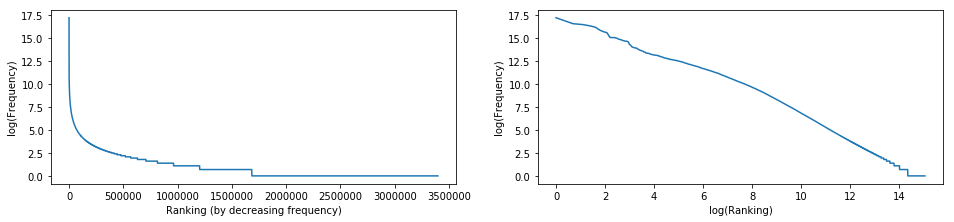

In [56]:
# Plot log(frequency) against ranking and log(frequency) against log(ranking)

fig = plt.figure(figsize = plt.figaspect(0.2))

x1 = np.array(rankings)
y1 = np.array(ranked_frequencies)
    
axis = fig.add_subplot(1, 2, 1)
axis.plot(x1, np.log(y1))
axis.set_xlabel('Ranking (by decreasing frequency)')
axis.set_ylabel('log(Frequency)')

axis = fig.add_subplot(1, 2, 2)
axis.plot(np.log(x1), np.log(y1))
axis.set_xlabel('log(Ranking)')
axis.set_ylabel('log(Frequency)')

In [ ]:
# Calculate probabilities

ranked_probabilities = np.array(ranked_frequencies) / sum(frequencies)

Text(0, 0.5, 'log(Probability)')

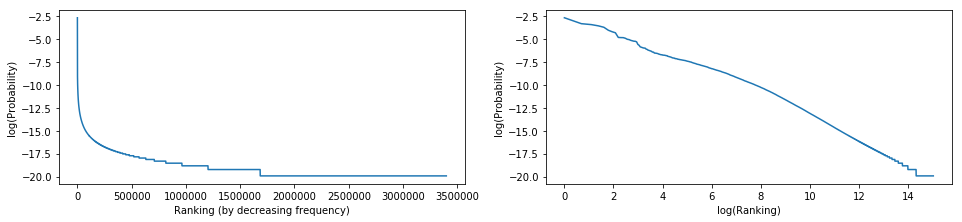

In [52]:
# Plot log(probabilitiy) against ranking and log(probability) against log(ranking)

fig = plt.figure(figsize = plt.figaspect(0.2))
    
x2 = np.array(rankings)
y2 = ranked_probabilities

axis = fig.add_subplot(1, 2, 1)
axis.plot(x2, np.log(y2))
axis.set_xlabel('Ranking (by decreasing frequency)')
axis.set_ylabel('log(Probability)')

axis = fig.add_subplot(1, 2, 2)
axis.plot(np.log(x2), np.log(y2))
axis.set_xlabel('log(Ranking)')
axis.set_ylabel('log(Probability)')

In [14]:
# Parameter estimation for c (r * p = c)
# For MSE: exponential of intercept of log-log graph (see derivation in report)

parameter_mse = np.exp(np.polyfit(np.log(x2), np.log(y2), 1)[1])

parameter_mean = np.mean(np.array(rankings) * ranked_probabilities)

parameter_median = np.median(np.array(rankings) * ranked_probabilities)

print(parameter_mse)
print(parameter_mean)
print(parameter_median)

1.2455094448755415
0.008035810426857838
0.006706328327665579


In [ ]:
# Calculate all values of ranking multiplied by probabilitiy

rp = np.array(rankings) * ranked_probabilities

# Round the values to 1 decimal place

for index in range(len(rp)):
    rp[index] = round(rp[index], 1)

In [ ]:
# Print the indices of the words that have c = 0.1

for index, value in enumerate(rp):
    if value == 0.1:
        print(index)

## Subtask 2: Vector Space Document Retrieval

In [119]:
# Load the document IDs into a list

document_IDs = []

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            document_IDs.append(json.loads(line)['id'])

In [277]:
# [Before removing stopwords]

# Create a list of the first 10 claims in the training subset

ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]

claims = [claim for claim in train_data if claim['id'] in ids]

# Tokenize the claims
# Use the Porter Stemmer for stemming

ps = PorterStemmer()

claims_terms = []

for claim in claims:
    claims_terms.append([ps.stem(term) for term in re.findall(r'\b\w+\b', claim['claim'].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'])
    
# Flatten lists

all_claims_terms = [item for sublist in claims_terms for item in sublist]

# Remove duplicates of words

claims_words = list(set(all_claims_terms))

In [170]:
# Create inverted index for the documents for only the words in the 10 claims

# Dictionary where each key is a word from the claims
# Each value is a set of tuples, each tuple represents a document
# First element of the tuple is the document index
# Second element is the number of times the word appears in the document
# Third element is the number of words in the document

inverted_index = {}
document_number = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term != 'LRB' and term != 'RRB' and term != 'LSB' and term != 'RSB']
            
            for word in claims_words:
                if word in set(tokens):
                    try:
                        inverted_index[word].add((document_number, tokens.count(word), len(tokens)))
                    except KeyError:
                        inverted_index[word] = set()
                        inverted_index[word].add((document_number, tokens.count(word), len(tokens)))
                      
            document_number += 1

In [ ]:
# Create inverted index for the 10 claims

# Dictionary where each key is a word from the claims
# Each value is a set of tuples, each tuple represents a claim
# First element of the tuple is the claim index
# Second element is the number of times the word appears in the claim
# Third element is the number of words in the claim
    
inverted_index_claims = {}

for index, text in tqdm(enumerate(claims_terms)):
    for word in text:
        try:
            inverted_index_claims[word].add((index, text.count(word), len(text)))
        except KeyError:
            inverted_index_claims[word] = set()
            inverted_index_claims[word].add((index, text.count(word), len(text)))
            
for key, value in inverted_index_claims.items():
    inverted_index_claims[key] = list(value)

In [174]:
# Define IDF Function

def IDF(word):
    
    N = len(document_IDs)   
    
    n_t = len(inverted_index[word])
    
    return math.log10(N / n_t)

# Create IDF vector for the words in the claims

words_IDFs = []

for word in claims_words:
    words_IDFs.append(IDF(word))

In [175]:
# Claims TF-IDF representations (matrix)

# Each row represents the claims in the order of IDs:
# [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
# Each column represents a word from the claims

claims_TFs = np.zeros((len(claims), len(claims_words)))

for index, word in tqdm(enumerate(claims_words)):
    for value in inverted_index_claims[word]:
        claims_TFs[value[0]][index] = value[1] / value[2]
        
claims_TFIDFs = np.zeros((len(claims), len(claims_words)))

for i in trange(len(claims_TFs)):
    for index, TF in enumerate(claims_TFs[i]):
        claims_TFIDFs[i][index] = TF * words_IDFs[index]

100%|██████████| 10/10 [00:00<00:00, 3271.18it/s]


In [178]:
# Documents TF-IDF representations (matrix)

# Each row represents a document
# Each column represents a word from the claims

documents_TFs = np.zeros((len(document_IDs), len(claims_words)))

for index, word in tqdm(enumerate(claims_words)):
    for value in tqdm(inverted_index[word]):
        documents_TFs[value[0]][index] = value[1] / value[2]
        
documents_TFIDFs = np.zeros((len(document_IDs), len(claims_words)))

for i in trange(len(documents_TFs)):
    for index, TF in enumerate(documents_TFs[i]):
        documents_TFIDFs[i][index] = TF * words_IDFs[index]

100%|██████████| 5416537/5416537 [05:59<00:00, 15083.10it/s]


In [179]:
# Cosine similarity function

def cossim(v1, v2):
    if np.linalg.norm(v2) != 0:
        return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    else:
        return 0

# Cosine similarity matrix for the 10 claims
# Each row represents a claim
# Each columns represents a document
    
cossim_matrix = np.zeros((len(claims), len(document_IDs)))
    
for index in trange(len(claims_TFIDFs)):    
    cossim_claim = []
    for document_TFIDF in tqdm(documents_TFIDFs):
        cossim_claim.append(cossim(claims_TFIDFs[index], document_TFIDF))
    cossim_matrix[index] = cossim_claim

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:11<19:42, 131.44s/it]

 20%|██        | 2/10 [03:55<16:25, 123.22s/it]

 30%|███       | 3/10 [05:39<13:42, 117.48s/it]

 40%|████      | 4/10 [07:23<11:20, 113.39s/it]

 50%|█████     | 5/10 [09:08<09:14, 110.82s/it]

 60%|██████    | 6/10 [10:52<07:15, 108.84s/it]

 70%|███████   | 7/10 [12:36<05:22, 107.47s/it]

 80%|████████  | 8/10 [14:21<03:33, 106.56s/it]

 90%|█████████ | 9/10 [16:04<01:45, 105.64s/it]

100%|██████████| 10/10 [17:49<00:00, 105.32s/it]


In [181]:
# IDs of 5 most similar documents for each of the 10 claims

for i in trange(len(cossim_matrix)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)' )
    for index in reversed(list(np.argsort(cossim_matrix[i])[-5:])):
        print(document_IDs[index])

  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

A_Thousand_Times_Good_Night
Nukaaka_Coster-Waldau
Ved_verdens_ende
The_Baker_-LRB-film-RRB-
New_Amsterdam_-LRB-TV_series-RRB-
CLAIM  2  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 20%|██        | 2/10 [00:02<00:08,  1.10s/it]

Bedside_Press
Joel_Spolsky
Brett_Atwood
Quetzal_-LRB-disambiguation-RRB-
Jett_Atwood
CLAIM  3  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 30%|███       | 3/10 [00:03<00:08,  1.18s/it]

Research_and_Humanities_in_Medical_Education
See_Change_Festival
Tamil_culture
World_Festival_of_Black_Arts
List_of_art_deities
CLAIM  4  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 40%|████      | 4/10 [00:04<00:06,  1.16s/it]

Cheetah-licious_Christmas
Loni_Love
Cherry_Martinez
Adrienne_Bailon
All_You've_Got
CLAIM  5  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 50%|█████     | 5/10 [00:06<00:05,  1.19s/it]

Homeland_-LRB-season_6-RRB-
Homeland_-LRB-season_2-RRB-
Homeland_-LRB-season_3-RRB-
List_of_Homeland_episodes
Homeland_-LRB-season_4-RRB-
CLAIM  6  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 60%|██████    | 6/10 [00:07<00:04,  1.19s/it]

1974–75_Boston_Celtics_season
1994–95_Boston_Celtics_season
1952_San_Francisco_49ers_season
1985–86_Portland_Trail_Blazers_season
Holy_Cross_Crusaders_men's_basketball
CLAIM  7  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 70%|███████   | 7/10 [00:08<00:03,  1.22s/it]

The_King_of_Kings_-LRB-1927_film-RRB-
The_Ten_Commandments_-LRB-1923_film-RRB-
Take_One
Land_of_the_Pharaohs
Katherine_Orrison
CLAIM  8  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

Tetris
Brain_Wall
Tetris_Friends
Tetri_Giorgi
Tetri_Giorgi_-LRB-disambiguation-RRB-
CLAIM  9  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


 90%|█████████ | 9/10 [00:10<00:01,  1.21s/it]

List_of_awards_and_nominations_received_by_Cyndi_Lauper
Summertime-COLON-_Willie_Nelson_Sings_Gershwin
George_Marino
David_Thornton_-LRB-actor-RRB-
True_Colors_-LRB-Cyndi_Lauper_album-RRB-
CLAIM  10  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST)


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

The_Hunger_-LRB-1986_film-RRB-
Fictional_universe_of_The_Hunger_Games
Jayme_Dee
The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack
Katniss_Everdeen


In [109]:
# [Repetition after removing stopwords]
# Load the first 10 claims from the training subset into a list

stopwords = stopwords.words('english')

ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]

claims = [claim for claim in train_data if claim['id'] in ids]

# Tokenize claims

claims_terms_sw = []
    
for claim in claims:
    claims_terms_sw.append([ps.stem(term) for term in re.findall(r'\b\w+\b', claim['claim'].lower()) if term not in stopwords and term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'])  

# Flatten lists

all_claims_terms_sw = [item for sublist in claims_terms_sw for item in sublist]

# Remove duplicates of words

claims_words_sw = list(set(all_claims_terms_sw))

In [6]:
# Create inverted index for documents

inverted_index_sw = {}
document_number_sw = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB' and term != 'RSB']
            
            for word in claims_words_sw:
                if word in set(tokens):
                    try:
                        inverted_index_sw[word].add((document_number_sw, tokens.count(word), len(tokens)))
                    except KeyError:
                        inverted_index_sw[word] = set()
                        inverted_index_sw[word].add((document_number_sw, tokens.count(word), len(tokens)))
                      
            document_number_sw += 1

In [283]:
# Create inverted index for claims

inverted_index_claims_sw = {}

for index, text in tqdm(enumerate(claims_terms_sw)):
    for word in claims_words_sw:
        if word in set(text):
            try:
                inverted_index_claims_sw[word].add((index, text.count(word), len(text)))
            except KeyError:
                inverted_index_claims_sw[word] = set()
                inverted_index_claims_sw[word].add((index, text.count(word), len(text)))

'for key, value in inverted_index_claims.items():\n    inverted_index_claims[key] = list(value)'

In [284]:
# Define IDF Function

def IDF_sw(word):
    
    N = len(document_IDs)
    
    n_t = len(inverted_index_sw[word])
    
    return math.log10(N / n_t)

In [285]:
# Create IDF vector for relevant words

words_IDFs_sw = []

for word in claims_words_sw:
    words_IDFs_sw.append(IDF(word))

In [267]:
# Claims TF-IDF representations

claims_TFs_sw = np.zeros((len(claims), len(claims_words_sw)))

for index, word in tqdm(enumerate(claims_words_sw)):
    for value in inverted_index_claims_sw[word]:
        claims_TFs_sw[value[0]][index] = value[1] / value[2]
        
claims_TFIDFs_sw = np.zeros((len(claims), len(claims_words_sw)))

for i in trange(len(claims_TFs_sw)):
    for index, TF in enumerate(claims_TFs_sw[i]):
        claims_TFIDFs_sw[i][index] = TF * words_IDFs_sw[index]       

100%|██████████| 10/10 [00:00<00:00, 8405.42it/s]


In [268]:
# Documents TF-IDF representations

documents_TFs_sw = np.zeros((len(document_IDs), len(claims_words_sw))) 

for index, word in tqdm(enumerate(claims_words_sw)):
    for value in tqdm(inverted_index_sw[word]):
        documents_TFs_sw[value[0]][index] = value[1] / value[2]
        
documents_TFIDFs_sw = np.zeros((len(document_IDs), len(claims_words_sw)))

for i in trange(len(documents_TFs_sw)):
    for index, TF in enumerate(documents_TFs_sw[i]):
        documents_TFIDFs_sw[i][index] = TF * words_IDFs_sw[index]

100%|██████████| 5416537/5416537 [05:22<00:00, 16809.59it/s]


In [269]:
# Cosine similarity matrix for the 10 claims
    
cossim_matrix_sw = np.zeros((len(claims), len(documents_IDs)))
    
for index in trange(len(claims_TFIDFs_sw)):    
    cossim_claim_sw = []
    for document_TFIDF_sw in tqdm(documents_TFIDFs_sw):
        cossim_claim_sw.append(cossim(claims_TFIDFs_sw[index], document_TFIDF_sw))
    cossim_matrix_sw[index] = cossim_claim_sw
    
# IDs of 5 most similar documents

for i in trange(len(cossim_matrix_sw)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)' )
    for index in reversed(list(np.argsort(cossim_matrix_sw[i])[-5:])):
        print(document_IDs[index])

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:26<13:01, 86.85s/it]

 20%|██        | 2/10 [02:47<11:19, 85.00s/it]

 30%|███       | 3/10 [04:05<09:39, 82.86s/it]

 40%|████      | 4/10 [05:22<08:07, 81.18s/it]

 50%|█████     | 5/10 [06:38<06:38, 79.70s/it]

 60%|██████    | 6/10 [07:55<05:15, 78.89s/it]

 70%|███████   | 7/10 [09:14<03:56, 78.83s/it]

 80%|████████  | 8/10 [10:34<02:38, 79.22s/it]

 90%|█████████ | 9/10 [11:57<01:20, 80.27s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

A_Thousand_Times_Good_Night
Nukaaka_Coster-Waldau
New_Amsterdam_-LRB-TV_series-RRB-
Ved_verdens_ende
The_Baker_-LRB-film-RRB-
CLAIM  2  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 20%|██        | 2/10 [00:00<00:03,  2.27it/s]

Joel_Spolsky
Bedside_Press
Brett_Atwood
Stack_Overflow
Quetzal_-LRB-disambiguation-RRB-
CLAIM  3  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Research_and_Humanities_in_Medical_Education
See_Change_Festival
Tamil_culture
World_Festival_of_Black_Arts
List_of_art_deities
CLAIM  4  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 40%|████      | 4/10 [00:01<00:02,  2.34it/s]

Cheetah-licious_Christmas
That's_So_Raven_-LRB-season_2-RRB-
Jeannie_Mai
Cherry_Martinez
Loni_Love
CLAIM  5  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

Homeland_-LRB-season_6-RRB-
Homeland_-LRB-season_4-RRB-
Homeland_-LRB-season_3-RRB-
Homeland_-LRB-season_2-RRB-
List_of_Homeland_episodes
CLAIM  6  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 60%|██████    | 6/10 [00:02<00:01,  2.19it/s]

TD_Garden
2014–15_Providence_Friars_men's_ice_hockey_season
Dennis_Johnson
2013_Hockey_East_Men's_Ice_Hockey_Tournament
Royal_Rumble_-LRB-2011-RRB-
CLAIM  7  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 70%|███████   | 7/10 [00:03<00:01,  2.40it/s]

The_King_of_Kings_-LRB-1927_film-RRB-
The_Ten_Commandments_-LRB-1923_film-RRB-
Land_of_the_Pharaohs
Take_One
Katherine_Orrison
CLAIM  8  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 80%|████████  | 8/10 [00:03<00:00,  2.58it/s]

Tetris
Brain_Wall
Tetris_Friends
Tetri_Bazar
Tetri_Giorgi
CLAIM  9  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


 90%|█████████ | 9/10 [00:03<00:00,  2.12it/s]

Jeff_Beck
List_of_awards_and_nominations_received_by_Cyndi_Lauper
Summertime-COLON-_Willie_Nelson_Sings_Gershwin
George_Marino
David_Thornton_-LRB-actor-RRB-
CLAIM  10  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

The_Hunger_-LRB-1986_film-RRB-
District_12,_Ho_Chi_Minh_City
Jayme_Dee
Z'bri
The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack


In [280]:
# Save results to CSV file
# Commas removed from IDs

with open('Q2_tfidfcos.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',', quotechar = '|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['claim id', 'doc id_1', 'doc id_2', 'doc id_3', 'doc id_4', 'doc id_5'])
    writer.writerow([ids[0], 'A_Thousand_Times_Good_Night', 'Nukaaka_Coster-Waldau', 'New_Amsterdam_-LRB-TV_series-RRB-', 'Ved_verdens_ende', 'The_Baker_-LRB-film-RRB-'])
    writer.writerow([ids[1], 'Joel_Spolsky', 'Bedside_Press', 'Brett_Atwood', 'Stack_Overflow', 'Quetzal_-LRB-disambiguation-RRB-'])
    writer.writerow([ids[2], 'Research_and_Humanities_in_Medical_Education', 'See_Change_Festival', 'Tamil_culture', 'World_Festival_of_Black_Arts', 'List_of_art_deities'])
    writer.writerow([ids[3], 'Cheetah-licious_Christmas', "That's_So_Raven_-LRB-season_2-RRB-", 'Jeannie_Mai', 'Cherry_Martinez', 'Loni_Love'])
    writer.writerow([ids[4], 'Homeland_-LRB-season_6-RRB-', 'Homeland_-LRB-season_4-RRB-', 'Homeland_-LRB-season_3-RRB-', 'Homeland_-LRB-season_2-RRB-', 'List_of_Homeland_episodes'])
    writer.writerow([ids[5], 'TD_Garden', "2014–15_Providence_Friars_men's_ice_hockey_season", 'Dennis_Johnson', "2013_Hockey_East_Men's_Ice_Hockey_Tournament", 'Royal_Rumble_-LRB-2011-RRB-'])
    writer.writerow([ids[6], 'The_King_of_Kings_-LRB-1927_film-RRB-', 'The_Ten_Commandments_-LRB-1923_film-RRB-', 'Land_of_the_Pharaohs', 'Take_One', 'Katherine_Orrison'])
    writer.writerow([ids[7], 'Tetris', 'Brain_Wall', 'Tetris_Friends', 'Tetri_Bazar', 'Tetri_Giorgi'])
    writer.writerow([ids[8], 'Jeff_Beck', 'List_of_awards_and_nominations_received_by_Cyndi_Lauper', 'Summertime-COLON-_Willie_Nelson_Sings_Gershwin', 'George_Marino', 'David_Thornton_-LRB-actor-RRB-'])
    writer.writerow([ids[9], 'The_Hunger_-LRB-1986_film-RRB-', 'District_12_Ho_Chi_Minh_City', 'Jayme_Dee', "Z'bri", 'The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack'])

## Subtask 3: Probabilistic Document Retrieval

In [315]:
# Build query-likelihood unigram language model
# Each row of matrix represents a claim
# Each column represents a document

probmatrix = np.zeros((len(claims), len(document_IDs)))
document_number = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
          
            probability = 1
          
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB']  
            
            for index, claim in enumerate(claims_terms_sw):
                
                probability = 1
                
                if set(claim).issubset(tokens):
                    
                    for word in set(claim):
                        
                        probability *= tokens.count(word) / len(tokens)
                    
                    probmatrix[index][document_number] = probability
                        
            document_number += 1

In [317]:
# IDs of 5 most similar documents

for i in trange(len(claims)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)' )
    for index in reversed(list(np.argsort(probmatrix[i])[-5:])):
        print(document_IDs[index])

  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)


 10%|█         | 1/10 [00:00<00:01,  4.83it/s]

Daniel_Kottke
Jim_Smith_-LRB-footballer,_born_1947-RRB-
Jerry_Bowman
Jiří_Jeslínek_-LRB-footballer,_born_1962-RRB-
James_H._Standish_House
CLAIM  2  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)


 30%|███       | 3/10 [00:00<00:01,  4.92it/s]

Daniel_Kottke
Jim_Smith_-LRB-footballer,_born_1947-RRB-
Jerry_Bowman
Jiří_Jeslínek_-LRB-footballer,_born_1962-RRB-
James_H._Standish_House
CLAIM  3  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)
History_of_art
Daniel_Kottke
Jatinegara
Jiří_Jeslínek_-LRB-footballer,_born_1962-RRB-
James_H._Standish_House
CLAIM  4  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)


 50%|█████     | 5/10 [00:00<00:00,  5.15it/s]

Daniel_Kottke
Jim_Smith_-LRB-footballer,_born_1947-RRB-
Jerry_Bowman
Jiří_Jeslínek_-LRB-footballer,_born_1962-RRB-
James_H._Standish_House
CLAIM  5  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)
Homeland_-LRB-TV_series-RRB-
Daniel_Kottke
Jiří_Jeslínek_-LRB-footballer,_born_1962-RRB-
James_H._Standish_House
Jan_Frodeno
CLAIM  6  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)


 70%|███████   | 7/10 [00:01<00:00,  5.31it/s]

List_of_Boston_Celtics_head_coaches
Boston_Celtics
KDrew
Red_Auerbach
1995_NBA_Playoffs
CLAIM  7  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)
Katherine_Orrison
The_Nth_Commandment
The_Ten_Commandments_-LRB-1923_film-RRB-
The_King_of_Kings_-LRB-1927_film-RRB-
Fredric_M._Frank
CLAIM  8  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)


 90%|█████████ | 9/10 [00:01<00:00,  5.52it/s]

Tetris
John_Batchelor_-LRB-illustrator-RRB-
Jan_Suchorzewski
Jerry_Bowman
Jiří_Jeslínek_-LRB-footballer,_born_1962-RRB-
CLAIM  9  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)
Cyndi_Lauper
Daniel_Kottke
James_Kaminsky
Jan_Suchorzewski
Jerry_Bowman
CLAIM  10  5 MOST RELEVANT DOCUMENTS QLM (FROM MOST TO LEAST)


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]

Nina_Jacobson
The_Hunger_Games
Jo_Blankenburg
Laurie_Spiegel
Exodus_-LRB-Andy_Hunter_album-RRB-


In [283]:
# Save results to CSV file
# Commas removed from IDs

with open('Q3_ql.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',', quotechar = '|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['claim id', 'doc id_1', 'doc id_2', 'doc id_3', 'doc id_4', 'doc id_5'])
    writer.writerow([ids[0], 'Daniel_Kottke', 'Jim_Smith_-LRB-footballer_born_1947-RRB-', 'Jerry_Bowman', 'Jiří_Jeslínek_-LRB-footballer_born_1962-RRB-', 'James_H._Standish_House'])
    writer.writerow([ids[1], 'Daniel_Kottke', 'Jim_Smith_-LRB-footballer_born_1947-RRB-', 'Jerry_Bowman', 'Jiří_Jeslínek_-LRB-footballer_born_1962-RRB-', 'James_H._Standish_House'])
    writer.writerow([ids[2], 'History_of_art', 'Daniel_Kottke', 'Jatinegra', 'Jiří_Jeslínek_-LRB-footballer_born_1962-RRB-', 'James_H._Standish_House'])
    writer.writerow([ids[3], 'Daniel_Kottke', 'Jim_Smith_-LRB-footballer_born_1947-RRB-', 'Jerry_Bowman', 'Jiří_Jeslínek_-LRB-footballer_born_1962-RRB-', 'James_H._Standish_House'])
    writer.writerow([ids[4], 'Homeland_-LRB-TV_series-RRB-', 'Daniel_Kottke', 'Jiří_Jeslínek_-LRB-footballer_born_1962-RRB-', 'James_H._Standish_House', 'Jan_Frodeno'])
    writer.writerow([ids[5], 'List_of_Boston_Celtics_head_coaches', "Boston_Celtics", 'KDrew', "Red_Auerbach", '1995_NBA_Playoffs'])
    writer.writerow([ids[6], 'Katherine_Orrison', 'The_Nth_Commandment', 'The_Ten_Commandments_', 'The_King_of_Kings_-LRB-1927_film-RRB-', 'Fredric_M._Frank'])
    writer.writerow([ids[7], 'Tetris', 'John_Batchelor_-LRB-illustrator-RRB-', 'Jan_Suchorzewski', 'Jerry_Bowman', 'Jiří_Jeslínek_-LRB-footballer_born_1962-RRB-'])
    writer.writerow([ids[8], 'Cyndi_Lauper', 'Daniel_Kottke', 'James_Kaminsky', 'Jan_Suchorzewski', 'Jerry_Bowman'])
    writer.writerow([ids[9], 'Nina_Jacobson', 'The_Hunger_Games', 'Jo_Blankenburg', "Laurie_Spiegel", 'Exodus_-LRB-Andy_Hunter_album-RRB-'])

In [145]:
# Find number of unique words in document collection (vocabulary size)

vocabulary = set()

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB']
            
            vocabulary.update(tokens)
                    
vocabulary_length = len(vocabulary)

In [147]:
# Build language model with Laplace smoothing
# Each row of matrix represents a claim
# Each column represents a document

probmatrix_lap = np.zeros((len(claims), len(document_IDs)))
document_number = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
          
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB'] 
                   
            for index, claim in enumerate(claims_terms_sw):
                
                probability = 1
                
                for word in set(claim):
                    
                    probability *= (tokens.count(word) + 1) / (len(tokens) + vocabulary_length)
                    
                probmatrix_lap[index][document_number] = probability
                      
            document_number += 1                    

In [149]:
# IDs of 5 most similar documents

for i in trange(len(claims)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)' )
    for index in reversed(list(np.argsort(probmatrix_lap[i])[-5:])):
        print(document_IDs[index])

  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 10%|█         | 1/10 [00:00<00:07,  1.17it/s]

List_of_early_British_private_locomotive_manufacturers
Fox_Broadcasting_Company
Lar_Lubovitch_Dance_Company
NBC_Opera_Theatre
British_National_Opera_Company
CLAIM  2  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 20%|██        | 2/10 [00:01<00:07,  1.14it/s]

List_of_video_game_crowdfunding_projects
List_of_Chinese_hymn_books
History_of_Rome_-LRB-disambiguation-RRB-
List_of_Maxillaria_species
Agri_Decumates
CLAIM  3  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 30%|███       | 3/10 [00:02<00:06,  1.13it/s]

List_of_New_Music_America_performances
Acropolis_Institute_of_Technology_and_Research
List_of_video_game_crowdfunding_projects
List_of_Guggenheim_Fellowships_awarded_in_1968
The_Nritarutya_Dance_Collective
CLAIM  4  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 40%|████      | 4/10 [00:03<00:05,  1.11it/s]

Adrienne_Bailon
International_Accounting_Standards_Committee
Continuous_accounting
IFACnet
Nigerian_College_of_Accountancy
CLAIM  5  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 50%|█████     | 5/10 [00:04<00:05,  1.01s/it]

List_of_video_game_crowdfunding_projects
List_of_prisoners_of_war
List_of_books_by_Jacob_Neusner
Homeland_-LRB-TV_series-RRB-
List_of_fictional_anthropologists
CLAIM  6  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 60%|██████    | 6/10 [00:05<00:04,  1.02s/it]

List_of_video_game_crowdfunding_projects
1984_NBA_Finals
Jeremy_Owens
Sports_in_Boston
1995_NBA_Playoffs
CLAIM  7  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 70%|███████   | 7/10 [00:06<00:03,  1.01s/it]

The_Ten_Commandments_-LRB-1956_film-RRB-
Cecil_B._DeMille
List_of_accolades_received_by_Master_and_Commander-COLON-_The_Far_Side_of_the_World
List_of_video_game_crowdfunding_projects
Dan_Gitlin
CLAIM  8  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]

Jolin_Tsai_discography
Eminem_discography
List_of_best-selling_Xbox_360_video_games
Usher_discography
Whitney_Houston_discography
CLAIM  9  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


 90%|█████████ | 9/10 [00:09<00:01,  1.07s/it]

Cyndi_Lauper
List_of_awards_and_nominations_received_by_Madonna
Lo_Nuestro_Award_for_Pop_New_Artist_of_the_Year
List_of_awards_and_nominations_received_by_Leonard_Cohen
Country_music_awards
CLAIM  10  5 MOST RELEVANT DOCUMENTS LAP (FROM MOST TO LEAST)


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]

List_of_video_game_crowdfunding_projects
List_of_PlayStation_3_games_released_on_disc
The_Hunger_Games
List_of_accolades_received_by_The_Hunger_Games_film_series
List_of_Nintendo_DS_games


In [288]:
# Save results to CSV file
# Commas removed from IDs

with open('Q3_ql_laplace.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',', quotechar = '|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['claim id', 'doc id_1', 'doc id_2', 'doc id_3', 'doc id_4', 'doc id_5'])
    writer.writerow([ids[0], 'List_of_early_British_private_locomotive_manufacturers', 'Fox_Broadcasting_Company', 'Lar_Lubovitch_Dance_Company', 'NBC_Opera_Theatre', 'British_National_Opera_Company'])
    writer.writerow([ids[1], 'List_of_video_game_crowdfunding_projects', 'List_of_Chinese_hymn_books', 'History_of_Rome_-LRB-disambiguation-RRB-', 'List_of_Maxillaria_species', 'Agri_Decumates'])
    writer.writerow([ids[2], 'List_of_New_Music_America_performances', 'Acropolis_Institute_of_Technology_and_Research', 'List_of_video_game_crowdfunding_projects', 'List_of_Guggenheim_Fellowships_awarded_in_1968', 'The_Nritarutya_Dance_Collective'])
    writer.writerow([ids[3], 'Adrienne_Bailon', 'International_Accounting_Standards_Committee', 'Continuous_accounting', 'IFACnet', 'Nigerian_College_of_Accountancy'])
    writer.writerow([ids[4], 'List_of_video_game_crowdfunding_projects', 'List_of_prisoners_of_war', 'List_of_books_by_Jacob_Neusner', 'Homeland_-LRB-TV_series-RRB-', 'List_of_fictional_anthropologists'])
    writer.writerow([ids[5], 'List_of_video_game_crowdfunding_projects', "1984_NBA_Finals", 'Jeremy_Owens', "Sports_in_Boston", '1995_NBA_Playoffs'])
    writer.writerow([ids[6], 'The_Ten_Commandments_-LRB-1956_film-RRB-', 'Cecil_B._DeMille', 'List_of_accolades_received_by_Master_and_Commander-COLON-_The_Far_Side_of_the_World', 'List_of_video_game_crowdfunding_projects', 'Dan_Gitlin'])
    writer.writerow([ids[7], 'Jolin_Tsai_discography', 'Eminem_discography', 'List_of_best-selling_Xbox_360_video_games', 'Usher_discography', 'Whitney_Houston_discography'])
    writer.writerow([ids[8], 'Cyndi_Lauper', 'List_of_awards_and_nominations_received_by_Madonna', 'Lo_Nuestro_Award_for_Pop_New_Artist_of_the_Year', 'List_of_awards_and_nominations_received_by_Leonard_Cohen', 'Country_music_awards'])
    writer.writerow([ids[9], 'List_of_video_game_crowdfunding_projects', 'List_of_PlayStation_3_games_released_on_disc', 'The_Hunger_Games', "List_of_accolades_received_by_The_Hunger_Games_film_series", 'List_of_Nintendo_DS_games'])

In [7]:
# Calculate total words and average doc length

total_words = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB']
            
            total_words += len(tokens)
                    
average = total_words / len(document_IDs)

In [8]:
# Create dictionary containing each word's total occurrences ratio: 
# number of times word appears in collection / total number of words in collection

word_occs = {}

for word in claims_words_sw:
    word_occs[word] = sum(value[1] for value in inverted_index_sw[word]) / total_words

In [23]:
# Build language model with Jelinek-Mercer smoothing
# Each row of matrix represents a claim
# Each column represents a document

probmatrix_jm = np.zeros((len(claims), len(document_IDs)))
document_number = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():         
          
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB'] 
                   
            if len(tokens) > 0:
            
                for index, claim in enumerate(claims_terms_sw):
                    
                    probability = 1
                    
                    for word in set(claim):
                        
                        probability *=  0.5 * (tokens.count(word) / len(tokens)) + 0.5 * word_occs[word]
                    
                    probmatrix_jm[index][document_number] = probability
                      
            document_number += 1    

In [24]:
# IDs of 5 most similar documents

for i in trange(len(claims)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)' )
    for index in reversed(list(np.argsort(probmatrix_jm[i])[-5:])):
        print(document_IDs[index])

  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 10%|█         | 1/10 [00:00<00:03,  2.67it/s]

New_Amsterdam_-LRB-TV_series-RRB-
Nikolaj_Coster-Waldau
Ved_verdens_ende
The_Other_Woman_-LRB-2014_film-RRB-
Nukaaka_Coster-Waldau
CLAIM  2  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 20%|██        | 2/10 [00:00<00:02,  2.91it/s]

Bedside_Press
Brett_Atwood
Joel_Spolsky
Genre_fiction
Mary_Walsh-COLON-_Open_Book
CLAIM  3  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

History_of_art
Fine_art
Sky_Arts_-LRB-New_Zealand-RRB-
The_arts
Narrative
CLAIM  4  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 40%|████      | 4/10 [00:01<00:02,  2.68it/s]

Empire_Girls-COLON-_Julissa_and_Adrienne
All_You've_Got
Adrienne_Bailon
Julissa_Bermudez
3LW
CLAIM  5  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 50%|█████     | 5/10 [00:01<00:02,  2.48it/s]

List_of_Homeland_episodes
Homeland_-LRB-TV_series-RRB-
Homeland_-LRB-season_3-RRB-
Homeland_-LRB-season_6-RRB-
Homeland_-LRB-season_2-RRB-
CLAIM  6  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 60%|██████    | 6/10 [00:02<00:01,  2.41it/s]

TD_Garden
1974–75_Boston_Celtics_season
Boston_Garden
2006_Hockey_East_Men's_Ice_Hockey_Tournament
2007_Hockey_East_Men's_Ice_Hockey_Tournament
CLAIM  7  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 70%|███████   | 7/10 [00:02<00:01,  2.28it/s]

Katherine_Orrison
The_Nth_Commandment
The_Ten_Commandments_-LRB-1923_film-RRB-
The_King_of_Kings_-LRB-1927_film-RRB-
Fredric_M._Frank
CLAIM  8  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 80%|████████  | 8/10 [00:03<00:00,  2.46it/s]

Tetris
List_of_best-selling_Game_Boy_video_games
Yah_Yah_Yah_/_Yume_no_Bannin
Departures_-LRB-Globe_song-RRB-
True_Love_-LRB-Fumiya_Fujii_song-RRB-
CLAIM  9  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 90%|█████████ | 9/10 [00:03<00:00,  2.27it/s]

Cyndi_Lauper
She's_So_Unusual
List_of_awards_and_nominations_received_by_Cyndi_Lauper
Shine_On-COLON-_The_Ultimate_Collection
Dare_to_Be_Stupid
CLAIM  10  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

Nina_Jacobson
The_Hunger_Games
MTV_Movie_Award_for_Best_On-Screen_Transformation
The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack
Jo_Blankenburg


In [287]:
# Save results to CSV file
# Commas removed from IDs

with open('Q3_ql_jm.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',', quotechar = '|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['claim id', 'doc id_1', 'doc id_2', 'doc id_3', 'doc id_4', 'doc id_5'])
    writer.writerow([ids[0], 'New_Amsterdam_-LRB-TV_series-RRB-', 'Nikolaj_Coster-Waldau', 'Ved_verdens_ende', 'The_Other_Woman_-LRB-2014_film-RRB-', 'Nukaaka_Coster-Waldau'])
    writer.writerow([ids[1], 'Bedside_Press', 'Brett_Atwood', 'Joel_Spolsky', 'Genre_fiction', 'Mary_Walsh-COLON-_Open_Book'])
    writer.writerow([ids[2], 'History_of_art', 'Fine_art', 'Sky_Arts_-LRB-New_Zealand-RRB-', 'The_arts', 'Narrative'])
    writer.writerow([ids[3], 'Empire_Girls-COLON-_Julissa_and_Adrienne', "All_You've_Got", 'Adrienne_Bailon', 'Julissa_Bermudez', '3LW'])
    writer.writerow([ids[4], 'List_of_Homeland_episodes', "Homeland_-LRB-TV_series-RRB-", 'Homeland_-LRB-season_3-RRB-', 'Homeland_-LRB-season_6-RRB-', 'Homeland_-LRB-season_2-RRB-'])
    writer.writerow([ids[5], 'TD_Garden', "1974–75_Boston_Celtics_season", 'Boston_Garden', "2006_Hockey_East_Men's_Ice_Hockey_Tournament", "2006_Hockey_East_Men's_Ice_Hockey_Tournament"])
    writer.writerow([ids[6], 'Katherine_Orrison', 'The_Nth_Commandment', 'The_Ten_Commandments_-LRB-1923_film-RRB-', 'The_King_of_Kings_-LRB-1927_film-RRB-', 'Fredric_M._Frank'])
    writer.writerow([ids[7], 'Tetris', 'List_of_best-selling_Game_Boy_video_games', 'Yah_Yah_Yah_/_Yume_no_Bannin', 'Departures_-LRB-Globe_song-RRB-', 'True_Love_-LRB-Fumiya_Fujii_song-RRB-'])
    writer.writerow([ids[8], 'Cyndi_Lauper', "She's_So_Unusual", 'List_of_awards_and_nominations_received_by_Cyndi_Lauper', 'Shine_On-COLON-_The_Ultimate_Collection', 'Dare_to_Be_Stupid'])
    writer.writerow([ids[9], 'Nina_Jacobson', 'The_Hunger_Games', 'MTV_Movie_Award_for_Best_On-Screen_Transformation', "The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack", 'Jo_Blankenburg'])

In [27]:
# Build language model with Dirichlet smoothing
# Each row of matrix represents a claim
# Each column represents a document

probmatrix_dir = np.zeros((len(claims), len(document_IDs))) 
document_number = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
                
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']

            if len(tokens) > 0:
            
                for index, claim in enumerate(claims_terms_sw):
                
                    prob = 1
                
                    for word in set(claim):
                    
                        prob *= (len(tokens) / (len(tokens) + average)) * (tokens.count(word) / len(tokens)) + ((average) / (len(tokens) + average)) * word_occs[word]
                    
                    probmatrix_dir[index][document_number] = prob
                
            document_number += 1

"for file in tqdm(os.listdir(path = 'wiki-pages')): \n    with open('wiki-pages/' + file,'r') as openfile:\n        for line in openfile.readlines():\n          \n            log_probability = 0\n          \n            terms = re.findall(r'\x08\\w+\x08', json.loads(line)['text'].lower())\n            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB'] \n                    \n            for index, claim in enumerate(claims_terms_sw):\n                for word in set(claim):\n                    \n                    word_occurrences = 0\n                    for value in inverted_index_sw[word]:\n                        word_occurrences += value[1]\n                        \n                log_probability +=  np.log(((len(tokens) / (len(tokens) + 54.2773277464919)) * (tokens.count(word) / len(tokens)) + ((54.2773277464919) / (len(tokens) + 54.2773277464919)) * (word_occurrences / 293995154))) #CHANGE TO average aAND

In [29]:
# IDs of 5 most similar documents

for i in trange(len(claims)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS DIR (FROM MOST TO LEAST)' )
    for index in reversed(list(np.argsort(probmatrix_dir[i])[-5:])):
        print(document_IDs[index]) 

  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 10%|█         | 1/10 [00:00<00:07,  1.22it/s]

New_Amsterdam_-LRB-TV_series-RRB-
Nikolaj_Coster-Waldau
Ved_verdens_ende
The_Other_Woman_-LRB-2014_film-RRB-
Nukaaka_Coster-Waldau
CLAIM  2  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 20%|██        | 2/10 [00:01<00:06,  1.16it/s]

Bedside_Press
Brett_Atwood
Joel_Spolsky
Genre_fiction
Mary_Walsh-COLON-_Open_Book
CLAIM  3  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 30%|███       | 3/10 [00:02<00:06,  1.15it/s]

History_of_art
Fine_art
Sky_Arts_-LRB-New_Zealand-RRB-
Narrative
Art
CLAIM  4  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 40%|████      | 4/10 [00:03<00:05,  1.20it/s]

Empire_Girls-COLON-_Julissa_and_Adrienne
Adrienne_Bailon
All_You've_Got
Julissa_Bermudez
I'm_in_Love_with_a_Church_Girl
CLAIM  5  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 50%|█████     | 5/10 [00:04<00:04,  1.20it/s]

Homeland_-LRB-TV_series-RRB-
List_of_Homeland_episodes
Rodina_-LRB-TV_series-RRB-
List_of_awards_and_nominations_received_by_Homeland
Homeland_-LRB-season_3-RRB-
CLAIM  6  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 60%|██████    | 6/10 [00:05<00:03,  1.14it/s]

TD_Garden
Boston_Garden
List_of_Boston_Celtics_head_coaches
Boston_Celtics
1974–75_Boston_Celtics_season
CLAIM  7  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 70%|███████   | 7/10 [00:06<00:02,  1.17it/s]

The_Nth_Commandment
Katherine_Orrison
The_Ten_Commandments_-LRB-1956_film-RRB-
The_Ten_Commandments_-LRB-1923_film-RRB-
Peplum_-LRB-film_genre-RRB-
CLAIM  8  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

Tetris
List_of_best-selling_Game_Boy_video_games
Yah_Yah_Yah_/_Yume_no_Bannin
True_Love_-LRB-Fumiya_Fujii_song-RRB-
Departures_-LRB-Globe_song-RRB-
CLAIM  9  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


 90%|█████████ | 9/10 [00:08<00:00,  1.06it/s]

Cyndi_Lauper
She's_So_Unusual
List_of_awards_and_nominations_received_by_Cyndi_Lauper
Shine_On-COLON-_The_Ultimate_Collection
Dare_to_Be_Stupid
CLAIM  10  5 MOST RELEVANT DOCUMENTS J-M (FROM MOST TO LEAST)


100%|██████████| 10/10 [00:08<00:00,  1.08it/s]

The_Hunger_Games
Nina_Jacobson
Jo_Blankenburg
The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack
MTV_Movie_Award_for_Best_On-Screen_Transformation


In [286]:
# Save results to CSV file
# Commas removed from IDs

with open('Q3_ql_dirichlet.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',', quotechar = '|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['claim id', 'doc id_1', 'doc id_2', 'doc id_3', 'doc id_4', 'doc id_5'])
    writer.writerow([ids[0], 'New_Amsterdam_-LRB-TV_series-RRB-', 'Nikolaj_Coster-Waldau', 'Ved_verdens_ende', 'The_Other_Woman_-LRB-2014_film-RRB-', 'Nukaaka_Coster-Waldau'])
    writer.writerow([ids[1], 'Bedside_Press', 'Brett_Atwood', 'Joel_Spolsky', 'Genre_fiction', 'Mary_Walsh-COLON-_Open_Book'])
    writer.writerow([ids[2], 'History_of_art', 'Fine_art', 'Sky_Arts_-LRB-New_Zealand-RRB-', 'Narrative', 'Art'])
    writer.writerow([ids[3], 'Empire_Girls-COLON-_Julissa_and_Adrienne', "Adrienne_Bailon", "All_You've_Got", 'Julissa_Bermudez', "I'm_in_Love_with_a_Church_Girl"])
    writer.writerow([ids[4], 'Homeland_-LRB-TV_series-RRB-', "List_of_Homeland_episodes", 'Rodina_-LRB-TV_series-RRB-', 'List_of_awards_and_nominations_received_by_Homeland', 'Homeland_-LRB-season_3-RRB-'])
    writer.writerow([ids[5], 'TD_Garden', "Boston_Garden", 'List_of_Boston_Celtics_head_coaches', "Boston_Celtics", "1974–75_Boston_Celtics_season"])
    writer.writerow([ids[6], 'The_Nth_Commandment', 'Katherine_Orrison', 'The_Ten_Commandments_-LRB-1956_film-RRB-', 'The_Ten_Commandments_-LRB-1923_film-RRB-', 'Peplum_-LRB-film_genre-RRB-'])
    writer.writerow([ids[7], 'Tetris', 'List_of_best-selling_Game_Boy_video_games', 'Yah_Yah_Yah_/_Yume_no_Bannin', 'True_Love_-LRB-Fumiya_Fujii_song-RRB-', 'Departures_-LRB-Globe_song-RRB-'])
    writer.writerow([ids[8], 'Cyndi_Lauper', "She's_So_Unusual", 'List_of_awards_and_nominations_received_by_Cyndi_Lauper', 'Shine_On-COLON-_The_Ultimate_Collection', 'Dare_to_Be_Stupid'])
    writer.writerow([ids[9], 'The_Hunger_Games', 'Nina_Jacobson', 'Jo_Blankenburg', "The_Hunger_Games-COLON-_Catching_Fire_–_Original_Motion_Picture_Soundtrack", 'MTV_Movie_Award_for_Best_On-Screen_Transformation'])

## Subtask 4: Sentence Relevance

In [2]:
# Load pre-trained word embeddings (GloVe)

words = pd.read_table('glove.6B.50d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

def word_vector(word):
    return words.loc[word].as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# Averaged vector for unknown words
# Vector provided by Jeffrey Pennington (GloVe author)

unknown_vec = [float(i) for i in '-0.12920076 -0.28866628 -0.01224866 -0.05676644 -0.20210965 -0.08389011 0.33359843  0.16045167  0.03867431  0.17833012  0.04696583 -0.00285802 0.29099807  0.04613704 -0.20923874 -0.06613114 -0.06822549  0.07665912 0.3134014   0.17848536 -0.1225775  -0.09916984 -0.07495987  0.06413227 0.14441176  0.60894334  0.17463093  0.05335403 -0.01273871  0.03474107 -0.8123879  -0.04688699  0.20193407  0.2031118  -0.03935686  0.06967544 -0.01553638 -0.03405238 -0.06528071  0.12250231  0.13991883 -0.17446303 -0.08011883  0.0849521  -0.01041659 -0.13705009  0.20127155  0.10069408 0.00653003  0.01685157'.split()]

unknown_vec = np.array(unknown_vec)

In [266]:
# Take first claim from training sunset

# Claim 75397 and TF-IDF 5 relevant documents sentences embeddings
# Sum vectors in each claim and each of the sentences then concatenate
# List of 5 lists
# Each sublist contains the claim-sentence pair 100d concatenated vector

claim_terms = re.findall(r'\b\w+\b', claims[0]['claim'].lower())

claim_vectors = []

for word in claim_terms:
     claim_vectors.append(word_vector(word))
        
claim_embedding = np.array(sum(claim_vectors))
        
# Shape of 50

relevant_docs = ['A_Thousand_Times_Good_Night', 'Nukaaka_Coster-Waldau', 'New_Amsterdam_-LRB-TV_series-RRB-', 'Ved_verdens_ende', 'The_Baker_-LRB-film-RRB-']
        
embeddings = []
    
for ID in tqdm(relevant_docs):
    for file in tqdm(os.listdir(path = 'wiki-pages')): 
        with open('wiki-pages/' + file,'r') as openfile:
            for line in openfile.readlines():
                if json.loads(line)['id'] == ID:
                    
                    doc_lines = json.loads(line)['lines']
                    
                    claim_sentence_pairs = []
                    
                    sentences = []
                    
                    # Split document into lines
                    
                    for i in range(len(doc_lines.split('\n'))):
                        sentences.append(doc_lines.split('\n')[i][2:].split('\t')[0])           
      
                    for sentence in sentences:
                        sentence_terms = [term for term in re.findall(r'\b\w+\b', sentence.lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']
                
                        sentence_embedding = np.zeros(50)
                        for word in sentence_terms:
                            try:
                                sentence_embedding += word_vector(word)
                            except KeyError:
                                sentence_embedding += unknown_vec
                                
                        claim_sentence_pairs.append(np.concatenate((claim_embedding, sentence_embedding)))
                        
                    embeddings.append(claim_sentence_pairs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [5]:
# Load document lines

document_lines = {}

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            document_lines[json.loads(line)['id']] = json.loads(line)['lines']

In [6]:
# List of verifiable claims

ver_train_data = [claim for claim in train_data if claim['verifiable'] == 'VERIFIABLE']

In [7]:
# List of claims with evidence

claim_and_evidence = []

for claim in ver_train_data:
    claim_and_evidence.append((claim['claim'], claim['evidence']))

In [9]:
# Features (relevant and nonrelevant claim-sentence pairs) and labels (1s and 0s)
# Only included evidence that does not require multiple sources to prove the claim

relevant_pairs = []
nonrelevant_pairs = []

relevant_examples = 0
nonrelevant_examples = 1

features = []
labels = []

for claim in tqdm(claim_and_evidence):
    for evidence in claim[1][0]:
    
        sentences = []
   
        try:
         
            for i in range(len(document_lines[evidence[2]].split('\n'))):
                sentences.append(document_lines[evidence[2]].split('\n')[i][2:].split('\t')[0])           
      
            features.append([claim[0], sentences[evidence[3]]])
        
            labels.append(1)
      
            N = len(sentences)
      
            relevant_line_indices = []
        
            relevant_examples += 1
      
            try:
        
                for evidence2 in [e for e in claim[1][0] if e[2] == evidence[2]]:
            
                    relevant_line_indices.append(evidence2[3])
        
                nonrelevant_line_index = random.sample([i for i in list(range(N)) if i not in relevant_line_indices and len(re.findall(r'\b\w+\b', sentences[i])) > 2], 1)[0]
                
                features.append([claim[0], sentences[nonrelevant_line_index]])  
            
                labels.append(0)
                
                nonrelevant_examples += 1
        
            except ValueError:
                pass
        
        except KeyError:
            pass
        
y = np.array(labels)

In [56]:
# Check balance

print(relevant_examples)
print(nonrelevant_examples)
print(relevant_examples / (relevant_examples + nonrelevant_examples) * 100, '%')

127173
125304
50.37013272496108 %


In [134]:
# Tokenize the claims and evidence

for i in trange(len(features)):
    features[i][0] = [term for term in re.findall(r'\b\w+\b', features[i][0].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'] 
    features[i][1] = [term for term in re.findall(r'\b\w+\b', features[i][1].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'] 

100%|██████████| 252476/252476 [00:08<00:00, 30988.32it/s]


In [135]:
# Create input feature matrix by summing vectors and concatenating

x = np.empty((len(y), 100))

for i in trange(len(features)):
    
    concatenated = np.empty(0)
    
    for j in range(len(features[i])):
        
        summed = np.zeros(50)
        
        for k in range(len(features[i][j])):
            
            try:
                summed += word_vector(features[i][j][k])
            except KeyError:
                summed += unknown_vec
                
        concatenated = np.concatenate((concatenated, summed))       
        
    x[i] = concatenated

  0%|          | 0/252476 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 252476/252476 [16:46:14<00:00,  4.23it/s]     


In [14]:
# Logistic regression

# Define sigmoid function

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [15]:
# Define log cost function

def cost(Y_hat, Y):
    
    m = len(Y)
    
    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

In [38]:
# Training

def training(theta, X, Y, learning_rate, epochs):
    
    losses = []
    
    for epoch in range(epochs):
        
        # Add bias
        
        X_bias = np.hstack([np.zeros([X.shape[0], 1]), X])
        
        # Make prediction
        
        prediction = sigmoid(np.matmul(X_bias, theta))
        
        # Calculate cost
            
        loss = cost(prediction, Y)
            
        # Gradient
            
        m = len(Y)
            
        gradient = (1 / m) * np.matmul(X_bias.T, prediction - Y)
            
        # Update weights
            
        theta -= gradient * learning_rate
        
        # Log Progress
        
        if epoch % 100 == 0:
            print("Epoch: " + str(epoch) + " Cost: "+str(loss))
            
        losses.append(loss)
        
    plt.plot(losses)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
      
    return theta

In [209]:
# lr = 0.0001

weights1 = training(np.zeros(101), x, y, 0.0001, 10)

Epoch: 0 Cost: 0.693147180559945


array([ 0.00000000e+00,  9.67083236e-06,  3.27647494e-05, -2.21287839e-05,
        5.67231652e-06,  2.82387487e-05,  3.12710231e-05, -5.59009312e-05,
       -2.05837572e-05, -1.49650799e-05, -3.05584260e-06,  8.42290772e-06,
        1.02414206e-05, -3.74583397e-05, -3.23665860e-06,  4.05664656e-05,
       -6.69338555e-06,  5.73075731e-06,  8.80887655e-06, -6.07615775e-05,
        1.20905725e-06,  8.68338072e-06,  1.94422183e-05,  1.16836372e-05,
        5.53328997e-06,  2.20520886e-06, -1.44560960e-04, -3.63470090e-05,
       -7.83088907e-06, -1.54821968e-05, -1.12290773e-05,  2.84899789e-04,
       -1.83718370e-05, -1.01906555e-05, -3.18344112e-05,  1.03737343e-05,
       -2.86271895e-06,  1.08736333e-05,  6.66846547e-06, -2.53011680e-06,
       -2.25178084e-05, -8.19554300e-06,  2.41493775e-05, -1.43116787e-05,
       -2.80192397e-05, -1.90607979e-05,  9.69541157e-06, -1.82600559e-05,
       -3.64682651e-05, -1.00409959e-05,  5.80687126e-06, -3.33939379e-04,
        1.10711240e-04, -

Epoch: 0 Cost: 0.693147180559945
Epoch: 100 Cost: 0.6422346397706976
Epoch: 200 Cost: 0.635711677858483
Epoch: 300 Cost: 0.6330674709505314
Epoch: 400 Cost: 0.6316653699307846
Epoch: 500 Cost: 0.6308118178905474
Epoch: 600 Cost: 0.6302443756565983
Epoch: 700 Cost: 0.629843793433945
Epoch: 800 Cost: 0.6295488228182309
Epoch: 900 Cost: 0.6293248261836242
Epoch: 1000 Cost: 0.6291506520404962
Epoch: 1100 Cost: 0.6290125966021655
Epoch: 1200 Cost: 0.6289013776039045
Epoch: 1300 Cost: 0.6288104945213332
Epoch: 1400 Cost: 0.6287352772164282
Epoch: 1500 Cost: 0.628672301888507
Epoch: 1600 Cost: 0.6286190160709778
Epoch: 1700 Cost: 0.6285734893083712
Epoch: 1800 Cost: 0.6285342428317491
Epoch: 1900 Cost: 0.6285001306695949
Epoch: 2000 Cost: 0.6284702551901361
Epoch: 2100 Cost: 0.6284439062081715
Epoch: 2200 Cost: 0.6284205165134036
Epoch: 2300 Cost: 0.628399629017738
Epoch: 2400 Cost: 0.6283808722322399
Epoch: 2500 Cost: 0.62836394178552
Epoch: 2600 Cost: 0.6283485863701809
Epoch: 2700 Cost: 0.

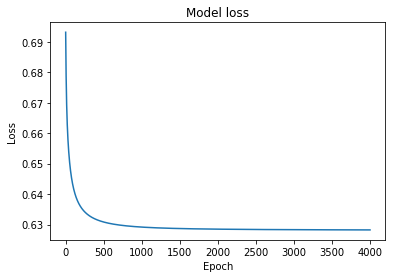

In [39]:
# Chosen model
# lr = 0.001

logreg_weights = training(np.zeros(101), x, y, 0.001, 4000)

In [213]:
# lr = 0.01

weights3 = training(np.zeros(101), x, y, 0.01, 100)

Epoch: 0 Cost: 0.693147180559945
Epoch: 1 Cost: 0.9397877933823741


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Epoch: 2 Cost: nan
Epoch: 3 Cost: 6.442298467549216
Epoch: 4 Cost: nan
Epoch: 5 Cost: 7.811008407912663
Epoch: 6 Cost: nan
Epoch: 7 Cost: 9.171547960905027
Epoch: 8 Cost: inf
Epoch: 9 Cost: 10.500122494110062
Epoch: 10 Cost: 2.6050708088526684
Epoch: 11 Cost: 11.446545467104507
Epoch: 12 Cost: 1.5780168408316475
Epoch: 13 Cost: 9.160845996272894
Epoch: 14 Cost: inf
Epoch: 15 Cost: 10.497572841471808
Epoch: 16 Cost: 2.321861171596663
Epoch: 17 Cost: 10.384730464384983
Epoch: 18 Cost: 2.3603846828615374
Epoch: 19 Cost: 10.054774509174493
Epoch: 20 Cost: inf
Epoch: 21 Cost: 10.097249690549575
Epoch: 22 Cost: 2.509979685483847
Epoch: 23 Cost: 9.567723321516516
Epoch: 24 Cost: inf
Epoch: 25 Cost: 9.874372831669108
Epoch: 26 Cost: inf
Epoch: 27 Cost: 9.029772297715127
Epoch: 28 Cost: inf
Epoch: 29 Cost: 9.638857290092519
Epoch: 30 Cost: inf
Epoch: 31 Cost: 8.575669986065765
Epoch: 32 Cost: nan
Epoch: 33 Cost: 9.334587314642272
Epoch: 34 Cost: nan
Epoch: 35 Cost: 8.306540767697392
Epoch: 36 C

array([ 0.00000000e+00,  1.96138807e-02, -3.23560371e-03, -1.19702007e-03,
        1.09507381e-02, -3.59948098e-04, -6.13316256e-03,  5.03944681e-03,
       -4.74591268e-03,  3.85098881e-03, -8.31247519e-03,  1.48958761e-02,
       -1.35622637e-02,  4.03518674e-03, -1.49416079e-02, -9.78890502e-03,
        1.43943747e-02, -9.16564950e-03,  6.79724954e-03, -5.64698907e-03,
       -1.29024447e-03, -1.16014159e-02, -2.34618892e-02,  4.55049479e-04,
        3.62795216e-03, -5.91076474e-03, -3.61276613e-02, -1.43325666e-03,
        2.54354063e-03,  1.19244552e-02,  5.75471815e-03,  9.27922808e-02,
        3.71092123e-03, -1.27139119e-02, -6.14939962e-03, -1.39199689e-03,
        5.75337035e-05, -2.18975089e-03,  7.77400033e-03, -2.23919454e-04,
        1.47194386e-02, -4.27380396e-03, -2.40950106e-02,  5.84366887e-03,
        3.09866461e-02,  7.28156591e-03,  1.38993021e-02, -1.43847776e-03,
        1.51975197e-02,  8.31613122e-03, -2.61942153e-02, -1.10867761e-01,
        8.09161130e-02, -

In [243]:
# lr = 0.1

weights4 = training(np.zeros(101), x, y, 0.1, 100)

Epoch: 0 Cost: 0.693147180559945
Epoch: 1 Cost: 6.801868893840957


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Epoch: 2 Cost: nan
Epoch: 3 Cost: 22.273873718903864
Epoch: 4 Cost: nan
Epoch: 5 Cost: 35.89056296888199
Epoch: 6 Cost: nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Epoch: 7 Cost: nan
Epoch: 8 Cost: nan
Epoch: 9 Cost: nan
Epoch: 10 Cost: nan
Epoch: 11 Cost: nan
Epoch: 12 Cost: nan
Epoch: 13 Cost: nan
Epoch: 14 Cost: nan
Epoch: 15 Cost: nan
Epoch: 16 Cost: nan
Epoch: 17 Cost: nan
Epoch: 18 Cost: nan
Epoch: 19 Cost: nan
Epoch: 20 Cost: nan
Epoch: 21 Cost: nan
Epoch: 22 Cost: nan
Epoch: 23 Cost: nan
Epoch: 24 Cost: nan
Epoch: 25 Cost: nan
Epoch: 26 Cost: nan
Epoch: 27 Cost: nan
Epoch: 28 Cost: nan
Epoch: 29 Cost: nan
Epoch: 30 Cost: nan
Epoch: 31 Cost: nan
Epoch: 32 Cost: nan
Epoch: 33 Cost: nan
Epoch: 34 Cost: nan
Epoch: 35 Cost: nan
Epoch: 36 Cost: nan
Epoch: 37 Cost: nan
Epoch: 38 Cost: nan
Epoch: 39 Cost: nan
Epoch: 40 Cost: nan
Epoch: 41 Cost: nan
Epoch: 42 Cost: nan
Epoch: 43 Cost: nan
Epoch: 44 Cost: nan
Epoch: 45 Cost: nan
Epoch: 46 Cost: nan
Epoch: 47 Cost: nan
Epoch: 48 Cost: nan
Epoch: 49 Cost: nan
Epoch: 50 Cost: nan
Epoch: 51 Cost: nan
Epoch: 52 Cost: nan
Epoch: 53 Cost: nan
Epoch: 54 Cost: nan
Epoch: 55 Cost: nan
Epoch: 56 Cost: nan
Epo

array([ 0.00000000e+00,  1.47346448e-01, -2.35822220e-03, -1.15778232e-02,
        1.07664080e-01,  9.36633420e-03, -5.18338695e-02,  2.07874790e-03,
       -3.00610594e-02,  9.06545577e-03, -6.76671575e-02,  1.22012982e-01,
       -1.14432380e-01, -2.86704746e-02, -1.28634591e-01, -3.86757643e-02,
        9.42676099e-02, -1.02387369e-01,  4.89109511e-02, -1.21428560e-01,
       -2.67454130e-02, -9.35429078e-02, -1.97452329e-01,  2.77990735e-02,
        1.62675349e-02, -6.97549623e-02, -3.98827220e-01, -4.35431452e-02,
        6.44786817e-03,  9.35934309e-02,  3.30606229e-02,  9.73581680e-01,
        3.82201171e-02, -1.31724089e-01, -6.42250344e-02,  6.15190616e-03,
        4.52041647e-03,  2.53176075e-02,  8.49781975e-02, -1.15046422e-02,
        9.10908034e-02, -3.43276915e-02, -2.18838067e-01,  1.29739327e-02,
        2.68622378e-01,  4.56381036e-02,  1.23773256e-01, -1.67055855e-02,
        1.08103149e-01,  6.59747167e-02, -2.25426632e-01, -1.10799180e+00,
        7.92981970e-01, -

In [166]:
# Create list conataining first 10 verifiable claims from development subset

dev_claim_IDs = [137334, 111897, 89891, 181634, 219028, 108281, 204361, 54168, 105095, 18708]

dev_claims = [claim for claim in dev_data if claim['id'] in dev_claim_IDs]

In [172]:
# Tokenize claims

dev_claims_terms_sw = []

for claim in dev_claims:
    terms2 = re.findall(r'\b\w+\b', claim['claim'].lower())
    terms2 = [ps.stem(token) for token in terms2 if token not in stopwords and token != 'LRB' and token != 'RRB' and token != 'LSB' and token != 'RSB']
    dev_claims_terms_sw.append(terms2)

# Flatten lists

all_dev_claims_terms_sw = [item for sublist in dev_claims_terms_sw for item in sublist]

# Remove duplicates of words

dev_claims_words_sw = list(set(all_dev_claims_terms_sw))

# Create inverted index

dev_inverted_index_sw = {}
dev_document_number_sw = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB' and term != 'RSB']
            
            for word in dev_claims_words_sw:
                if word in set(tokens):
                    try:
                        dev_inverted_index_sw[word].add((dev_document_number_sw, tokens.count(word), len(tokens)))
                    except KeyError:
                        dev_inverted_index_sw[word] = set()
                        dev_inverted_index_sw[word].add((dev_document_number_sw, tokens.count(word), len(tokens)))
                      
            dev_document_number_sw += 1

In [173]:
# Create inverted index for development claims

dev_inverted_index_claims_sw = {}

for index, text in tqdm(enumerate(dev_claims_terms_sw)):
    for word in dev_claims_words_sw:
        if word in set(text):
            try:
                dev_inverted_index_claims_sw[word].add((index, text.count(word), len(text)))
            except KeyError:
                dev_inverted_index_claims_sw[word] = set()
                dev_inverted_index_claims_sw[word].add((index, text.count(word), len(text)))

In [174]:
# Define IDF Function

def dev_IDF_sw(word):
    
    N = len(document_IDs)
    
    n_t = len(dev_inverted_index_sw[word])
    
    return math.log10(N / n_t)

In [178]:
# Create IDF vector for relevant words

dev_words_IDFs_sw = []

for word in dev_claims_words_sw:
    dev_words_IDFs_sw.append(dev_IDF_sw(word))

In [179]:
# Development claims TF-IDF representation

dev_claims_TFs_sw = np.zeros((len(dev_claims), len(dev_claims_words_sw)))

for index, word in tqdm(enumerate(dev_claims_words_sw)):
    for value in dev_inverted_index_claims_sw[word]:
        dev_claims_TFs_sw[value[0]][index] = value[1] / value[2]
        
dev_claims_TFIDFs_sw = np.zeros((len(dev_claims), len(dev_claims_words_sw)))

for i in trange(len(dev_claims_TFs_sw)):
    for index, TF in enumerate(dev_claims_TFs_sw[i]):
        dev_claims_TFIDFs_sw[i][index] = TF * dev_words_IDFs_sw[index]        



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 2998.72it/s]

In [180]:
# Development documents TF-IDF representations

dev_documents_TFs_sw = np.zeros((len(document_IDs), len(dev_claims_words_sw))) 

for index, word in tqdm(enumerate(dev_claims_words_sw)):
    for value in tqdm(dev_inverted_index_sw[word]):
        dev_documents_TFs_sw[value[0]][index] = value[1] / value[2]
        
dev_documents_TFIDFs_sw = np.zeros((len(document_IDs), len(dev_claims_words_sw))) 

for i in trange(len(dev_documents_TFs_sw)):
    for index, TF in enumerate(dev_documents_TFs_sw[i]):
        dev_documents_TFIDFs_sw[i][index] = TF * dev_words_IDFs_sw[index]



  0%|          | 0/5416537 [00:00<?, ?it/s]

  0%|          | 2248/5416537 [00:00<04:00, 22473.97it/s]

  0%|          | 4294/5416537 [00:00<04:07, 21828.30it/s]

  0%|          | 6131/5416537 [00:00<04:21, 20661.32it/s]

  0%|          | 7846/5416537 [00:00<04:37, 19465.50it/s]

  0%|          | 9899/5416537 [00:00<04:33, 19772.49it/s]

  0%|          | 12035/5416537 [00:00<04:27, 20222.70it/s]

  0%|          | 14030/5416537 [00:00<04:28, 20138.17it/s]

  0%|          | 16003/5416537 [00:00<04:29, 20012.90it/s]

  0%|          | 17883/5416537 [00:00<05:00, 17938.09it/s]

  0%|          | 19788/5416537 [00:01<04:55, 18256.75it/s]

  0%|          | 21707/5416537 [00:01<04:51, 18525.98it/s]

  0%|          | 23540/5416537 [00:01<05:01, 17913.48it/s]

  0%|          | 25322/5416537 [00:01<05:48, 15491.43it/s]

  1%|          | 27350/5416537 [00:01<05:23, 16671.18it/s]

  1%|          | 29456/5416537 [00:01<05:02, 17780.11it/s]

  1%|          | 31403/5416537 [00:01<04:54, 18254.99it/s]

  9%|▉         | 476371/5416537 [00:26<04:05, 20137.11it/s]

  9%|▉         | 478772/5416537 [00:26<03:53, 21159.34it/s]

  9%|▉         | 480950/5416537 [00:26<03:51, 21322.05it/s]

  9%|▉         | 483226/5416537 [00:26<03:46, 21733.57it/s]

  9%|▉         | 485641/5416537 [00:26<03:40, 22406.08it/s]

  9%|▉         | 487930/5416537 [00:26<03:38, 22547.89it/s]

  9%|▉         | 490205/5416537 [00:26<03:41, 22240.03it/s]

  9%|▉         | 492724/5416537 [00:27<03:33, 23049.76it/s]

  9%|▉         | 495132/5416537 [00:27<03:30, 23347.50it/s]

  9%|▉         | 497683/5416537 [00:27<03:25, 23955.33it/s]

  9%|▉         | 500245/5416537 [00:27<03:21, 24431.07it/s]

  9%|▉         | 502818/5416537 [00:27<03:18, 24805.70it/s]

  9%|▉         | 505458/5416537 [00:27<03:14, 25260.93it/s]

  9%|▉         | 507993/5416537 [00:27<03:15, 25149.55it/s]

  9%|▉         | 510588/5416537 [00:27<03:13, 25382.73it/s]

  9%|▉         | 513184/5416537 [00:27<03:11, 25552.36it/s]

 10%|▉         | 515743/

 19%|█▉        | 1028005/5416537 [00:51<04:05, 17877.89it/s]

 19%|█▉        | 1029800/5416537 [00:52<04:17, 17065.10it/s]

 19%|█▉        | 1031613/5416537 [00:52<04:12, 17370.79it/s]

 19%|█▉        | 1033381/5416537 [00:52<04:11, 17460.97it/s]

 19%|█▉        | 1035135/5416537 [00:52<04:11, 17421.93it/s]

 19%|█▉        | 1036919/5416537 [00:52<04:09, 17542.27it/s]

 19%|█▉        | 1038677/5416537 [00:52<04:16, 17091.08it/s]

 19%|█▉        | 1040414/5416537 [00:52<04:14, 17172.43it/s]

 19%|█▉        | 1042135/5416537 [00:52<04:41, 15543.24it/s]

 19%|█▉        | 1044028/5416537 [00:52<04:26, 16424.77it/s]

 19%|█▉        | 1045707/5416537 [00:53<04:41, 15545.35it/s]

 19%|█▉        | 1047682/5416537 [00:53<04:23, 16605.16it/s]

 19%|█▉        | 1049388/5416537 [00:53<04:21, 16676.21it/s]

 19%|█▉        | 1051104/5416537 [00:53<04:19, 16816.04it/s]

 19%|█▉        | 1052883/5416537 [00:53<04:15, 17096.63it/s]

 19%|█▉        | 1054610/5416537 [00:53<04:17, 16963.24it/s]

 20%|█▉ 

 27%|██▋       | 1464690/5416537 [01:18<03:35, 18356.30it/s]

 27%|██▋       | 1466541/5416537 [01:18<03:41, 17872.00it/s]

 27%|██▋       | 1468739/5416537 [01:18<03:28, 18932.16it/s]

 27%|██▋       | 1470659/5416537 [01:19<03:36, 18254.56it/s]

 27%|██▋       | 1472509/5416537 [01:19<03:35, 18266.32it/s]

 27%|██▋       | 1474928/5416537 [01:19<03:19, 19714.15it/s]

 27%|██▋       | 1477055/5416537 [01:19<03:15, 20155.51it/s]

 27%|██▋       | 1479383/5416537 [01:19<03:07, 20999.50it/s]

 27%|██▋       | 1481627/5416537 [01:19<03:03, 21411.07it/s]

 27%|██▋       | 1483793/5416537 [01:19<03:03, 21441.04it/s]

 27%|██▋       | 1486101/5416537 [01:19<02:59, 21906.55it/s]

 27%|██▋       | 1488487/5416537 [01:19<02:54, 22457.09it/s]

 28%|██▊       | 1490747/5416537 [01:19<03:03, 21372.71it/s]

 28%|██▊       | 1492905/5416537 [01:20<03:17, 19893.48it/s]

 28%|██▊       | 1495159/5416537 [01:20<03:10, 20619.29it/s]

 28%|██▊       | 1497381/5416537 [01:20<03:05, 21074.53it/s]

 28%|██▊

 36%|███▌      | 1938450/5416537 [01:45<03:22, 17161.72it/s]

 36%|███▌      | 1940201/5416537 [01:45<03:27, 16717.58it/s]

 36%|███▌      | 1941900/5416537 [01:45<03:32, 16377.59it/s]

 36%|███▌      | 1943990/5416537 [01:45<03:18, 17513.19it/s]

 36%|███▌      | 1946131/5416537 [01:45<03:07, 18523.77it/s]

 36%|███▌      | 1948359/5416537 [01:45<02:57, 19509.63it/s]

 36%|███▌      | 1950514/5416537 [01:45<02:52, 20079.27it/s]

 36%|███▌      | 1952556/5416537 [01:46<03:02, 18948.32it/s]

 36%|███▌      | 1954706/5416537 [01:46<02:56, 19644.65it/s]

 36%|███▌      | 1957056/5416537 [01:46<02:47, 20661.49it/s]

 36%|███▌      | 1959255/5416537 [01:46<02:44, 21042.57it/s]

 36%|███▌      | 1961515/5416537 [01:46<02:40, 21485.24it/s]

 36%|███▋      | 1963685/5416537 [01:46<02:54, 19764.20it/s]

 36%|███▋      | 1965704/5416537 [01:46<02:57, 19430.05it/s]

 36%|███▋      | 1967678/5416537 [01:46<03:06, 18538.89it/s]

 36%|███▋      | 1969563/5416537 [01:47<03:52, 14819.33it/s]

 36%|███

 45%|████▍     | 2415329/5416537 [02:11<02:16, 21944.37it/s]

 45%|████▍     | 2417565/5416537 [02:11<02:15, 22064.62it/s]

 45%|████▍     | 2419775/5416537 [02:11<02:21, 21216.18it/s]

 45%|████▍     | 2421906/5416537 [02:11<02:36, 19120.46it/s]

 45%|████▍     | 2424117/5416537 [02:11<02:30, 19927.34it/s]

 45%|████▍     | 2426548/5416537 [02:11<02:21, 21065.52it/s]

 45%|████▍     | 2428807/5416537 [02:11<02:18, 21500.45it/s]

 45%|████▍     | 2431164/5416537 [02:11<02:15, 22080.26it/s]

 45%|████▍     | 2433592/5416537 [02:11<02:11, 22695.90it/s]

 45%|████▍     | 2435886/5416537 [02:12<02:12, 22563.46it/s]

 45%|████▌     | 2438173/5416537 [02:12<02:11, 22653.28it/s]

 45%|████▌     | 2440463/5416537 [02:12<02:10, 22724.92it/s]

 45%|████▌     | 2442786/5416537 [02:12<02:10, 22873.98it/s]

 45%|████▌     | 2445142/5416537 [02:12<02:08, 23073.78it/s]

 45%|████▌     | 2447455/5416537 [02:12<02:12, 22427.61it/s]

 45%|████▌     | 2449805/5416537 [02:12<02:10, 22738.11it/s]

 45%|███

 54%|█████▍    | 2927238/5416537 [02:36<02:51, 14484.10it/s]

 54%|█████▍    | 2928887/5416537 [02:36<02:45, 15023.48it/s]

 54%|█████▍    | 2930434/5416537 [02:36<02:46, 14950.71it/s]

 54%|█████▍    | 2931960/5416537 [02:36<02:49, 14688.35it/s]

 54%|█████▍    | 2933485/5416537 [02:37<02:47, 14852.01it/s]

 54%|█████▍    | 2935289/5416537 [02:37<02:38, 15681.72it/s]

 54%|█████▍    | 2937133/5416537 [02:37<02:31, 16415.86it/s]

 54%|█████▍    | 2938959/5416537 [02:37<02:26, 16928.10it/s]

 54%|█████▍    | 2940674/5416537 [02:37<02:25, 16986.45it/s]

 54%|█████▍    | 2942389/5416537 [02:37<03:11, 12933.19it/s]

 54%|█████▍    | 2943839/5416537 [02:37<03:28, 11849.14it/s]

 54%|█████▍    | 2945414/5416537 [02:37<03:13, 12799.94it/s]

 54%|█████▍    | 2947206/5416537 [02:37<02:56, 13999.33it/s]

 54%|█████▍    | 2948756/5416537 [02:38<02:51, 14417.38it/s]

 54%|█████▍    | 2950552/5416537 [02:38<02:41, 15314.00it/s]

 55%|█████▍    | 2952227/5416537 [02:38<02:36, 15716.93it/s]

 55%|███

 63%|██████▎   | 3406107/5416537 [03:02<01:56, 17219.13it/s]

 63%|██████▎   | 3408319/5416537 [03:02<01:48, 18443.93it/s]

 63%|██████▎   | 3410619/5416537 [03:02<01:42, 19608.64it/s]

 63%|██████▎   | 3412967/5416537 [03:03<01:37, 20611.28it/s]

 63%|██████▎   | 3415155/5416537 [03:03<01:35, 20894.87it/s]

 63%|██████▎   | 3417293/5416537 [03:03<01:36, 20822.51it/s]

 63%|██████▎   | 3419515/5416537 [03:03<01:34, 21222.88it/s]

 63%|██████▎   | 3421788/5416537 [03:03<01:32, 21649.45it/s]

 63%|██████▎   | 3423973/5416537 [03:03<01:31, 21664.08it/s]

 63%|██████▎   | 3426163/5416537 [03:03<01:31, 21732.89it/s]

 63%|██████▎   | 3428347/5416537 [03:03<01:35, 20894.72it/s]

 63%|██████▎   | 3430696/5416537 [03:03<01:31, 21609.65it/s]

 63%|██████▎   | 3432873/5416537 [03:04<01:32, 21393.51it/s]

 63%|██████▎   | 3435182/5416537 [03:04<01:30, 21873.69it/s]

 63%|██████▎   | 3437473/5416537 [03:04<01:29, 22171.73it/s]

 64%|██████▎   | 3439699/5416537 [03:04<01:29, 22025.43it/s]

 64%|███

 72%|███████▏  | 3898311/5416537 [03:28<01:26, 17584.57it/s]

 72%|███████▏  | 3900279/5416537 [03:28<01:23, 18164.80it/s]

 72%|███████▏  | 3902293/5416537 [03:28<01:20, 18713.67it/s]

 72%|███████▏  | 3904182/5416537 [03:29<01:22, 18437.03it/s]

 72%|███████▏  | 3906130/5416537 [03:29<01:20, 18730.53it/s]

 72%|███████▏  | 3908014/5416537 [03:29<01:20, 18692.81it/s]

 72%|███████▏  | 3909891/5416537 [03:29<01:20, 18625.86it/s]

 72%|███████▏  | 3911872/5416537 [03:29<01:19, 18965.43it/s]

 72%|███████▏  | 3913876/5416537 [03:29<01:17, 19275.27it/s]

 72%|███████▏  | 3915874/5416537 [03:29<01:17, 19479.20it/s]

 72%|███████▏  | 3917826/5416537 [03:29<01:18, 19184.58it/s]

 72%|███████▏  | 3919749/5416537 [03:29<01:18, 19020.39it/s]

 72%|███████▏  | 3921654/5416537 [03:30<01:20, 18619.49it/s]

 72%|███████▏  | 3923520/5416537 [03:30<01:23, 17915.42it/s]

 72%|███████▏  | 3925402/5416537 [03:30<01:22, 18177.36it/s]

 73%|███████▎  | 3927420/5416537 [03:30<01:19, 18734.21it/s]

 73%|███

 82%|████████▏ | 4418535/5416537 [03:54<00:43, 22736.52it/s]

 82%|████████▏ | 4420857/5416537 [03:54<00:43, 22877.07it/s]

 82%|████████▏ | 4423147/5416537 [03:54<00:43, 22748.85it/s]

 82%|████████▏ | 4425424/5416537 [03:54<00:51, 19287.55it/s]

 82%|████████▏ | 4427445/5416537 [03:54<01:15, 13089.49it/s]

 82%|████████▏ | 4429719/5416537 [03:54<01:05, 14997.23it/s]

 82%|████████▏ | 4431578/5416537 [03:55<01:01, 15919.67it/s]

 82%|████████▏ | 4433416/5416537 [03:55<01:00, 16327.14it/s]

 82%|████████▏ | 4435224/5416537 [03:55<01:00, 16352.11it/s]

 82%|████████▏ | 4437211/5416537 [03:55<00:56, 17269.08it/s]

 82%|████████▏ | 4439515/5416537 [03:55<00:52, 18671.28it/s]

 82%|████████▏ | 4441839/5416537 [03:55<00:49, 19841.05it/s]

 82%|████████▏ | 4443915/5416537 [03:55<00:56, 17171.51it/s]

 82%|████████▏ | 4446215/5416537 [03:55<00:52, 18582.97it/s]

 82%|████████▏ | 4448197/5416537 [03:56<01:06, 14455.44it/s]

 82%|████████▏ | 4450413/5416537 [03:56<00:59, 16137.72it/s]

 82%|███

 91%|█████████ | 4916331/5416537 [04:20<00:30, 16599.53it/s]

 91%|█████████ | 4918065/5416537 [04:20<00:29, 16808.59it/s]

 91%|█████████ | 4919755/5416537 [04:20<00:30, 16251.48it/s]

 91%|█████████ | 4921390/5416537 [04:20<00:30, 16113.48it/s]

 91%|█████████ | 4923009/5416537 [04:20<00:31, 15450.42it/s]

 91%|█████████ | 4924811/5416537 [04:20<00:30, 16138.19it/s]

 91%|█████████ | 4926441/5416537 [04:20<00:30, 16063.02it/s]

 91%|█████████ | 4928059/5416537 [04:21<00:30, 16075.96it/s]

 91%|█████████ | 4929675/5416537 [04:21<00:30, 15723.54it/s]

 91%|█████████ | 4931255/5416537 [04:21<00:33, 14453.03it/s]

 91%|█████████ | 4932726/5416537 [04:21<00:34, 13895.86it/s]

 91%|█████████ | 4934308/5416537 [04:21<00:33, 14421.22it/s]

 91%|█████████ | 4935970/5416537 [04:21<00:32, 15016.52it/s]

 91%|█████████ | 4937728/5416537 [04:21<00:30, 15702.75it/s]

 91%|█████████ | 4939329/5416537 [04:21<00:30, 15790.46it/s]

 91%|█████████ | 4940927/5416537 [04:21<00:30, 15846.71it/s]

 91%|███

 99%|█████████▊| 5341908/5416537 [04:49<00:06, 11251.24it/s]

 99%|█████████▊| 5343247/5416537 [04:49<00:06, 10782.14it/s]

 99%|█████████▊| 5344712/5416537 [04:49<00:06, 11709.55it/s]

 99%|█████████▊| 5346459/5416537 [04:50<00:05, 12993.02it/s]

 99%|█████████▊| 5348051/5416537 [04:50<00:04, 13750.01it/s]

 99%|█████████▉| 5349533/5416537 [04:50<00:04, 13758.62it/s]

 99%|█████████▉| 5350986/5416537 [04:50<00:04, 13980.44it/s]

 99%|█████████▉| 5352438/5416537 [04:50<00:04, 13195.86it/s]

 99%|█████████▉| 5353994/5416537 [04:50<00:04, 13790.42it/s]

 99%|█████████▉| 5355605/5416537 [04:50<00:04, 14412.88it/s]

 99%|█████████▉| 5357082/5416537 [04:50<00:05, 11890.11it/s]

 99%|█████████▉| 5358729/5416537 [04:50<00:04, 12972.07it/s]

 99%|█████████▉| 5360978/5416537 [04:51<00:03, 14857.96it/s]

 99%|█████████▉| 5363027/5416537 [04:51<00:03, 16192.23it/s]

 99%|█████████▉| 5364958/5416537 [04:51<00:03, 16989.07it/s]

 99%|█████████▉| 5366773/5416537 [04:51<00:02, 17229.60it/s]

 99%|███

In [182]:
# Cosine similarity function

def cossim(v1, v2):
    if np.linalg.norm(v2) != 0:
        return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    else:
        return 0

# Create cosine similarity matrix for the 10 claims
    
dev_cossim_matrix_sw = np.zeros((len(dev_claims), len(document_IDs))) 
    
for index in trange(len(dev_claims_TFIDFs_sw)):    
    dev_cossim_claim_sw = []
    for dev_document_TFIDF_sw in dev_documents_TFIDFs_sw:
        dev_cossim_claim_sw.append(cossim(dev_claims_TFIDFs_sw[index], dev_document_TFIDF_sw))
    dev_cossim_matrix_sw[index] = dev_cossim_claim_sw
    
# IDs of 5 most similar documents

for i in trange(len(dev_cossim_matrix_sw)):
    print('CLAIM ', i+1, ' 5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)' )
    for index in reversed(list(np.argsort(dev_cossim_matrix_sw[i])[-5:])):
        print(document_IDs[index])



  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [01:27<13:04, 87.21s/it]



 20%|██        | 2/10 [02:51<11:31, 86.40s/it]



 30%|███       | 3/10 [04:15<09:59, 85.70s/it]



 40%|████      | 4/10 [05:37<08:27, 84.63s/it]



 50%|█████     | 5/10 [06:58<06:57, 83.52s/it]



 60%|██████    | 6/10 [08:20<05:32, 83.09s/it]



 70%|███████   | 7/10 [09:45<04:10, 83.55s/it]



 80%|████████  | 8/10 [11:08<02:46, 83.39s/it]



 90%|█████████ | 9/10 [12:30<01:23, 83.00s/it]



100%|██████████| 10/10 [13:52<00:00, 82.53s/it]



  0%|          | 0/10 [00:00<?, ?it/s]

CLAIM  1  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 10%|█         | 1/10 [00:00<00:04,  2.11it/s]

Kenji_Jasper
Soul_Food_-LRB-film-RRB-
Vanessa_A._Williams
Ambaji_Shinde
Chronicles_of_Ancient_Darkness
CLAIM  2  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 20%|██        | 2/10 [00:00<00:03,  2.29it/s]

Flor_Salvaje
El_rostro_de_la_venganza
Tierra_de_reyes
La_impostora
Noticiero_Univision
CLAIM  3  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 30%|███       | 3/10 [00:01<00:02,  2.40it/s]

Kwes
Heavy_Seas_of_Love
Hollow_Ponds
Jeff_Wootton
Daley_-LRB-musician-RRB-
CLAIM  4  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 40%|████      | 4/10 [00:01<00:02,  2.60it/s]

Abdi_Bashir_Indhobuur
United_Nations_Security_Council_Resolution_865
K50_Airstrip
FIBA_Africa_Championship_1981
History_of_Mogadishu
CLAIM  5  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 50%|█████     | 5/10 [00:01<00:01,  2.72it/s]

Wakaya_Island
International_Heritage_Inc.
List_of_WWE_Intercontinental_Champions
Sir_Robert_Cordell,_1st_Baronet
Holeg_Spies
CLAIM  6  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 60%|██████    | 6/10 [00:02<00:01,  2.69it/s]

The_Hire-COLON-_The_Follow
Andrew_Kevin_Walker
Don_Schlesinger
Casson_invariant
Bongani_Ndodana-Breen
CLAIM  7  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 70%|███████   | 7/10 [00:02<00:01,  2.66it/s]

Tin_Bider_crater
Aokiichthys
Mahamba
Andesaurus
Lectavis
CLAIM  8  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 80%|████████  | 8/10 [00:03<00:00,  2.38it/s]

Murda_Beatz
No_Shopping
No_Frauds
Flexin_On_Purpose
Rich_Than_Famous
CLAIM  9  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




 90%|█████████ | 9/10 [00:03<00:00,  2.40it/s]

Damian_Lewis
List_of_Homeland_episodes
The_Weekend_-LRB-Homeland-RRB-
Pilot_-LRB-Homeland-RRB-
Carrie_Mathison
CLAIM  10  5 MOST RELEVANT DOCUMENTS (FROM MOST TO LEAST, no sw)




100%|██████████| 10/10 [00:03<00:00,  2.45it/s]



Dary_Matera
Roger_Keith_Coleman
Basil_Banghart
Judicial_system_of_post-Napoleonic_France
Direct_evidence


In [183]:
# Retrieve indices of 5 most relevant documents for each claim

dev_doc_indices = []

for i in trange(len(dev_cossim_matrix_sw)):
    claim_doc_indices = []
    for index in reversed(list(np.argsort(dev_cossim_matrix_sw[i])[-5:])):
        claim_doc_indices.append(index)
    dev_doc_indices.append(claim_doc_indices)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:03,  2.65it/s]

 20%|██        | 2/10 [00:00<00:03,  2.61it/s]

 30%|███       | 3/10 [00:01<00:02,  2.44it/s]

 40%|████      | 4/10 [00:01<00:02,  2.52it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.30it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.38it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.51it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.41it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.52it/s]

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]



In [184]:
# Retrieve the 5 most relevant documents for each claim

dev_docs = []

for i in tqdm(dev_doc_indices):
    for index in i:
        for file in tqdm(os.listdir(path = 'wiki-pages')): 
            with open('wiki-pages/' + file,'r') as openfile:
                for line in openfile.readlines():
                    if json.loads(line)['id'] == document_IDs[index]:
                        dev_docs.append(json.loads(line))

In [217]:
# Split the documents for each of the 10 claims

dev_docs_chunks = [dev_docs[x:x+5] for x in range(0, len(dev_docs), 5)]

In [238]:
# Split the documents into lines

dev_doc_lines = []

for claim_docs in dev_docs_chunks:
    doc_sentences = []
    for doc in claim_docs:
        sentences = []
        for i in range(len(doc['lines'].split('\n'))):
            sentences.append(doc['lines'].split('\n')[i][2:].split('\t')[0])  
        doc_sentences.append(sentences)
    dev_doc_lines.append(doc_sentences)

In [239]:
# Tokenize each line

# Resulting in list of length 10 (10 claims)
# each containing a list of length 5 (5 relevant documents)
# each containing a list of length of the number of lines
# each containing a list of the tokenized words

for i in trange(len(dev_doc_lines)):
    for j in trange(len(dev_doc_lines[i])):
        for k in trange(len(dev_doc_lines[i][j])):
            dev_doc_lines[i][j][k] = [term for term in re.findall(r'\b\w+\b', dev_doc_lines[i][j][k].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']  



  0%|          | 0/10 [00:00<?, ?it/s]


  0%|          | 0/5 [00:00<?, ?it/s]



  0%|          | 0/26 [00:00<?, ?it/s]



100%|██████████| 26/26 [00:00<00:00, 24672.38it/s]



  0%|          | 0/9 [00:00<?, ?it/s]



100%|██████████| 9/9 [00:00<00:00, 7322.74it/s]



  0%|          | 0/4 [00:00<?, ?it/s]



100%|██████████| 4/4 [00:00<00:00, 3824.30it/s]



  0%|          | 0/40 [00:00<?, ?it/s]



100%|██████████| 40/40 [00:00<00:00, 36559.63it/s]



  0%|          | 0/20 [00:00<?, ?it/s]



100%|██████████| 20/20 [00:00<00:00, 14398.57it/s]


100%|██████████| 5/5 [00:00<00:00, 176.47it/s]


  0%|          | 0/5 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]



100%|██████████| 2/2 [00:00<00:00, 1776.12it/s]



  0%|          | 0/3 [00:00<?, ?it/s]



100%|██████████| 3/3 [00:00<00:00, 3027.65it/s]



  0%|          | 0/5 [00:00<?, ?it/s]



100%|██████████| 5/5 [00:00<00:00, 5747.20it/s]



  0%|          | 0/8 [00:00<?, ?it/s]



100%|██████████| 8/8 [00:00<00:00, 664

In [241]:
# Vectorize sentences

for i in trange(len(dev_doc_lines)):
    for j in trange(len(dev_doc_lines[i])):
        for k in trange(len(dev_doc_lines[i][j])):
            summed = np.zeros(50)
            for l in range(len(dev_doc_lines[i][j][k])):
                try:
                    summed += word_vector(dev_doc_lines[i][j][k][l])
                except KeyError:
                    summed += unknown_vec
            dev_doc_lines[i][j][k] = summed



  0%|          | 0/10 [00:00<?, ?it/s]


  0%|          | 0/5 [00:00<?, ?it/s]



  0%|          | 0/26 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.




  8%|▊         | 2/26 [00:00<00:03,  7.62it/s]



 12%|█▏        | 3/26 [00:00<00:03,  6.03it/s]



 15%|█▌        | 4/26 [00:00<00:03,  6.66it/s]



 19%|█▉        | 5/26 [00:00<00:03,  6.51it/s]



 23%|██▎       | 6/26 [00:01<00:03,  5.47it/s]



 35%|███▍      | 9/26 [00:01<00:02,  7.22it/s]



 42%|████▏     | 11/26 [00:01<00:01,  8.58it/s]



100%|██████████| 26/26 [00:01<00:00, 20.21it/s]


 20%|██        | 1/5 [00:01<00:05,  1.29s/it]



  0%|          | 0/9 [00:00<?, ?it/s]



 11%|█         | 1/9 [00:00<00:01,  4.88it/s]



 22%|██▏       | 2/9 [00:00<00:01,  4.78it/s]



 33%|███▎      | 3/9 [00:00<00:01,  4.26it/s]



 67%|██████▋   | 6/9 [00:0

 20%|██        | 1/5 [00:00<00:00,  9.05it/s]



 60%|██████    | 3/5 [00:00<00:00,  9.85it/s]



 80%|████████  | 4/5 [00:00<00:00,  7.64it/s]



100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


 40%|████      | 2/5 [00:00<00:01,  2.04it/s]



  0%|          | 0/3 [00:00<?, ?it/s]



 33%|███▎      | 1/3 [00:00<00:00,  6.10it/s]



 67%|██████▋   | 2/3 [00:00<00:00,  5.30it/s]



100%|██████████| 3/3 [00:00<00:00,  7.26it/s]


 60%|██████    | 3/5 [00:01<00:00,  2.13it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 17%|█▋        | 1/6 [00:00<00:00,  9.42it/s]



 33%|███▎      | 2/6 [00:00<00:00,  9.23it/s]



 50%|█████     | 3/6 [00:00<00:00,  8.59it/s]



 83%|████████▎ | 5/6 [00:00<00:00,  9.73it/s]



100%|██████████| 6/6 [00:00<00:00, 11.98it/s]


 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]



  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:00,  9.62it/s]



 60%|██████    | 3/5 [00:00<00:00,  9.40it/s]



 80%|████████  | 4/5 [00:00<00:00,  6.93it/s]



In [254]:
# Tokenize claims

dev_claims_terms = []

for claim in dev_claims:
    terms2 = re.findall(r'\b\w+\b', claim['claim'].lower())
    terms2 = [token for token in terms2 if token not in stopwords and token != 'lrb' and token != 'rrb' and token != 'lsb' and token != 'rsb'and token != 'lcb' and token != 'rcb']
    dev_claims_terms.append(terms2)

In [256]:
# Vectorize claims

for i in range(len(dev_claims_terms)):
    summed = np.zeros(50)
    for j in range(len(dev_claims_terms[i])):
        summed += word_vector(dev_claims_terms[i][j])
    dev_claims_terms[i] = summed

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [261]:
# Concatenate vector for claim and document sentence

for i in trange(len(dev_doc_lines)):
    for j in range(len(dev_doc_lines[i])):
        for k in range(len(dev_doc_lines[i][j])):
            dev_doc_lines[i][j][k] = np.concatenate((dev_claims_terms[i], dev_doc_lines[i][j][k]))



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 162.96it/s]

In [ ]:
# Add bias

for i in trange(len(dev_doc_lines)):
    for j in range(len(dev_doc_lines[i])):
        for k in range(len(dev_doc_lines[i][j])):
            dev_doc_lines[i][j][k] = np.concatenate((np.zeros(1), dev_doc_lines[i][j][k]))

In [301]:
# Calculate predictions
# Take weights from log reg model with learning rate = 0.001

predictions = []

for claim in dev_doc_lines:
    for doc in claim:
        for sentence in doc:
            prediction = sigmoid(np.matmul(sentence, logreg_weights))
            if prediction > 0.5:
                predictions.append(1)
            else:
                predictions.append(0)

In [307]:
# Obtain correct labels from evidence field
# Relevant sentences:
# Claim 1: Soul_Food_-LRB-film-RRB- sentence 0
# Claim 2: Telemundo sentences 0,1,4,5 Hispanic_and_Latino_Americans sentence 0
# Claim 3: Damon_Albarn sentence 17
# Claim 4: Mogadishu sentence 0
# Claim 5: Savages_-LRB-2012_film-RRB- sentences 2,3
# Claim 6: Andrew_Kevin_Walker sentence 0
# Claim 7: Cretaceous sentences 8,9
# Claim 8: Murda_Beatz sentence 0
# Claim 9: Nicholas_Brody sentences 1,4 Carrie_Mathison sentences 0,2
# Claim 10: Charles_Manson sentence 17

correct_scores = []

# Claim 1 retrieved docs  1-5

for i in range(len(dev_doc_lines[0][0])):
    correct_scores.append(0)
            
correct_scores.append(1)

for i in range(1, len(dev_doc_lines[0][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[0][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[0][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[0][4])):
    correct_scores.append(0)
    
# Claim 2 retrieved docs  1-5
    
for i in range(len(dev_doc_lines[1][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[1][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[1][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[1][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[1][4])):
    correct_scores.append(0)
    
# Claim 3 retrieved docs  1-5
    
for i in range(len(dev_doc_lines[2][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[2][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[2][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[2][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[2][4])):
    correct_scores.append(0)
    
# Claim 4 retrieved docs  1-5
    
for i in range(len(dev_doc_lines[3][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[3][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[3][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[3][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[3][4])):
    correct_scores.append(0)

# Claim 5 retrieved docs  1-5

for i in range(len(dev_doc_lines[4][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[4][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[4][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[4][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[4][4])):
    correct_scores.append(0)

# Claim 6 retrieved docs  1-5

for i in range(len(dev_doc_lines[5][0])):
    correct_scores.append(0)
    
correct_scores.append(1)

for i in range(1, len(dev_doc_lines[5][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[5][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[5][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[5][4])):
    correct_scores.append(0)

# Claim 7 retrieved docs  1-5

for i in range(len(dev_doc_lines[6][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[6][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[6][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[6][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[6][4])):
    correct_scores.append(0)

# Claim 8 retrieved docs  1-5

correct_scores.append(1)

for i in range(1, len(dev_doc_lines[7][0])):
    correct_scores.append(0)

for i in range(len(dev_doc_lines[7][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[7][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[7][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[7][4])):
    correct_scores.append(0)

# Claim 9 retrieved docs  1-5

for i in range(len(dev_doc_lines[8][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[8][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[8][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[8][3])):
    correct_scores.append(0)
    
correct_scores.append(1)

correct_scores.append(0)

correct_scores.append(1)
    
for i in range(3, len(dev_doc_lines[8][4])):
    correct_scores.append(0)

# Claim 10 retrieved docs  1-5

for i in range(len(dev_doc_lines[9][0])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[9][1])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[9][2])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[9][3])):
    correct_scores.append(0)
    
for i in range(len(dev_doc_lines[9][4])):
    correct_scores.append(0)

In [364]:
# Unbalanced proportion of relevant sentences

print(str(correct_scores.count(1) / len(correct_scores) * 100) + '%')

0.7564296520423601%


In [366]:
# Evaluation metric (accuracy)

correct_predictions = 0

for i in range(len(predictions)):
    if predictions[i] == correct_scores[i]:
        correct_predictions += 1
        
print(str(correct_predictions / len(predictions) * 100) + '%')

80.78668683812406%


In [393]:
# Recall/sensitiviy

true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for i in range(len(dev_predictions)):
    if predictions[i] == 1 and correct_scores[i] == 1:
        true_pos += 1
    elif predictions[i] == 1 and correct_scores[i] == 0:
        false_pos += 1
    elif predictions[i] == 0 and correct_scores[i] == 0:
        true_neg += 1
    else:
        false_neg += 1
        
recall = true_pos / (true_pos + false_neg)
print(recall)

0.8118835507476933


## Subtask 5: Relevance Evaluation

In [110]:
# Retrieve verifiable claims from development subset

ver_dev_data = [claim for claim in dev_data if claim['verifiable'] == 'VERIFIABLE']

In [317]:
# Create list of claims with evidence

dev_claim_and_evidence = []

for claim in ver_dev_data:
    dev_claim_and_evidence.append((claim['claim'], claim['evidence']))

In [348]:
# Development subset features and labels
# Only included evidence that does not require multiple sources to prove the claim

dev_relevant_pairs = []
dev_nonrelevant_pairs = []

dev_relevant_examples = 0
dev_nonrelevant_examples = 1


dev_features = []
dev_labels = []

for claim in tqdm(dev_claim_and_evidence):
    for evidence in claim[1][0]:
    
        sentences = []
   
        try:
         
            for i in range(len(document_lines[evidence[2]].split('\n'))):
                sentences.append(document_lines[evidence[2]].split('\n')[i][2:].split('\t')[0])           
      
            dev_features.append([claim[0], sentences[evidence[3]]])
        
            dev_labels.append(1)
      
            N = len(sentences)
      
            relevant_line_indices = []
        
            dev_relevant_examples += 1
      
            try:
        
                for evidence2 in [e for e in claim[1][0] if e[2] == evidence[2]]:
            
                    relevant_line_indices.append(evidence2[3])
        
                nonrelevant_line_index = random.sample([i for i in list(range(N)) if i not in relevant_line_indices and len(re.findall(r'\b\w+\b', sentences[i])) > 2], 1)[0]
                
                dev_features.append([claim[0], sentences[nonrelevant_line_index]])  
            
                dev_labels.append(0)
                
                dev_nonrelevant_examples += 1
        
            except ValueError:
                pass
        
        except KeyError:
            pass
        
dev_y = np.array(dev_labels)

In [349]:
# Check balance

print(dev_relevant_examples)
print(dev_nonrelevant_examples)
print(dev_relevant_examples / (dev_relevant_examples + dev_nonrelevant_examples) * 100, '%')

14937
14564
50.63218195993356 %


In [350]:
# Tokenize the claims and evidence

for i in trange(len(dev_features)):
    dev_features[i][0] = [term for term in re.findall(r'\b\w+\b', dev_features[i][0].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'] 
    dev_features[i][1] = [term for term in re.findall(r'\b\w+\b', dev_features[i][1].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'] 




  0%|          | 0/29500 [00:00<?, ?it/s]


 14%|█▍        | 4258/29500 [00:00<00:00, 42579.53it/s]


 29%|██▉       | 8496/29500 [00:00<00:00, 42517.93it/s]


 41%|████      | 12164/29500 [00:00<00:00, 40578.70it/s]


 54%|█████▍    | 15918/29500 [00:00<00:00, 39610.27it/s]


 66%|██████▋   | 19551/29500 [00:00<00:00, 38563.57it/s]


 77%|███████▋  | 22711/29500 [00:00<00:00, 34181.85it/s]


 87%|████████▋ | 25734/29500 [00:00<00:00, 32011.19it/s]


 99%|█████████▉| 29280/29500 [00:00<00:00, 32971.79it/s]


100%|██████████| 29500/29500 [00:00<00:00, 35215.27it/s]

In [351]:
# Create inputs

dev_x = np.empty((len(dev_y), 100))

for i in trange(len(dev_features)):
    
    concatenated = np.empty(0)
    
    for j in range(len(dev_features[i])):
        
        summed = np.zeros(50)
        
        for k in range(len(dev_features[i][j])):
            
            try:
                summed += word_vector(dev_features[i][j][k])
            except KeyError:
                summed += unknown_vec
                
        concatenated = np.concatenate((concatenated, summed))       
        
    dev_x[i] = concatenated  




  0%|          | 0/29500 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.



  0%|          | 1/29500 [00:00<1:59:44,  4.11it/s]


  0%|          | 2/29500 [00:00<2:07:28,  3.86it/s]


  0%|          | 3/29500 [00:00<2:01:29,  4.05it/s]


  0%|          | 4/29500 [00:01<2:05:17,  3.92it/s]


  0%|          | 6/29500 [00:01<1:50:27,  4.45it/s]


  0%|          | 7/29500 [00:01<2:00:38,  4.07it/s]


  0%|          | 8/29500 [00:01<1:43:52,  4.73it/s]


  0%|          | 9/29500 [00:01<1:36:48,  5.08it/s]


  0%|          | 10/29500 [00:02<1:29:21,  5.50it/s]


  0%|          | 11/29500 [00:02<1:28:46,  5.54it/s]


  0%|          | 12/29500 [00:02<2:07:17,  3.86it/s]


  0%|          | 13/29500 [00:02<2:05:49,  3.91it/s]


  0%|          | 14/29500 [00:03<1:46:14,  4.63it/s]


  0%|          | 15/29500 [00:03<1:5

  1%|          | 262/29500 [01:02<2:05:22,  3.89it/s]


  1%|          | 263/29500 [01:02<1:57:01,  4.16it/s]


  1%|          | 264/29500 [01:03<2:10:26,  3.74it/s]


  1%|          | 265/29500 [01:03<2:21:20,  3.45it/s]


  1%|          | 266/29500 [01:03<2:17:44,  3.54it/s]


  1%|          | 267/29500 [01:04<2:30:20,  3.24it/s]


  1%|          | 268/29500 [01:04<2:18:09,  3.53it/s]


  1%|          | 269/29500 [01:04<2:05:19,  3.89it/s]


  1%|          | 271/29500 [01:04<1:50:01,  4.43it/s]


  1%|          | 272/29500 [01:05<2:21:25,  3.44it/s]


  1%|          | 273/29500 [01:05<2:44:59,  2.95it/s]


  1%|          | 274/29500 [01:05<2:27:03,  3.31it/s]


  1%|          | 275/29500 [01:06<2:12:41,  3.67it/s]


  1%|          | 276/29500 [01:06<2:02:04,  3.99it/s]


  1%|          | 277/29500 [01:06<2:03:50,  3.93it/s]


  1%|          | 278/29500 [01:06<1:52:54,  4.31it/s]


  1%|          | 279/29500 [01:07<2:09:11,  3.77it/s]


  1%|          | 280/29500 [01:07<2:12:40,  3.67

  2%|▏         | 533/29500 [02:03<1:45:00,  4.60it/s]


  2%|▏         | 534/29500 [02:03<1:48:57,  4.43it/s]


  2%|▏         | 535/29500 [02:03<1:38:31,  4.90it/s]


  2%|▏         | 536/29500 [02:03<1:35:10,  5.07it/s]


  2%|▏         | 537/29500 [02:04<2:14:28,  3.59it/s]


  2%|▏         | 538/29500 [02:04<1:57:10,  4.12it/s]


  2%|▏         | 539/29500 [02:04<1:59:22,  4.04it/s]


  2%|▏         | 540/29500 [02:04<2:01:59,  3.96it/s]


  2%|▏         | 542/29500 [02:05<1:34:43,  5.10it/s]


  2%|▏         | 543/29500 [02:05<1:43:44,  4.65it/s]


  2%|▏         | 544/29500 [02:05<1:38:11,  4.91it/s]


  2%|▏         | 545/29500 [02:05<1:45:52,  4.56it/s]


  2%|▏         | 546/29500 [02:06<1:55:18,  4.19it/s]


  2%|▏         | 547/29500 [02:06<1:45:44,  4.56it/s]


  2%|▏         | 548/29500 [02:06<1:46:47,  4.52it/s]


  2%|▏         | 549/29500 [02:06<1:59:33,  4.04it/s]


  2%|▏         | 550/29500 [02:06<1:53:27,  4.25it/s]


  2%|▏         | 551/29500 [02:07<1:55:31,  4.18

  3%|▎         | 802/29500 [03:01<1:41:15,  4.72it/s]


  3%|▎         | 804/29500 [03:01<1:24:50,  5.64it/s]


  3%|▎         | 805/29500 [03:01<1:44:27,  4.58it/s]


  3%|▎         | 806/29500 [03:01<1:48:55,  4.39it/s]


  3%|▎         | 808/29500 [03:02<1:32:26,  5.17it/s]


  3%|▎         | 809/29500 [03:02<1:43:10,  4.63it/s]


  3%|▎         | 810/29500 [03:02<1:37:13,  4.92it/s]


  3%|▎         | 811/29500 [03:02<1:41:17,  4.72it/s]


  3%|▎         | 812/29500 [03:03<1:41:58,  4.69it/s]


  3%|▎         | 813/29500 [03:03<1:49:32,  4.36it/s]


  3%|▎         | 814/29500 [03:03<1:51:49,  4.28it/s]


  3%|▎         | 815/29500 [03:03<2:06:34,  3.78it/s]


  3%|▎         | 816/29500 [03:04<2:14:55,  3.54it/s]


  3%|▎         | 817/29500 [03:04<2:00:30,  3.97it/s]


  3%|▎         | 818/29500 [03:04<1:58:06,  4.05it/s]


  3%|▎         | 819/29500 [03:05<2:08:35,  3.72it/s]


  3%|▎         | 820/29500 [03:05<1:54:09,  4.19it/s]


  3%|▎         | 821/29500 [03:05<2:06:42,  3.77

  4%|▎         | 1062/29500 [04:00<1:36:31,  4.91it/s]


  4%|▎         | 1063/29500 [04:00<1:34:22,  5.02it/s]


  4%|▎         | 1064/29500 [04:00<1:56:56,  4.05it/s]


  4%|▎         | 1065/29500 [04:01<1:50:44,  4.28it/s]


  4%|▎         | 1066/29500 [04:01<1:50:52,  4.27it/s]


  4%|▎         | 1067/29500 [04:01<2:08:28,  3.69it/s]


  4%|▎         | 1068/29500 [04:01<2:17:26,  3.45it/s]


  4%|▎         | 1069/29500 [04:02<2:12:02,  3.59it/s]


  4%|▎         | 1070/29500 [04:02<1:54:33,  4.14it/s]


  4%|▎         | 1071/29500 [04:02<1:47:48,  4.40it/s]


  4%|▎         | 1072/29500 [04:02<1:37:23,  4.87it/s]


  4%|▎         | 1073/29500 [04:03<1:49:38,  4.32it/s]


  4%|▎         | 1074/29500 [04:03<1:54:29,  4.14it/s]


  4%|▎         | 1075/29500 [04:03<1:54:21,  4.14it/s]


  4%|▎         | 1076/29500 [04:03<1:49:03,  4.34it/s]


  4%|▎         | 1077/29500 [04:03<1:52:54,  4.20it/s]


  4%|▎         | 1078/29500 [04:04<1:47:09,  4.42it/s]


  4%|▎         | 1079/29500 [04

  4%|▍         | 1321/29500 [04:57<1:35:11,  4.93it/s]


  4%|▍         | 1322/29500 [04:57<1:31:25,  5.14it/s]


  4%|▍         | 1323/29500 [04:58<2:05:57,  3.73it/s]


  4%|▍         | 1324/29500 [04:58<2:00:03,  3.91it/s]


  4%|▍         | 1325/29500 [04:58<1:49:47,  4.28it/s]


  4%|▍         | 1326/29500 [04:58<1:31:09,  5.15it/s]


  4%|▍         | 1327/29500 [04:58<1:21:01,  5.79it/s]


  5%|▍         | 1328/29500 [04:59<1:19:33,  5.90it/s]


  5%|▍         | 1329/29500 [04:59<1:19:54,  5.88it/s]


  5%|▍         | 1330/29500 [04:59<1:19:45,  5.89it/s]


  5%|▍         | 1331/29500 [04:59<1:19:02,  5.94it/s]


  5%|▍         | 1332/29500 [04:59<1:16:41,  6.12it/s]


  5%|▍         | 1333/29500 [04:59<1:14:54,  6.27it/s]


  5%|▍         | 1334/29500 [05:00<1:30:50,  5.17it/s]


  5%|▍         | 1335/29500 [05:00<1:47:45,  4.36it/s]


  5%|▍         | 1336/29500 [05:00<1:39:01,  4.74it/s]


  5%|▍         | 1337/29500 [05:00<1:32:20,  5.08it/s]


  5%|▍         | 1338/29500 [05

  5%|▌         | 1584/29500 [05:54<1:43:46,  4.48it/s]


  5%|▌         | 1585/29500 [05:54<1:31:48,  5.07it/s]


  5%|▌         | 1586/29500 [05:54<1:26:06,  5.40it/s]


  5%|▌         | 1587/29500 [05:55<1:24:42,  5.49it/s]


  5%|▌         | 1588/29500 [05:55<1:18:12,  5.95it/s]


  5%|▌         | 1589/29500 [05:55<1:42:12,  4.55it/s]


  5%|▌         | 1590/29500 [05:55<1:48:53,  4.27it/s]


  5%|▌         | 1591/29500 [05:56<1:39:01,  4.70it/s]


  5%|▌         | 1592/29500 [05:56<1:38:15,  4.73it/s]


  5%|▌         | 1593/29500 [05:56<1:28:48,  5.24it/s]


  5%|▌         | 1594/29500 [05:56<1:29:11,  5.21it/s]


  5%|▌         | 1595/29500 [05:56<1:37:22,  4.78it/s]


  5%|▌         | 1596/29500 [05:57<1:39:15,  4.69it/s]


  5%|▌         | 1597/29500 [05:57<1:38:42,  4.71it/s]


  5%|▌         | 1598/29500 [05:57<1:34:55,  4.90it/s]


  5%|▌         | 1599/29500 [05:57<1:44:26,  4.45it/s]


  5%|▌         | 1600/29500 [05:57<1:30:40,  5.13it/s]


  5%|▌         | 1601/29500 [05

  6%|▌         | 1839/29500 [06:52<1:28:45,  5.19it/s]


  6%|▌         | 1840/29500 [06:53<1:42:17,  4.51it/s]


  6%|▌         | 1841/29500 [06:53<1:57:10,  3.93it/s]


  6%|▌         | 1842/29500 [06:53<1:45:23,  4.37it/s]


  6%|▌         | 1843/29500 [06:54<1:54:16,  4.03it/s]


  6%|▋         | 1844/29500 [06:54<1:47:56,  4.27it/s]


  6%|▋         | 1845/29500 [06:54<1:56:13,  3.97it/s]


  6%|▋         | 1846/29500 [06:54<1:58:27,  3.89it/s]


  6%|▋         | 1847/29500 [06:54<1:42:57,  4.48it/s]


  6%|▋         | 1848/29500 [06:55<1:46:52,  4.31it/s]


  6%|▋         | 1849/29500 [06:55<1:46:52,  4.31it/s]


  6%|▋         | 1850/29500 [06:55<1:54:00,  4.04it/s]


  6%|▋         | 1851/29500 [06:55<1:57:12,  3.93it/s]


  6%|▋         | 1852/29500 [06:56<1:41:42,  4.53it/s]


  6%|▋         | 1853/29500 [06:56<2:00:18,  3.83it/s]


  6%|▋         | 1854/29500 [06:56<1:41:16,  4.55it/s]


  6%|▋         | 1855/29500 [06:56<1:29:49,  5.13it/s]


  6%|▋         | 1856/29500 [06

  7%|▋         | 2106/29500 [07:52<1:30:44,  5.03it/s]


  7%|▋         | 2107/29500 [07:52<1:31:14,  5.00it/s]


  7%|▋         | 2108/29500 [07:53<1:37:49,  4.67it/s]


  7%|▋         | 2109/29500 [07:53<1:28:24,  5.16it/s]


  7%|▋         | 2110/29500 [07:53<1:38:49,  4.62it/s]


  7%|▋         | 2111/29500 [07:53<2:05:37,  3.63it/s]


  7%|▋         | 2112/29500 [07:54<2:23:32,  3.18it/s]


  7%|▋         | 2113/29500 [07:54<2:41:54,  2.82it/s]


  7%|▋         | 2114/29500 [07:55<2:31:13,  3.02it/s]


  7%|▋         | 2116/29500 [07:55<2:10:44,  3.49it/s]


  7%|▋         | 2117/29500 [07:55<2:16:54,  3.33it/s]


  7%|▋         | 2118/29500 [07:55<1:57:00,  3.90it/s]


  7%|▋         | 2119/29500 [07:56<1:56:31,  3.92it/s]


  7%|▋         | 2120/29500 [07:56<2:09:09,  3.53it/s]


  7%|▋         | 2121/29500 [07:56<2:21:55,  3.22it/s]


  7%|▋         | 2122/29500 [07:57<2:21:35,  3.22it/s]


  7%|▋         | 2123/29500 [07:57<2:15:51,  3.36it/s]


  7%|▋         | 2124/29500 [07

  8%|▊         | 2373/29500 [08:51<1:38:16,  4.60it/s]


  8%|▊         | 2374/29500 [08:51<1:38:58,  4.57it/s]


  8%|▊         | 2375/29500 [08:52<1:32:12,  4.90it/s]


  8%|▊         | 2376/29500 [08:52<1:32:10,  4.90it/s]


  8%|▊         | 2377/29500 [08:52<1:45:27,  4.29it/s]


  8%|▊         | 2378/29500 [08:53<2:17:21,  3.29it/s]


  8%|▊         | 2379/29500 [08:53<2:05:02,  3.61it/s]


  8%|▊         | 2380/29500 [08:53<1:50:27,  4.09it/s]


  8%|▊         | 2382/29500 [08:53<1:39:23,  4.55it/s]


  8%|▊         | 2383/29500 [08:54<1:52:36,  4.01it/s]


  8%|▊         | 2384/29500 [08:54<1:43:17,  4.38it/s]


  8%|▊         | 2385/29500 [08:54<1:38:59,  4.57it/s]


  8%|▊         | 2386/29500 [08:54<1:52:43,  4.01it/s]


  8%|▊         | 2387/29500 [08:54<1:34:25,  4.79it/s]


  8%|▊         | 2388/29500 [08:55<1:41:06,  4.47it/s]


  8%|▊         | 2389/29500 [08:55<1:42:00,  4.43it/s]


  8%|▊         | 2390/29500 [08:55<1:50:53,  4.07it/s]


  8%|▊         | 2391/29500 [08

  9%|▉         | 2631/29500 [09:54<1:49:20,  4.10it/s]


  9%|▉         | 2632/29500 [09:55<1:40:13,  4.47it/s]


  9%|▉         | 2633/29500 [09:55<1:37:03,  4.61it/s]


  9%|▉         | 2634/29500 [09:55<1:41:47,  4.40it/s]


  9%|▉         | 2635/29500 [09:55<1:45:32,  4.24it/s]


  9%|▉         | 2636/29500 [09:55<1:35:54,  4.67it/s]


  9%|▉         | 2637/29500 [09:56<1:57:25,  3.81it/s]


  9%|▉         | 2638/29500 [09:56<2:11:23,  3.41it/s]


  9%|▉         | 2639/29500 [09:56<2:06:03,  3.55it/s]


  9%|▉         | 2640/29500 [09:57<2:06:45,  3.53it/s]


  9%|▉         | 2641/29500 [09:57<2:00:26,  3.72it/s]


  9%|▉         | 2642/29500 [09:57<2:10:31,  3.43it/s]


  9%|▉         | 2643/29500 [09:57<1:52:39,  3.97it/s]


  9%|▉         | 2644/29500 [09:58<1:54:50,  3.90it/s]


  9%|▉         | 2645/29500 [09:58<1:42:44,  4.36it/s]


  9%|▉         | 2646/29500 [09:58<2:05:38,  3.56it/s]


  9%|▉         | 2647/29500 [09:58<1:51:59,  4.00it/s]


  9%|▉         | 2648/29500 [09

 10%|▉         | 2890/29500 [10:53<1:38:54,  4.48it/s]


 10%|▉         | 2891/29500 [10:54<1:29:10,  4.97it/s]


 10%|▉         | 2892/29500 [10:54<1:43:41,  4.28it/s]


 10%|▉         | 2893/29500 [10:54<1:42:24,  4.33it/s]


 10%|▉         | 2894/29500 [10:54<1:55:23,  3.84it/s]


 10%|▉         | 2895/29500 [10:55<2:08:29,  3.45it/s]


 10%|▉         | 2896/29500 [10:55<2:11:03,  3.38it/s]


 10%|▉         | 2897/29500 [10:55<1:56:24,  3.81it/s]


 10%|▉         | 2898/29500 [10:56<1:48:46,  4.08it/s]


 10%|▉         | 2899/29500 [10:56<2:00:14,  3.69it/s]


 10%|▉         | 2900/29500 [10:56<1:52:42,  3.93it/s]


 10%|▉         | 2902/29500 [10:57<1:47:49,  4.11it/s]


 10%|▉         | 2903/29500 [10:57<1:30:02,  4.92it/s]


 10%|▉         | 2904/29500 [10:57<1:32:48,  4.78it/s]


 10%|▉         | 2905/29500 [10:57<1:18:42,  5.63it/s]


 10%|▉         | 2906/29500 [10:57<2:00:09,  3.69it/s]


 10%|▉         | 2907/29500 [10:58<2:19:42,  3.17it/s]


 10%|▉         | 2908/29500 [10

 11%|█         | 3150/29500 [11:55<1:44:36,  4.20it/s]


 11%|█         | 3151/29500 [11:55<1:38:09,  4.47it/s]


 11%|█         | 3152/29500 [11:56<1:56:23,  3.77it/s]


 11%|█         | 3153/29500 [11:56<1:58:01,  3.72it/s]


 11%|█         | 3155/29500 [11:56<1:34:45,  4.63it/s]


 11%|█         | 3156/29500 [11:56<1:22:41,  5.31it/s]


 11%|█         | 3157/29500 [11:56<1:15:40,  5.80it/s]


 11%|█         | 3158/29500 [11:57<1:21:21,  5.40it/s]


 11%|█         | 3159/29500 [11:57<1:15:27,  5.82it/s]


 11%|█         | 3160/29500 [11:57<1:14:52,  5.86it/s]


 11%|█         | 3161/29500 [11:57<1:23:47,  5.24it/s]


 11%|█         | 3162/29500 [11:57<1:16:54,  5.71it/s]


 11%|█         | 3163/29500 [11:58<1:33:24,  4.70it/s]


 11%|█         | 3164/29500 [11:58<1:30:01,  4.88it/s]


 11%|█         | 3165/29500 [11:58<1:43:12,  4.25it/s]


 11%|█         | 3166/29500 [11:58<1:30:11,  4.87it/s]


 11%|█         | 3167/29500 [11:58<1:40:13,  4.38it/s]


 11%|█         | 3168/29500 [11

 12%|█▏        | 3416/29500 [12:55<1:27:16,  4.98it/s]


 12%|█▏        | 3417/29500 [12:55<1:45:42,  4.11it/s]


 12%|█▏        | 3418/29500 [12:55<2:02:24,  3.55it/s]


 12%|█▏        | 3419/29500 [12:56<1:46:53,  4.07it/s]


 12%|█▏        | 3420/29500 [12:56<1:46:26,  4.08it/s]


 12%|█▏        | 3421/29500 [12:56<1:42:31,  4.24it/s]


 12%|█▏        | 3422/29500 [12:56<1:30:19,  4.81it/s]


 12%|█▏        | 3423/29500 [12:56<1:23:16,  5.22it/s]


 12%|█▏        | 3424/29500 [12:57<1:40:56,  4.31it/s]


 12%|█▏        | 3425/29500 [12:57<1:27:44,  4.95it/s]


 12%|█▏        | 3426/29500 [12:57<1:45:05,  4.14it/s]


 12%|█▏        | 3427/29500 [12:57<1:42:26,  4.24it/s]


 12%|█▏        | 3428/29500 [12:57<1:38:17,  4.42it/s]


 12%|█▏        | 3429/29500 [12:58<1:35:07,  4.57it/s]


 12%|█▏        | 3430/29500 [12:58<1:33:23,  4.65it/s]


 12%|█▏        | 3431/29500 [12:58<1:30:33,  4.80it/s]


 12%|█▏        | 3432/29500 [12:58<1:23:40,  5.19it/s]


 12%|█▏        | 3433/29500 [12

 12%|█▏        | 3677/29500 [13:52<1:34:59,  4.53it/s]


 12%|█▏        | 3678/29500 [13:52<1:23:59,  5.12it/s]


 12%|█▏        | 3679/29500 [13:52<1:34:09,  4.57it/s]


 12%|█▏        | 3680/29500 [13:52<1:36:26,  4.46it/s]


 12%|█▏        | 3681/29500 [13:53<1:41:25,  4.24it/s]


 12%|█▏        | 3682/29500 [13:53<1:36:58,  4.44it/s]


 12%|█▏        | 3683/29500 [13:53<1:37:24,  4.42it/s]


 12%|█▏        | 3684/29500 [13:53<1:49:07,  3.94it/s]


 12%|█▏        | 3685/29500 [13:54<1:51:53,  3.85it/s]


 12%|█▏        | 3686/29500 [13:54<1:46:04,  4.06it/s]


 12%|█▏        | 3687/29500 [13:54<1:43:34,  4.15it/s]


 13%|█▎        | 3688/29500 [13:54<1:59:11,  3.61it/s]


 13%|█▎        | 3689/29500 [13:55<1:53:26,  3.79it/s]


 13%|█▎        | 3691/29500 [13:55<1:35:42,  4.49it/s]


 13%|█▎        | 3692/29500 [13:55<1:42:43,  4.19it/s]


 13%|█▎        | 3693/29500 [13:55<1:43:53,  4.14it/s]


 13%|█▎        | 3694/29500 [13:56<1:33:01,  4.62it/s]


 13%|█▎        | 3695/29500 [13

 13%|█▎        | 3937/29500 [14:51<1:42:04,  4.17it/s]


 13%|█▎        | 3938/29500 [14:52<1:32:15,  4.62it/s]


 13%|█▎        | 3939/29500 [14:52<1:49:09,  3.90it/s]


 13%|█▎        | 3940/29500 [14:52<2:00:05,  3.55it/s]


 13%|█▎        | 3941/29500 [14:52<1:46:44,  3.99it/s]


 13%|█▎        | 3942/29500 [14:53<1:46:29,  4.00it/s]


 13%|█▎        | 3943/29500 [14:53<1:44:55,  4.06it/s]


 13%|█▎        | 3944/29500 [14:53<1:34:49,  4.49it/s]


 13%|█▎        | 3945/29500 [14:53<1:24:29,  5.04it/s]


 13%|█▎        | 3946/29500 [14:53<1:35:11,  4.47it/s]


 13%|█▎        | 3947/29500 [14:54<1:49:03,  3.90it/s]


 13%|█▎        | 3948/29500 [14:54<1:37:09,  4.38it/s]


 13%|█▎        | 3949/29500 [14:54<1:47:51,  3.95it/s]


 13%|█▎        | 3950/29500 [14:54<1:42:23,  4.16it/s]


 13%|█▎        | 3951/29500 [14:55<1:36:01,  4.43it/s]


 13%|█▎        | 3952/29500 [14:55<1:31:10,  4.67it/s]


 13%|█▎        | 3953/29500 [14:55<1:28:42,  4.80it/s]


 13%|█▎        | 3954/29500 [14

 14%|█▍        | 4200/29500 [15:51<1:43:51,  4.06it/s]


 14%|█▍        | 4201/29500 [15:51<2:10:13,  3.24it/s]


 14%|█▍        | 4202/29500 [15:51<1:44:22,  4.04it/s]


 14%|█▍        | 4203/29500 [15:52<1:47:00,  3.94it/s]


 14%|█▍        | 4204/29500 [15:52<1:38:55,  4.26it/s]


 14%|█▍        | 4205/29500 [15:52<1:26:30,  4.87it/s]


 14%|█▍        | 4206/29500 [15:52<1:29:07,  4.73it/s]


 14%|█▍        | 4207/29500 [15:52<1:32:58,  4.53it/s]


 14%|█▍        | 4208/29500 [15:53<1:30:33,  4.65it/s]


 14%|█▍        | 4209/29500 [15:53<1:24:57,  4.96it/s]


 14%|█▍        | 4210/29500 [15:53<1:25:51,  4.91it/s]


 14%|█▍        | 4211/29500 [15:53<1:27:39,  4.81it/s]


 14%|█▍        | 4212/29500 [15:53<1:29:43,  4.70it/s]


 14%|█▍        | 4213/29500 [15:53<1:23:20,  5.06it/s]


 14%|█▍        | 4215/29500 [15:54<1:16:21,  5.52it/s]


 14%|█▍        | 4216/29500 [15:54<1:25:34,  4.92it/s]


 14%|█▍        | 4217/29500 [15:54<1:37:12,  4.34it/s]


 14%|█▍        | 4218/29500 [15

 15%|█▌        | 4461/29500 [16:49<1:16:32,  5.45it/s]


 15%|█▌        | 4462/29500 [16:49<1:28:27,  4.72it/s]


 15%|█▌        | 4463/29500 [16:49<1:35:04,  4.39it/s]


 15%|█▌        | 4464/29500 [16:49<1:25:37,  4.87it/s]


 15%|█▌        | 4465/29500 [16:49<1:26:39,  4.82it/s]


 15%|█▌        | 4466/29500 [16:50<1:41:54,  4.09it/s]


 15%|█▌        | 4467/29500 [16:50<1:59:28,  3.49it/s]


 15%|█▌        | 4468/29500 [16:50<1:52:34,  3.71it/s]


 15%|█▌        | 4470/29500 [16:51<1:30:23,  4.61it/s]


 15%|█▌        | 4471/29500 [16:51<1:21:01,  5.15it/s]


 15%|█▌        | 4472/29500 [16:51<1:20:03,  5.21it/s]


 15%|█▌        | 4473/29500 [16:51<1:44:23,  4.00it/s]


 15%|█▌        | 4474/29500 [16:51<1:35:02,  4.39it/s]


 15%|█▌        | 4475/29500 [16:52<1:31:14,  4.57it/s]


 15%|█▌        | 4476/29500 [16:52<1:42:33,  4.07it/s]


 15%|█▌        | 4477/29500 [16:52<1:49:50,  3.80it/s]


 15%|█▌        | 4478/29500 [16:52<1:41:50,  4.10it/s]


 15%|█▌        | 4480/29500 [16

 16%|█▌        | 4718/29500 [17:45<1:28:25,  4.67it/s]


 16%|█▌        | 4719/29500 [17:46<1:29:37,  4.61it/s]


 16%|█▌        | 4720/29500 [17:46<1:20:58,  5.10it/s]


 16%|█▌        | 4721/29500 [17:46<1:12:31,  5.69it/s]


 16%|█▌        | 4722/29500 [17:46<1:15:20,  5.48it/s]


 16%|█▌        | 4723/29500 [17:46<1:09:44,  5.92it/s]


 16%|█▌        | 4724/29500 [17:47<1:23:07,  4.97it/s]


 16%|█▌        | 4725/29500 [17:47<1:19:21,  5.20it/s]


 16%|█▌        | 4726/29500 [17:47<1:21:30,  5.07it/s]


 16%|█▌        | 4727/29500 [17:47<1:28:04,  4.69it/s]


 16%|█▌        | 4728/29500 [17:48<1:41:23,  4.07it/s]


 16%|█▌        | 4729/29500 [17:48<1:28:24,  4.67it/s]


 16%|█▌        | 4730/29500 [17:48<1:40:53,  4.09it/s]


 16%|█▌        | 4731/29500 [17:48<1:28:11,  4.68it/s]


 16%|█▌        | 4732/29500 [17:48<1:34:30,  4.37it/s]


 16%|█▌        | 4733/29500 [17:49<1:46:56,  3.86it/s]


 16%|█▌        | 4734/29500 [17:49<2:01:01,  3.41it/s]


 16%|█▌        | 4735/29500 [17

 17%|█▋        | 4981/29500 [18:42<1:18:58,  5.17it/s]


 17%|█▋        | 4983/29500 [18:42<1:10:07,  5.83it/s]


 17%|█▋        | 4984/29500 [18:42<1:09:26,  5.88it/s]


 17%|█▋        | 4985/29500 [18:43<1:06:06,  6.18it/s]


 17%|█▋        | 4986/29500 [18:43<1:23:12,  4.91it/s]


 17%|█▋        | 4987/29500 [18:43<1:28:58,  4.59it/s]


 17%|█▋        | 4988/29500 [18:43<1:40:04,  4.08it/s]


 17%|█▋        | 4989/29500 [18:44<1:26:15,  4.74it/s]


 17%|█▋        | 4990/29500 [18:44<1:35:16,  4.29it/s]


 17%|█▋        | 4991/29500 [18:44<1:42:13,  4.00it/s]


 17%|█▋        | 4992/29500 [18:44<1:40:19,  4.07it/s]


 17%|█▋        | 4993/29500 [18:45<1:41:58,  4.01it/s]


 17%|█▋        | 4994/29500 [18:45<1:36:47,  4.22it/s]


 17%|█▋        | 4995/29500 [18:45<2:11:39,  3.10it/s]


 17%|█▋        | 4997/29500 [18:45<1:42:21,  3.99it/s]


 17%|█▋        | 4998/29500 [18:46<1:30:10,  4.53it/s]


 17%|█▋        | 4999/29500 [18:46<1:37:23,  4.19it/s]


 17%|█▋        | 5000/29500 [18

 18%|█▊        | 5248/29500 [19:40<1:10:01,  5.77it/s]


 18%|█▊        | 5249/29500 [19:40<1:25:51,  4.71it/s]


 18%|█▊        | 5250/29500 [19:41<1:27:41,  4.61it/s]


 18%|█▊        | 5251/29500 [19:41<1:28:36,  4.56it/s]


 18%|█▊        | 5252/29500 [19:41<1:22:31,  4.90it/s]


 18%|█▊        | 5253/29500 [19:41<1:23:25,  4.84it/s]


 18%|█▊        | 5254/29500 [19:41<1:28:13,  4.58it/s]


 18%|█▊        | 5255/29500 [19:42<1:44:29,  3.87it/s]


 18%|█▊        | 5256/29500 [19:42<1:54:36,  3.53it/s]


 18%|█▊        | 5257/29500 [19:42<1:54:24,  3.53it/s]


 18%|█▊        | 5258/29500 [19:43<1:53:22,  3.56it/s]


 18%|█▊        | 5259/29500 [19:43<1:36:58,  4.17it/s]


 18%|█▊        | 5260/29500 [19:43<1:47:01,  3.78it/s]


 18%|█▊        | 5261/29500 [19:43<1:44:13,  3.88it/s]


 18%|█▊        | 5262/29500 [19:43<1:25:06,  4.75it/s]


 18%|█▊        | 5263/29500 [19:44<1:33:52,  4.30it/s]


 18%|█▊        | 5264/29500 [19:44<1:48:17,  3.73it/s]


 18%|█▊        | 5265/29500 [19

 19%|█▊        | 5512/29500 [20:37<1:27:51,  4.55it/s]


 19%|█▊        | 5513/29500 [20:37<1:40:38,  3.97it/s]


 19%|█▊        | 5514/29500 [20:38<2:36:59,  2.55it/s]


 19%|█▊        | 5515/29500 [20:38<2:16:43,  2.92it/s]


 19%|█▊        | 5516/29500 [20:39<1:55:31,  3.46it/s]


 19%|█▊        | 5517/29500 [20:39<2:00:22,  3.32it/s]


 19%|█▊        | 5518/29500 [20:39<1:56:41,  3.43it/s]


 19%|█▊        | 5520/29500 [20:40<1:39:58,  4.00it/s]


 19%|█▊        | 5521/29500 [20:40<1:44:24,  3.83it/s]


 19%|█▊        | 5522/29500 [20:40<1:40:40,  3.97it/s]


 19%|█▊        | 5524/29500 [20:40<1:33:38,  4.27it/s]


 19%|█▊        | 5525/29500 [20:41<1:51:13,  3.59it/s]


 19%|█▊        | 5526/29500 [20:41<1:37:41,  4.09it/s]


 19%|█▊        | 5528/29500 [20:41<1:21:20,  4.91it/s]


 19%|█▊        | 5530/29500 [20:41<1:09:01,  5.79it/s]


 19%|█▊        | 5531/29500 [20:42<1:14:41,  5.35it/s]


 19%|█▉        | 5532/29500 [20:42<1:21:34,  4.90it/s]


 19%|█▉        | 5533/29500 [20

 20%|█▉        | 5774/29500 [21:37<1:24:26,  4.68it/s]


 20%|█▉        | 5775/29500 [21:37<1:33:00,  4.25it/s]


 20%|█▉        | 5776/29500 [21:37<1:57:54,  3.35it/s]


 20%|█▉        | 5777/29500 [21:38<1:51:19,  3.55it/s]


 20%|█▉        | 5778/29500 [21:38<1:49:44,  3.60it/s]


 20%|█▉        | 5779/29500 [21:38<1:37:56,  4.04it/s]


 20%|█▉        | 5780/29500 [21:38<1:34:46,  4.17it/s]


 20%|█▉        | 5781/29500 [21:39<1:46:31,  3.71it/s]


 20%|█▉        | 5782/29500 [21:39<1:39:40,  3.97it/s]


 20%|█▉        | 5783/29500 [21:39<1:37:56,  4.04it/s]


 20%|█▉        | 5785/29500 [21:39<1:21:23,  4.86it/s]


 20%|█▉        | 5786/29500 [21:39<1:22:08,  4.81it/s]


 20%|█▉        | 5787/29500 [21:40<1:43:39,  3.81it/s]


 20%|█▉        | 5789/29500 [21:40<1:29:13,  4.43it/s]


 20%|█▉        | 5790/29500 [21:40<1:29:27,  4.42it/s]


 20%|█▉        | 5791/29500 [21:41<1:38:00,  4.03it/s]


 20%|█▉        | 5792/29500 [21:41<1:25:32,  4.62it/s]


 20%|█▉        | 5793/29500 [21

 20%|██        | 6036/29500 [22:35<1:37:40,  4.00it/s]


 20%|██        | 6037/29500 [22:35<1:37:22,  4.02it/s]


 20%|██        | 6038/29500 [22:36<1:35:20,  4.10it/s]


 20%|██        | 6039/29500 [22:36<1:26:40,  4.51it/s]


 20%|██        | 6040/29500 [22:36<1:29:17,  4.38it/s]


 20%|██        | 6041/29500 [22:36<1:44:04,  3.76it/s]


 20%|██        | 6042/29500 [22:37<2:03:26,  3.17it/s]


 20%|██        | 6043/29500 [22:37<2:15:51,  2.88it/s]


 20%|██        | 6045/29500 [22:38<1:58:07,  3.31it/s]


 20%|██        | 6046/29500 [22:38<2:25:42,  2.68it/s]


 20%|██        | 6047/29500 [22:38<2:12:51,  2.94it/s]


 21%|██        | 6049/29500 [22:39<2:01:46,  3.21it/s]


 21%|██        | 6050/29500 [22:39<1:48:09,  3.61it/s]


 21%|██        | 6051/29500 [22:39<1:50:36,  3.53it/s]


 21%|██        | 6052/29500 [22:39<1:39:41,  3.92it/s]


 21%|██        | 6053/29500 [22:40<1:30:23,  4.32it/s]


 21%|██        | 6054/29500 [22:40<1:24:01,  4.65it/s]


 21%|██        | 6055/29500 [22

 21%|██▏       | 6298/29500 [23:38<1:25:32,  4.52it/s]


 21%|██▏       | 6299/29500 [23:38<1:28:58,  4.35it/s]


 21%|██▏       | 6300/29500 [23:38<1:34:42,  4.08it/s]


 21%|██▏       | 6301/29500 [23:39<1:28:56,  4.35it/s]


 21%|██▏       | 6302/29500 [23:39<1:22:38,  4.68it/s]


 21%|██▏       | 6303/29500 [23:39<1:14:42,  5.17it/s]


 21%|██▏       | 6304/29500 [23:39<1:15:31,  5.12it/s]


 21%|██▏       | 6305/29500 [23:39<1:12:03,  5.36it/s]


 21%|██▏       | 6306/29500 [23:40<1:16:01,  5.09it/s]


 21%|██▏       | 6307/29500 [23:40<1:09:32,  5.56it/s]


 21%|██▏       | 6308/29500 [23:40<1:02:46,  6.16it/s]


 21%|██▏       | 6309/29500 [23:40<1:18:47,  4.91it/s]


 21%|██▏       | 6310/29500 [23:40<1:23:35,  4.62it/s]


 21%|██▏       | 6311/29500 [23:41<1:25:12,  4.54it/s]


 21%|██▏       | 6312/29500 [23:41<1:17:23,  4.99it/s]


 21%|██▏       | 6313/29500 [23:41<1:30:13,  4.28it/s]


 21%|██▏       | 6314/29500 [23:41<1:32:49,  4.16it/s]


 21%|██▏       | 6315/29500 [23

 22%|██▏       | 6561/29500 [24:36<1:27:11,  4.38it/s]


 22%|██▏       | 6562/29500 [24:36<1:15:09,  5.09it/s]


 22%|██▏       | 6563/29500 [24:36<1:14:02,  5.16it/s]


 22%|██▏       | 6564/29500 [24:37<1:17:32,  4.93it/s]


 22%|██▏       | 6565/29500 [24:37<1:23:31,  4.58it/s]


 22%|██▏       | 6566/29500 [24:37<1:22:54,  4.61it/s]


 22%|██▏       | 6568/29500 [24:37<1:12:19,  5.28it/s]


 22%|██▏       | 6569/29500 [24:38<1:23:11,  4.59it/s]


 22%|██▏       | 6570/29500 [24:38<1:24:50,  4.50it/s]


 22%|██▏       | 6571/29500 [24:38<1:19:09,  4.83it/s]


 22%|██▏       | 6572/29500 [24:38<1:20:24,  4.75it/s]


 22%|██▏       | 6573/29500 [24:38<1:18:12,  4.89it/s]


 22%|██▏       | 6574/29500 [24:39<1:26:55,  4.40it/s]


 22%|██▏       | 6575/29500 [24:39<1:30:32,  4.22it/s]


 22%|██▏       | 6576/29500 [24:39<1:52:35,  3.39it/s]


 22%|██▏       | 6577/29500 [24:39<1:35:32,  4.00it/s]


 22%|██▏       | 6578/29500 [24:40<1:28:03,  4.34it/s]


 22%|██▏       | 6579/29500 [24

 23%|██▎       | 6818/29500 [25:35<1:15:21,  5.02it/s]


 23%|██▎       | 6819/29500 [25:35<1:17:02,  4.91it/s]


 23%|██▎       | 6820/29500 [25:36<1:09:18,  5.45it/s]


 23%|██▎       | 6821/29500 [25:36<1:25:45,  4.41it/s]


 23%|██▎       | 6822/29500 [25:36<1:32:08,  4.10it/s]


 23%|██▎       | 6823/29500 [25:36<1:24:06,  4.49it/s]


 23%|██▎       | 6824/29500 [25:37<1:17:32,  4.87it/s]


 23%|██▎       | 6826/29500 [25:37<1:09:49,  5.41it/s]


 23%|██▎       | 6827/29500 [25:37<1:10:30,  5.36it/s]


 23%|██▎       | 6828/29500 [25:37<1:18:01,  4.84it/s]


 23%|██▎       | 6829/29500 [25:37<1:06:55,  5.65it/s]


 23%|██▎       | 6830/29500 [25:38<1:23:49,  4.51it/s]


 23%|██▎       | 6831/29500 [25:38<1:18:24,  4.82it/s]


 23%|██▎       | 6832/29500 [25:38<1:43:52,  3.64it/s]


 23%|██▎       | 6833/29500 [25:39<1:46:26,  3.55it/s]


 23%|██▎       | 6834/29500 [25:39<1:45:41,  3.57it/s]


 23%|██▎       | 6835/29500 [25:39<1:37:20,  3.88it/s]


 23%|██▎       | 6836/29500 [25

 24%|██▍       | 7085/29500 [26:32<1:17:07,  4.84it/s]


 24%|██▍       | 7086/29500 [26:33<1:10:01,  5.33it/s]


 24%|██▍       | 7087/29500 [26:33<1:11:37,  5.22it/s]


 24%|██▍       | 7088/29500 [26:33<1:14:28,  5.02it/s]


 24%|██▍       | 7089/29500 [26:33<1:24:36,  4.42it/s]


 24%|██▍       | 7090/29500 [26:34<1:29:32,  4.17it/s]


 24%|██▍       | 7091/29500 [26:34<1:43:36,  3.60it/s]


 24%|██▍       | 7092/29500 [26:34<1:43:02,  3.62it/s]


 24%|██▍       | 7093/29500 [26:35<1:50:53,  3.37it/s]


 24%|██▍       | 7094/29500 [26:35<1:39:54,  3.74it/s]


 24%|██▍       | 7096/29500 [26:35<1:25:35,  4.36it/s]


 24%|██▍       | 7097/29500 [26:35<1:23:47,  4.46it/s]


 24%|██▍       | 7098/29500 [26:36<1:32:30,  4.04it/s]


 24%|██▍       | 7099/29500 [26:36<1:22:25,  4.53it/s]


 24%|██▍       | 7100/29500 [26:36<1:22:32,  4.52it/s]


 24%|██▍       | 7101/29500 [26:36<1:32:29,  4.04it/s]


 24%|██▍       | 7102/29500 [26:37<1:31:24,  4.08it/s]


 24%|██▍       | 7103/29500 [26

 25%|██▍       | 7345/29500 [27:32<1:06:28,  5.56it/s]


 25%|██▍       | 7346/29500 [27:33<1:22:30,  4.48it/s]


 25%|██▍       | 7347/29500 [27:33<1:27:35,  4.22it/s]


 25%|██▍       | 7348/29500 [27:33<1:20:13,  4.60it/s]


 25%|██▍       | 7349/29500 [27:34<1:31:24,  4.04it/s]


 25%|██▍       | 7350/29500 [27:34<1:23:15,  4.43it/s]


 25%|██▍       | 7351/29500 [27:34<1:13:52,  5.00it/s]


 25%|██▍       | 7352/29500 [27:34<1:19:04,  4.67it/s]


 25%|██▍       | 7353/29500 [27:35<1:41:48,  3.63it/s]


 25%|██▍       | 7354/29500 [27:35<1:39:12,  3.72it/s]


 25%|██▍       | 7355/29500 [27:35<1:41:51,  3.62it/s]


 25%|██▍       | 7356/29500 [27:35<1:48:43,  3.39it/s]


 25%|██▍       | 7357/29500 [27:36<1:29:41,  4.11it/s]


 25%|██▍       | 7358/29500 [27:36<1:19:51,  4.62it/s]


 25%|██▍       | 7359/29500 [27:36<1:17:12,  4.78it/s]


 25%|██▍       | 7360/29500 [27:36<1:24:01,  4.39it/s]


 25%|██▍       | 7361/29500 [27:36<1:27:48,  4.20it/s]


 25%|██▍       | 7362/29500 [27

 26%|██▌       | 7606/29500 [28:31<1:32:45,  3.93it/s]


 26%|██▌       | 7608/29500 [28:32<1:22:52,  4.40it/s]


 26%|██▌       | 7609/29500 [28:32<1:33:15,  3.91it/s]


 26%|██▌       | 7610/29500 [28:32<1:31:24,  3.99it/s]


 26%|██▌       | 7611/29500 [28:32<1:18:18,  4.66it/s]


 26%|██▌       | 7612/29500 [28:32<1:06:47,  5.46it/s]


 26%|██▌       | 7613/29500 [28:33<1:05:30,  5.57it/s]


 26%|██▌       | 7614/29500 [28:33<1:11:13,  5.12it/s]


 26%|██▌       | 7615/29500 [28:33<1:12:37,  5.02it/s]


 26%|██▌       | 7616/29500 [28:33<1:10:29,  5.17it/s]


 26%|██▌       | 7617/29500 [28:33<1:04:43,  5.63it/s]


 26%|██▌       | 7618/29500 [28:34<1:05:14,  5.59it/s]


 26%|██▌       | 7619/29500 [28:34<1:06:34,  5.48it/s]


 26%|██▌       | 7621/29500 [28:34<58:14,  6.26it/s]  


 26%|██▌       | 7622/29500 [28:34<1:13:44,  4.94it/s]


 26%|██▌       | 7623/29500 [28:35<1:23:19,  4.38it/s]


 26%|██▌       | 7624/29500 [28:35<1:10:41,  5.16it/s]


 26%|██▌       | 7625/29500 [28

 27%|██▋       | 7868/29500 [29:31<1:36:29,  3.74it/s]


 27%|██▋       | 7869/29500 [29:31<1:21:37,  4.42it/s]


 27%|██▋       | 7871/29500 [29:31<1:15:47,  4.76it/s]


 27%|██▋       | 7872/29500 [29:32<1:29:40,  4.02it/s]


 27%|██▋       | 7873/29500 [29:32<1:22:36,  4.36it/s]


 27%|██▋       | 7874/29500 [29:32<1:34:09,  3.83it/s]


 27%|██▋       | 7875/29500 [29:32<1:17:50,  4.63it/s]


 27%|██▋       | 7876/29500 [29:32<1:11:58,  5.01it/s]


 27%|██▋       | 7877/29500 [29:33<1:16:08,  4.73it/s]


 27%|██▋       | 7878/29500 [29:33<1:18:12,  4.61it/s]


 27%|██▋       | 7879/29500 [29:33<1:25:20,  4.22it/s]


 27%|██▋       | 7880/29500 [29:33<1:35:31,  3.77it/s]


 27%|██▋       | 7881/29500 [29:34<1:22:41,  4.36it/s]


 27%|██▋       | 7882/29500 [29:34<1:24:53,  4.24it/s]


 27%|██▋       | 7883/29500 [29:34<1:24:25,  4.27it/s]


 27%|██▋       | 7884/29500 [29:34<1:27:03,  4.14it/s]


 27%|██▋       | 7885/29500 [29:35<1:21:51,  4.40it/s]


 27%|██▋       | 7886/29500 [29

 28%|██▊       | 8128/29500 [30:30<1:34:45,  3.76it/s]


 28%|██▊       | 8129/29500 [30:30<1:37:55,  3.64it/s]


 28%|██▊       | 8130/29500 [30:30<1:38:08,  3.63it/s]


 28%|██▊       | 8131/29500 [30:30<1:29:52,  3.96it/s]


 28%|██▊       | 8132/29500 [30:31<1:17:26,  4.60it/s]


 28%|██▊       | 8133/29500 [30:31<1:37:57,  3.64it/s]


 28%|██▊       | 8134/29500 [30:31<1:28:12,  4.04it/s]


 28%|██▊       | 8136/29500 [30:31<1:12:05,  4.94it/s]


 28%|██▊       | 8137/29500 [30:31<1:05:11,  5.46it/s]


 28%|██▊       | 8138/29500 [30:32<1:15:49,  4.70it/s]


 28%|██▊       | 8139/29500 [30:32<1:12:02,  4.94it/s]


 28%|██▊       | 8140/29500 [30:32<1:19:16,  4.49it/s]


 28%|██▊       | 8141/29500 [30:32<1:11:31,  4.98it/s]


 28%|██▊       | 8142/29500 [30:33<1:11:27,  4.98it/s]


 28%|██▊       | 8144/29500 [30:33<1:11:50,  4.95it/s]


 28%|██▊       | 8146/29500 [30:33<1:07:14,  5.29it/s]


 28%|██▊       | 8147/29500 [30:34<1:16:55,  4.63it/s]


 28%|██▊       | 8148/29500 [30

 28%|██▊       | 8392/29500 [31:32<1:44:23,  3.37it/s]


 28%|██▊       | 8393/29500 [31:32<1:44:36,  3.36it/s]


 28%|██▊       | 8394/29500 [31:32<1:51:33,  3.15it/s]


 28%|██▊       | 8395/29500 [31:32<1:40:14,  3.51it/s]


 28%|██▊       | 8396/29500 [31:33<1:32:28,  3.80it/s]


 28%|██▊       | 8397/29500 [31:33<1:39:09,  3.55it/s]


 28%|██▊       | 8398/29500 [31:33<1:36:25,  3.65it/s]


 28%|██▊       | 8399/29500 [31:33<1:22:32,  4.26it/s]


 28%|██▊       | 8400/29500 [31:34<1:27:52,  4.00it/s]


 28%|██▊       | 8401/29500 [31:34<1:25:01,  4.14it/s]


 28%|██▊       | 8402/29500 [31:34<1:18:53,  4.46it/s]


 28%|██▊       | 8403/29500 [31:34<1:27:11,  4.03it/s]


 28%|██▊       | 8404/29500 [31:35<1:29:08,  3.94it/s]


 28%|██▊       | 8405/29500 [31:35<1:44:06,  3.38it/s]


 28%|██▊       | 8406/29500 [31:35<1:51:13,  3.16it/s]


 29%|██▊       | 8408/29500 [31:36<1:31:19,  3.85it/s]


 29%|██▊       | 8409/29500 [31:36<1:39:22,  3.54it/s]


 29%|██▊       | 8410/29500 [31

 29%|██▉       | 8653/29500 [32:32<1:18:24,  4.43it/s]


 29%|██▉       | 8654/29500 [32:32<1:12:03,  4.82it/s]


 29%|██▉       | 8655/29500 [32:32<1:17:05,  4.51it/s]


 29%|██▉       | 8656/29500 [32:32<1:16:51,  4.52it/s]


 29%|██▉       | 8657/29500 [32:32<1:28:28,  3.93it/s]


 29%|██▉       | 8658/29500 [32:33<1:28:34,  3.92it/s]


 29%|██▉       | 8659/29500 [32:33<1:36:20,  3.61it/s]


 29%|██▉       | 8660/29500 [32:33<1:29:18,  3.89it/s]


 29%|██▉       | 8661/29500 [32:33<1:14:23,  4.67it/s]


 29%|██▉       | 8662/29500 [32:34<1:09:29,  5.00it/s]


 29%|██▉       | 8664/29500 [32:34<1:11:35,  4.85it/s]


 29%|██▉       | 8665/29500 [32:34<1:13:57,  4.70it/s]


 29%|██▉       | 8666/29500 [32:34<1:08:21,  5.08it/s]


 29%|██▉       | 8667/29500 [32:35<1:09:37,  4.99it/s]


 29%|██▉       | 8668/29500 [32:35<1:31:39,  3.79it/s]


 29%|██▉       | 8669/29500 [32:35<1:21:22,  4.27it/s]


 29%|██▉       | 8670/29500 [32:35<1:12:37,  4.78it/s]


 29%|██▉       | 8671/29500 [32

 30%|███       | 8917/29500 [33:31<1:14:57,  4.58it/s]


 30%|███       | 8919/29500 [33:32<1:08:38,  5.00it/s]


 30%|███       | 8920/29500 [33:32<1:04:09,  5.35it/s]


 30%|███       | 8921/29500 [33:32<1:09:04,  4.96it/s]


 30%|███       | 8922/29500 [33:32<1:15:39,  4.53it/s]


 30%|███       | 8923/29500 [33:32<1:13:10,  4.69it/s]


 30%|███       | 8924/29500 [33:32<1:02:58,  5.45it/s]


 30%|███       | 8925/29500 [33:33<1:08:58,  4.97it/s]


 30%|███       | 8926/29500 [33:33<1:29:01,  3.85it/s]


 30%|███       | 8927/29500 [33:33<1:22:11,  4.17it/s]


 30%|███       | 8928/29500 [33:34<1:45:53,  3.24it/s]


 30%|███       | 8929/29500 [33:34<1:29:41,  3.82it/s]


 30%|███       | 8930/29500 [33:34<1:22:23,  4.16it/s]


 30%|███       | 8931/29500 [33:34<1:25:20,  4.02it/s]


 30%|███       | 8932/29500 [33:35<1:17:41,  4.41it/s]


 30%|███       | 8933/29500 [33:35<1:22:19,  4.16it/s]


 30%|███       | 8934/29500 [33:35<1:21:19,  4.21it/s]


 30%|███       | 8935/29500 [33

 31%|███       | 9181/29500 [34:29<1:16:37,  4.42it/s]


 31%|███       | 9182/29500 [34:29<1:19:18,  4.27it/s]


 31%|███       | 9183/29500 [34:29<1:09:56,  4.84it/s]


 31%|███       | 9184/29500 [34:30<1:08:08,  4.97it/s]


 31%|███       | 9185/29500 [34:30<1:10:50,  4.78it/s]


 31%|███       | 9186/29500 [34:30<1:10:04,  4.83it/s]


 31%|███       | 9187/29500 [34:30<1:14:02,  4.57it/s]


 31%|███       | 9188/29500 [34:31<1:31:51,  3.69it/s]


 31%|███       | 9189/29500 [34:31<1:30:05,  3.76it/s]


 31%|███       | 9190/29500 [34:31<1:23:21,  4.06it/s]


 31%|███       | 9191/29500 [34:31<1:26:59,  3.89it/s]


 31%|███       | 9192/29500 [34:32<1:16:07,  4.45it/s]


 31%|███       | 9193/29500 [34:32<1:15:46,  4.47it/s]


 31%|███       | 9194/29500 [34:32<1:08:34,  4.94it/s]


 31%|███       | 9196/29500 [34:32<59:26,  5.69it/s]  


 31%|███       | 9197/29500 [34:32<1:06:02,  5.12it/s]


 31%|███       | 9198/29500 [34:33<1:14:33,  4.54it/s]


 31%|███       | 9199/29500 [34

 32%|███▏      | 9446/29500 [35:30<1:23:57,  3.98it/s]


 32%|███▏      | 9447/29500 [35:30<1:25:34,  3.91it/s]


 32%|███▏      | 9448/29500 [35:30<1:23:58,  3.98it/s]


 32%|███▏      | 9449/29500 [35:30<1:23:59,  3.98it/s]


 32%|███▏      | 9450/29500 [35:31<1:15:46,  4.41it/s]


 32%|███▏      | 9451/29500 [35:31<1:07:24,  4.96it/s]


 32%|███▏      | 9452/29500 [35:31<57:35,  5.80it/s]  


 32%|███▏      | 9453/29500 [35:31<1:01:55,  5.40it/s]


 32%|███▏      | 9454/29500 [35:31<1:07:53,  4.92it/s]


 32%|███▏      | 9455/29500 [35:31<1:06:56,  4.99it/s]


 32%|███▏      | 9456/29500 [35:32<1:04:44,  5.16it/s]


 32%|███▏      | 9457/29500 [35:32<1:13:03,  4.57it/s]


 32%|███▏      | 9458/29500 [35:32<1:23:15,  4.01it/s]


 32%|███▏      | 9459/29500 [35:33<1:26:45,  3.85it/s]


 32%|███▏      | 9460/29500 [35:33<1:50:18,  3.03it/s]


 32%|███▏      | 9461/29500 [35:33<2:00:14,  2.78it/s]


 32%|███▏      | 9462/29500 [35:34<1:56:04,  2.88it/s]


 32%|███▏      | 9463/29500 [35

 33%|███▎      | 9712/29500 [36:28<1:16:42,  4.30it/s]


 33%|███▎      | 9713/29500 [36:28<1:18:43,  4.19it/s]


 33%|███▎      | 9714/29500 [36:28<1:20:34,  4.09it/s]


 33%|███▎      | 9715/29500 [36:28<1:15:40,  4.36it/s]


 33%|███▎      | 9716/29500 [36:29<1:09:16,  4.76it/s]


 33%|███▎      | 9717/29500 [36:29<1:18:46,  4.19it/s]


 33%|███▎      | 9718/29500 [36:29<1:20:11,  4.11it/s]


 33%|███▎      | 9719/29500 [36:29<1:28:18,  3.73it/s]


 33%|███▎      | 9720/29500 [36:30<1:31:53,  3.59it/s]


 33%|███▎      | 9721/29500 [36:30<1:21:56,  4.02it/s]


 33%|███▎      | 9722/29500 [36:30<1:11:45,  4.59it/s]


 33%|███▎      | 9723/29500 [36:30<1:08:15,  4.83it/s]


 33%|███▎      | 9724/29500 [36:30<58:27,  5.64it/s]  


 33%|███▎      | 9725/29500 [36:31<1:03:48,  5.17it/s]


 33%|███▎      | 9726/29500 [36:31<1:16:42,  4.30it/s]


 33%|███▎      | 9727/29500 [36:31<1:13:25,  4.49it/s]


 33%|███▎      | 9728/29500 [36:31<1:24:40,  3.89it/s]


 33%|███▎      | 9730/29500 [36

 34%|███▍      | 9973/29500 [37:25<1:31:12,  3.57it/s]


 34%|███▍      | 9974/29500 [37:25<1:26:20,  3.77it/s]


 34%|███▍      | 9975/29500 [37:25<1:33:17,  3.49it/s]


 34%|███▍      | 9976/29500 [37:26<1:24:39,  3.84it/s]


 34%|███▍      | 9977/29500 [37:26<1:16:07,  4.27it/s]


 34%|███▍      | 9978/29500 [37:26<1:28:29,  3.68it/s]


 34%|███▍      | 9979/29500 [37:26<1:24:09,  3.87it/s]


 34%|███▍      | 9980/29500 [37:26<1:11:08,  4.57it/s]


 34%|███▍      | 9981/29500 [37:27<1:15:28,  4.31it/s]


 34%|███▍      | 9982/29500 [37:27<1:10:42,  4.60it/s]


 34%|███▍      | 9983/29500 [37:27<1:07:43,  4.80it/s]


 34%|███▍      | 9984/29500 [37:27<1:20:03,  4.06it/s]


 34%|███▍      | 9985/29500 [37:28<1:19:06,  4.11it/s]


 34%|███▍      | 9986/29500 [37:28<1:29:59,  3.61it/s]


 34%|███▍      | 9987/29500 [37:28<1:19:08,  4.11it/s]


 34%|███▍      | 9988/29500 [37:28<1:18:41,  4.13it/s]


 34%|███▍      | 9989/29500 [37:29<1:17:59,  4.17it/s]


 34%|███▍      | 9991/29500 [37

 35%|███▍      | 10233/29500 [38:25<1:00:52,  5.27it/s]


 35%|███▍      | 10234/29500 [38:25<1:06:11,  4.85it/s]


 35%|███▍      | 10235/29500 [38:25<1:14:25,  4.31it/s]


 35%|███▍      | 10236/29500 [38:25<1:15:11,  4.27it/s]


 35%|███▍      | 10237/29500 [38:26<1:29:46,  3.58it/s]


 35%|███▍      | 10239/29500 [38:26<1:27:39,  3.66it/s]


 35%|███▍      | 10240/29500 [38:27<1:38:17,  3.27it/s]


 35%|███▍      | 10241/29500 [38:27<1:34:07,  3.41it/s]


 35%|███▍      | 10242/29500 [38:27<1:29:29,  3.59it/s]


 35%|███▍      | 10243/29500 [38:27<1:34:29,  3.40it/s]


 35%|███▍      | 10244/29500 [38:28<1:23:38,  3.84it/s]


 35%|███▍      | 10245/29500 [38:28<1:33:39,  3.43it/s]


 35%|███▍      | 10246/29500 [38:28<1:41:43,  3.15it/s]


 35%|███▍      | 10247/29500 [38:29<1:40:43,  3.19it/s]


 35%|███▍      | 10248/29500 [38:29<2:07:59,  2.51it/s]


 35%|███▍      | 10249/29500 [38:30<1:58:28,  2.71it/s]


 35%|███▍      | 10250/29500 [38:30<1:50:12,  2.91it/s]


 35%|███▍     

 36%|███▌      | 10495/29500 [39:25<1:00:42,  5.22it/s]


 36%|███▌      | 10496/29500 [39:25<1:05:06,  4.86it/s]


 36%|███▌      | 10497/29500 [39:25<1:17:15,  4.10it/s]


 36%|███▌      | 10498/29500 [39:25<1:17:24,  4.09it/s]


 36%|███▌      | 10499/29500 [39:26<1:07:19,  4.70it/s]


 36%|███▌      | 10500/29500 [39:26<1:18:32,  4.03it/s]


 36%|███▌      | 10501/29500 [39:26<1:26:32,  3.66it/s]


 36%|███▌      | 10502/29500 [39:26<1:20:18,  3.94it/s]


 36%|███▌      | 10503/29500 [39:27<1:14:56,  4.22it/s]


 36%|███▌      | 10504/29500 [39:27<1:52:29,  2.81it/s]


 36%|███▌      | 10505/29500 [39:27<1:42:48,  3.08it/s]


 36%|███▌      | 10506/29500 [39:28<1:35:56,  3.30it/s]


 36%|███▌      | 10507/29500 [39:28<1:47:31,  2.94it/s]


 36%|███▌      | 10508/29500 [39:29<2:00:24,  2.63it/s]


 36%|███▌      | 10509/29500 [39:29<1:42:17,  3.09it/s]


 36%|███▌      | 10510/29500 [39:29<1:39:25,  3.18it/s]


 36%|███▌      | 10511/29500 [39:29<1:26:52,  3.64it/s]


 36%|███▌     

 36%|███▋      | 10745/29500 [40:24<1:17:42,  4.02it/s]


 36%|███▋      | 10746/29500 [40:25<1:12:04,  4.34it/s]


 36%|███▋      | 10747/29500 [40:25<1:22:39,  3.78it/s]


 36%|███▋      | 10749/29500 [40:25<1:14:35,  4.19it/s]


 36%|███▋      | 10750/29500 [40:26<1:23:15,  3.75it/s]


 36%|███▋      | 10751/29500 [40:26<1:14:00,  4.22it/s]


 36%|███▋      | 10752/29500 [40:26<1:04:51,  4.82it/s]


 36%|███▋      | 10753/29500 [40:26<1:16:07,  4.10it/s]


 36%|███▋      | 10754/29500 [40:26<1:09:27,  4.50it/s]


 36%|███▋      | 10755/29500 [40:27<1:04:03,  4.88it/s]


 36%|███▋      | 10756/29500 [40:27<1:10:29,  4.43it/s]


 36%|███▋      | 10757/29500 [40:27<1:12:28,  4.31it/s]


 36%|███▋      | 10758/29500 [40:27<1:19:46,  3.92it/s]


 36%|███▋      | 10759/29500 [40:28<1:20:53,  3.86it/s]


 36%|███▋      | 10760/29500 [40:28<1:11:02,  4.40it/s]


 36%|███▋      | 10761/29500 [40:28<1:14:24,  4.20it/s]


 36%|███▋      | 10762/29500 [40:28<1:21:02,  3.85it/s]


 36%|███▋     

 37%|███▋      | 11005/29500 [41:21<53:40,  5.74it/s]  


 37%|███▋      | 11006/29500 [41:21<49:52,  6.18it/s]


 37%|███▋      | 11007/29500 [41:22<48:56,  6.30it/s]


 37%|███▋      | 11008/29500 [41:22<51:34,  5.97it/s]


 37%|███▋      | 11009/29500 [41:22<55:55,  5.51it/s]


 37%|███▋      | 11010/29500 [41:22<53:54,  5.72it/s]


 37%|███▋      | 11012/29500 [41:22<52:43,  5.84it/s]


 37%|███▋      | 11013/29500 [41:23<1:09:07,  4.46it/s]


 37%|███▋      | 11014/29500 [41:23<1:08:24,  4.50it/s]


 37%|███▋      | 11015/29500 [41:23<1:11:22,  4.32it/s]


 37%|███▋      | 11016/29500 [41:24<1:16:55,  4.00it/s]


 37%|███▋      | 11017/29500 [41:24<1:23:40,  3.68it/s]


 37%|███▋      | 11018/29500 [41:24<1:18:24,  3.93it/s]


 37%|███▋      | 11019/29500 [41:25<1:34:22,  3.26it/s]


 37%|███▋      | 11020/29500 [41:25<1:51:32,  2.76it/s]


 37%|███▋      | 11021/29500 [41:25<1:46:40,  2.89it/s]


 37%|███▋      | 11022/29500 [41:26<1:48:44,  2.83it/s]


 37%|███▋      | 11023/295

 38%|███▊      | 11261/29500 [42:19<1:09:21,  4.38it/s]


 38%|███▊      | 11262/29500 [42:19<1:11:38,  4.24it/s]


 38%|███▊      | 11263/29500 [42:19<1:10:20,  4.32it/s]


 38%|███▊      | 11264/29500 [42:20<1:14:33,  4.08it/s]


 38%|███▊      | 11265/29500 [42:20<1:06:29,  4.57it/s]


 38%|███▊      | 11266/29500 [42:20<1:04:26,  4.72it/s]


 38%|███▊      | 11267/29500 [42:20<1:06:43,  4.55it/s]


 38%|███▊      | 11268/29500 [42:21<1:09:39,  4.36it/s]


 38%|███▊      | 11269/29500 [42:21<1:07:51,  4.48it/s]


 38%|███▊      | 11270/29500 [42:21<1:08:03,  4.46it/s]


 38%|███▊      | 11271/29500 [42:21<1:08:46,  4.42it/s]


 38%|███▊      | 11272/29500 [42:22<1:14:35,  4.07it/s]


 38%|███▊      | 11273/29500 [42:22<1:21:58,  3.71it/s]


 38%|███▊      | 11274/29500 [42:22<1:11:57,  4.22it/s]


 38%|███▊      | 11275/29500 [42:22<1:13:44,  4.12it/s]


 38%|███▊      | 11276/29500 [42:23<1:31:36,  3.32it/s]


 38%|███▊      | 11277/29500 [42:23<1:30:54,  3.34it/s]


 38%|███▊     

 39%|███▉      | 11517/29500 [43:21<1:28:27,  3.39it/s]


 39%|███▉      | 11518/29500 [43:21<1:35:00,  3.15it/s]


 39%|███▉      | 11519/29500 [43:21<1:27:01,  3.44it/s]


 39%|███▉      | 11520/29500 [43:21<1:19:27,  3.77it/s]


 39%|███▉      | 11521/29500 [43:22<1:20:40,  3.71it/s]


 39%|███▉      | 11522/29500 [43:22<1:33:01,  3.22it/s]


 39%|███▉      | 11523/29500 [43:23<1:42:33,  2.92it/s]


 39%|███▉      | 11524/29500 [43:23<1:31:43,  3.27it/s]


 39%|███▉      | 11525/29500 [43:23<1:16:47,  3.90it/s]


 39%|███▉      | 11526/29500 [43:23<1:08:29,  4.37it/s]


 39%|███▉      | 11527/29500 [43:23<1:17:38,  3.86it/s]


 39%|███▉      | 11528/29500 [43:24<1:17:14,  3.88it/s]


 39%|███▉      | 11529/29500 [43:24<1:13:47,  4.06it/s]


 39%|███▉      | 11530/29500 [43:24<1:16:04,  3.94it/s]


 39%|███▉      | 11531/29500 [43:24<1:04:51,  4.62it/s]


 39%|███▉      | 11532/29500 [43:24<1:04:37,  4.63it/s]


 39%|███▉      | 11533/29500 [43:25<1:08:59,  4.34it/s]


 39%|███▉     

 40%|███▉      | 11772/29500 [44:21<57:27,  5.14it/s]  


 40%|███▉      | 11773/29500 [44:21<50:19,  5.87it/s]


 40%|███▉      | 11775/29500 [44:22<48:15,  6.12it/s]


 40%|███▉      | 11776/29500 [44:22<47:58,  6.16it/s]


 40%|███▉      | 11777/29500 [44:22<49:28,  5.97it/s]


 40%|███▉      | 11778/29500 [44:22<51:43,  5.71it/s]


 40%|███▉      | 11779/29500 [44:23<54:52,  5.38it/s]


 40%|███▉      | 11780/29500 [44:23<1:26:47,  3.40it/s]


 40%|███▉      | 11781/29500 [44:23<1:14:47,  3.95it/s]


 40%|███▉      | 11783/29500 [44:24<1:06:41,  4.43it/s]


 40%|███▉      | 11784/29500 [44:24<59:08,  4.99it/s]  


 40%|███▉      | 11785/29500 [44:24<1:06:56,  4.41it/s]


 40%|███▉      | 11787/29500 [44:24<56:31,  5.22it/s]  


 40%|███▉      | 11789/29500 [44:24<50:48,  5.81it/s]


 40%|███▉      | 11790/29500 [44:25<1:00:41,  4.86it/s]


 40%|███▉      | 11791/29500 [44:25<1:01:35,  4.79it/s]


 40%|███▉      | 11792/29500 [44:25<1:05:30,  4.51it/s]


 40%|███▉      | 11793/29500

 40%|████      | 11909/29500 [44:52<1:31:25,  3.21it/s]


 40%|████      | 11910/29500 [44:52<1:35:22,  3.07it/s]


 40%|████      | 11911/29500 [44:52<1:30:40,  3.23it/s]


 40%|████      | 11912/29500 [44:52<1:27:23,  3.35it/s]


 40%|████      | 11913/29500 [44:53<1:16:25,  3.84it/s]


 40%|████      | 11915/29500 [44:53<1:06:53,  4.38it/s]


 40%|████      | 11917/29500 [44:54<1:14:13,  3.95it/s]


 40%|████      | 11918/29500 [44:54<1:04:34,  4.54it/s]


 40%|████      | 11919/29500 [44:54<1:03:19,  4.63it/s]


 40%|████      | 11921/29500 [44:54<57:29,  5.10it/s]  


 40%|████      | 11922/29500 [44:54<51:41,  5.67it/s]


 40%|████      | 11923/29500 [44:54<48:52,  5.99it/s]


 40%|████      | 11924/29500 [44:55<58:48,  4.98it/s]


 40%|████      | 11925/29500 [44:55<53:07,  5.51it/s]


 40%|████      | 11926/29500 [44:55<1:03:03,  4.64it/s]


 40%|████      | 11927/29500 [44:56<1:20:58,  3.62it/s]


 40%|████      | 11928/29500 [44:56<1:10:00,  4.18it/s]


 40%|████      | 11929

 41%|████      | 12168/29500 [45:52<55:00,  5.25it/s]  


 41%|████▏     | 12169/29500 [45:52<47:36,  6.07it/s]


 41%|████▏     | 12171/29500 [45:52<50:31,  5.72it/s]


 41%|████▏     | 12172/29500 [45:52<44:06,  6.55it/s]


 41%|████▏     | 12173/29500 [45:53<53:46,  5.37it/s]


 41%|████▏     | 12174/29500 [45:53<1:03:50,  4.52it/s]


 41%|████▏     | 12175/29500 [45:53<1:06:01,  4.37it/s]


 41%|████▏     | 12176/29500 [45:53<1:01:05,  4.73it/s]


 41%|████▏     | 12177/29500 [45:54<1:03:39,  4.54it/s]


 41%|████▏     | 12179/29500 [45:54<55:17,  5.22it/s]  


 41%|████▏     | 12180/29500 [45:54<57:51,  4.99it/s]


 41%|████▏     | 12181/29500 [45:54<53:01,  5.44it/s]


 41%|████▏     | 12183/29500 [45:55<51:34,  5.60it/s]


 41%|████▏     | 12184/29500 [45:55<1:01:50,  4.67it/s]


 41%|████▏     | 12185/29500 [45:55<1:05:58,  4.37it/s]


 41%|████▏     | 12186/29500 [45:55<1:03:09,  4.57it/s]


 41%|████▏     | 12187/29500 [45:56<1:05:42,  4.39it/s]


 41%|████▏     | 12188/29500

 42%|████▏     | 12424/29500 [46:54<1:08:40,  4.14it/s]


 42%|████▏     | 12425/29500 [46:54<1:04:34,  4.41it/s]


 42%|████▏     | 12427/29500 [46:54<55:05,  5.16it/s]  


 42%|████▏     | 12428/29500 [46:54<54:58,  5.18it/s]


 42%|████▏     | 12429/29500 [46:55<54:51,  5.19it/s]


 42%|████▏     | 12431/29500 [46:55<55:42,  5.11it/s]


 42%|████▏     | 12432/29500 [46:55<57:40,  4.93it/s]


 42%|████▏     | 12433/29500 [46:56<1:05:31,  4.34it/s]


 42%|████▏     | 12434/29500 [46:56<1:06:40,  4.27it/s]


 42%|████▏     | 12435/29500 [46:56<1:07:27,  4.22it/s]


 42%|████▏     | 12436/29500 [46:56<1:10:35,  4.03it/s]


 42%|████▏     | 12437/29500 [46:57<1:06:16,  4.29it/s]


 42%|████▏     | 12439/29500 [46:57<1:01:44,  4.61it/s]


 42%|████▏     | 12440/29500 [46:57<1:10:02,  4.06it/s]


 42%|████▏     | 12441/29500 [46:58<1:13:50,  3.85it/s]


 42%|████▏     | 12442/29500 [46:58<1:06:59,  4.24it/s]


 42%|████▏     | 12443/29500 [46:58<1:07:35,  4.21it/s]


 42%|████▏     | 12444

 43%|████▎     | 12684/29500 [47:53<1:05:38,  4.27it/s]


 43%|████▎     | 12685/29500 [47:53<1:13:14,  3.83it/s]


 43%|████▎     | 12686/29500 [47:53<1:11:41,  3.91it/s]


 43%|████▎     | 12687/29500 [47:54<1:12:43,  3.85it/s]


 43%|████▎     | 12688/29500 [47:54<1:12:00,  3.89it/s]


 43%|████▎     | 12689/29500 [47:54<1:01:34,  4.55it/s]


 43%|████▎     | 12690/29500 [47:54<58:00,  4.83it/s]  


 43%|████▎     | 12691/29500 [47:55<1:00:27,  4.63it/s]


 43%|████▎     | 12692/29500 [47:55<1:03:53,  4.38it/s]


 43%|████▎     | 12693/29500 [47:55<1:01:37,  4.55it/s]


 43%|████▎     | 12694/29500 [47:55<54:52,  5.10it/s]  


 43%|████▎     | 12695/29500 [47:55<56:14,  4.98it/s]


 43%|████▎     | 12696/29500 [47:56<55:41,  5.03it/s]


 43%|████▎     | 12697/29500 [47:56<56:09,  4.99it/s]


 43%|████▎     | 12698/29500 [47:56<56:40,  4.94it/s]


 43%|████▎     | 12699/29500 [47:56<57:45,  4.85it/s]


 43%|████▎     | 12700/29500 [47:57<1:14:17,  3.77it/s]


 43%|████▎     | 12701/2

 44%|████▍     | 12944/29500 [48:54<48:33,  5.68it/s]


 44%|████▍     | 12945/29500 [48:55<56:28,  4.89it/s]


 44%|████▍     | 12946/29500 [48:55<1:07:20,  4.10it/s]


 44%|████▍     | 12947/29500 [48:55<1:11:55,  3.84it/s]


 44%|████▍     | 12948/29500 [48:56<1:08:13,  4.04it/s]


 44%|████▍     | 12949/29500 [48:56<1:02:41,  4.40it/s]


 44%|████▍     | 12950/29500 [48:56<57:28,  4.80it/s]  


 44%|████▍     | 12951/29500 [48:56<58:49,  4.69it/s]


 44%|████▍     | 12952/29500 [48:56<1:04:36,  4.27it/s]


 44%|████▍     | 12954/29500 [48:57<56:26,  4.89it/s]  


 44%|████▍     | 12955/29500 [48:57<57:42,  4.78it/s]


 44%|████▍     | 12956/29500 [48:57<56:57,  4.84it/s]


 44%|████▍     | 12958/29500 [48:57<50:33,  5.45it/s]


 44%|████▍     | 12959/29500 [48:58<57:00,  4.84it/s]


 44%|████▍     | 12960/29500 [48:58<59:13,  4.65it/s]


 44%|████▍     | 12961/29500 [48:58<59:25,  4.64it/s]


 44%|████▍     | 12962/29500 [48:58<1:09:26,  3.97it/s]


 44%|████▍     | 12963/29500 [48

 45%|████▍     | 13209/29500 [49:56<1:00:27,  4.49it/s]


 45%|████▍     | 13210/29500 [49:56<1:16:07,  3.57it/s]


 45%|████▍     | 13211/29500 [49:57<1:14:47,  3.63it/s]


 45%|████▍     | 13212/29500 [49:57<1:16:38,  3.54it/s]


 45%|████▍     | 13213/29500 [49:57<1:15:04,  3.62it/s]


 45%|████▍     | 13214/29500 [49:57<1:04:54,  4.18it/s]


 45%|████▍     | 13215/29500 [49:58<1:09:17,  3.92it/s]


 45%|████▍     | 13216/29500 [49:58<1:26:12,  3.15it/s]


 45%|████▍     | 13217/29500 [49:58<1:25:12,  3.19it/s]


 45%|████▍     | 13218/29500 [49:59<1:19:17,  3.42it/s]


 45%|████▍     | 13219/29500 [49:59<1:28:44,  3.06it/s]


 45%|████▍     | 13221/29500 [49:59<1:14:25,  3.65it/s]


 45%|████▍     | 13223/29500 [50:00<1:02:30,  4.34it/s]


 45%|████▍     | 13224/29500 [50:00<1:00:35,  4.48it/s]


 45%|████▍     | 13225/29500 [50:00<1:01:36,  4.40it/s]


 45%|████▍     | 13226/29500 [50:00<1:01:41,  4.40it/s]


 45%|████▍     | 13227/29500 [50:01<1:04:21,  4.21it/s]


 45%|████▍    

 46%|████▌     | 13476/29500 [50:58<1:02:09,  4.30it/s]


 46%|████▌     | 13478/29500 [50:58<56:23,  4.73it/s]  


 46%|████▌     | 13479/29500 [50:58<51:27,  5.19it/s]


 46%|████▌     | 13481/29500 [50:59<43:25,  6.15it/s]


 46%|████▌     | 13482/29500 [50:59<46:29,  5.74it/s]


 46%|████▌     | 13483/29500 [50:59<59:48,  4.46it/s]


 46%|████▌     | 13484/29500 [50:59<57:32,  4.64it/s]


 46%|████▌     | 13485/29500 [50:59<51:18,  5.20it/s]


 46%|████▌     | 13486/29500 [51:00<53:05,  5.03it/s]


 46%|████▌     | 13487/29500 [51:00<1:13:26,  3.63it/s]


 46%|████▌     | 13488/29500 [51:00<1:09:24,  3.84it/s]


 46%|████▌     | 13489/29500 [51:01<1:00:46,  4.39it/s]


 46%|████▌     | 13490/29500 [51:01<1:01:32,  4.34it/s]


 46%|████▌     | 13491/29500 [51:01<52:33,  5.08it/s]  


 46%|████▌     | 13493/29500 [51:01<47:06,  5.66it/s]


 46%|████▌     | 13494/29500 [51:01<1:01:20,  4.35it/s]


 46%|████▌     | 13495/29500 [51:02<1:43:35,  2.57it/s]


 46%|████▌     | 13497/29500 [

 47%|████▋     | 13739/29500 [51:58<57:00,  4.61it/s]  


 47%|████▋     | 13740/29500 [51:59<1:05:54,  3.98it/s]


 47%|████▋     | 13741/29500 [51:59<59:09,  4.44it/s]  


 47%|████▋     | 13743/29500 [51:59<52:25,  5.01it/s]


 47%|████▋     | 13744/29500 [51:59<1:00:53,  4.31it/s]


 47%|████▋     | 13745/29500 [52:00<1:03:14,  4.15it/s]


 47%|████▋     | 13746/29500 [52:00<59:51,  4.39it/s]  


 47%|████▋     | 13747/29500 [52:00<56:27,  4.65it/s]


 47%|████▋     | 13748/29500 [52:01<1:21:26,  3.22it/s]


 47%|████▋     | 13749/29500 [52:01<1:16:24,  3.44it/s]


 47%|████▋     | 13750/29500 [52:01<1:15:49,  3.46it/s]


 47%|████▋     | 13751/29500 [52:01<1:12:51,  3.60it/s]


 47%|████▋     | 13752/29500 [52:02<1:04:32,  4.07it/s]


 47%|████▋     | 13753/29500 [52:02<1:00:33,  4.33it/s]


 47%|████▋     | 13754/29500 [52:02<1:01:48,  4.25it/s]


 47%|████▋     | 13755/29500 [52:02<1:04:56,  4.04it/s]


 47%|████▋     | 13756/29500 [52:02<1:03:05,  4.16it/s]


 47%|████▋     | 1

 47%|████▋     | 13997/29500 [52:57<48:16,  5.35it/s]


 47%|████▋     | 13998/29500 [52:57<50:00,  5.17it/s]


 47%|████▋     | 14000/29500 [52:57<45:45,  5.65it/s]


 47%|████▋     | 14002/29500 [52:58<41:15,  6.26it/s]


 47%|████▋     | 14003/29500 [52:58<58:41,  4.40it/s]


 47%|████▋     | 14004/29500 [52:58<51:35,  5.01it/s]


 47%|████▋     | 14005/29500 [52:58<51:48,  4.99it/s]


 47%|████▋     | 14006/29500 [52:59<57:28,  4.49it/s]


 47%|████▋     | 14007/29500 [52:59<50:42,  5.09it/s]


 47%|████▋     | 14008/29500 [52:59<47:24,  5.45it/s]


 47%|████▋     | 14009/29500 [52:59<46:29,  5.55it/s]


 47%|████▋     | 14010/29500 [52:59<57:35,  4.48it/s]


 47%|████▋     | 14011/29500 [52:59<52:52,  4.88it/s]


 47%|████▋     | 14012/29500 [53:00<51:54,  4.97it/s]


 48%|████▊     | 14013/29500 [53:00<56:38,  4.56it/s]


 48%|████▊     | 14014/29500 [53:00<1:05:17,  3.95it/s]


 48%|████▊     | 14015/29500 [53:00<58:46,  4.39it/s]  


 48%|████▊     | 14016/29500 [53:01<54:59,  

 48%|████▊     | 14251/29500 [53:56<1:00:58,  4.17it/s]


 48%|████▊     | 14252/29500 [53:56<59:22,  4.28it/s]  


 48%|████▊     | 14253/29500 [53:57<1:13:22,  3.46it/s]


 48%|████▊     | 14254/29500 [53:57<1:11:52,  3.54it/s]


 48%|████▊     | 14255/29500 [53:57<1:05:16,  3.89it/s]


 48%|████▊     | 14256/29500 [53:57<56:18,  4.51it/s]  


 48%|████▊     | 14257/29500 [53:57<54:26,  4.67it/s]


 48%|████▊     | 14258/29500 [53:58<56:09,  4.52it/s]


 48%|████▊     | 14259/29500 [53:58<55:50,  4.55it/s]


 48%|████▊     | 14260/29500 [53:58<1:02:25,  4.07it/s]


 48%|████▊     | 14261/29500 [53:58<59:54,  4.24it/s]  


 48%|████▊     | 14262/29500 [53:59<58:31,  4.34it/s]


 48%|████▊     | 14263/29500 [53:59<50:54,  4.99it/s]


 48%|████▊     | 14264/29500 [53:59<1:00:28,  4.20it/s]


 48%|████▊     | 14265/29500 [53:59<59:35,  4.26it/s]  


 48%|████▊     | 14266/29500 [53:59<53:06,  4.78it/s]


 48%|████▊     | 14267/29500 [54:00<45:21,  5.60it/s]


 48%|████▊     | 14268/29500

 49%|████▉     | 14509/29500 [54:53<1:14:25,  3.36it/s]


 49%|████▉     | 14510/29500 [54:54<1:17:10,  3.24it/s]


 49%|████▉     | 14511/29500 [54:54<1:11:39,  3.49it/s]


 49%|████▉     | 14512/29500 [54:54<1:10:32,  3.54it/s]


 49%|████▉     | 14513/29500 [54:54<1:17:02,  3.24it/s]


 49%|████▉     | 14514/29500 [54:55<1:01:32,  4.06it/s]


 49%|████▉     | 14515/29500 [54:55<1:01:06,  4.09it/s]


 49%|████▉     | 14516/29500 [54:55<1:10:18,  3.55it/s]


 49%|████▉     | 14517/29500 [54:55<1:06:19,  3.76it/s]


 49%|████▉     | 14518/29500 [54:56<1:04:09,  3.89it/s]


 49%|████▉     | 14519/29500 [54:56<1:05:03,  3.84it/s]


 49%|████▉     | 14520/29500 [54:56<1:01:09,  4.08it/s]


 49%|████▉     | 14521/29500 [54:56<56:09,  4.45it/s]  


 49%|████▉     | 14522/29500 [54:57<55:09,  4.53it/s]


 49%|████▉     | 14523/29500 [54:57<1:03:51,  3.91it/s]


 49%|████▉     | 14525/29500 [54:57<56:53,  4.39it/s]  


 49%|████▉     | 14526/29500 [54:57<1:02:30,  3.99it/s]


 49%|████▉     |

 50%|█████     | 14773/29500 [55:53<1:01:16,  4.01it/s]


 50%|█████     | 14774/29500 [55:54<53:39,  4.57it/s]  


 50%|█████     | 14775/29500 [55:54<54:35,  4.49it/s]


 50%|█████     | 14776/29500 [55:54<48:18,  5.08it/s]


 50%|█████     | 14777/29500 [55:54<46:47,  5.24it/s]


 50%|█████     | 14778/29500 [55:54<46:38,  5.26it/s]


 50%|█████     | 14779/29500 [55:55<48:27,  5.06it/s]


 50%|█████     | 14780/29500 [55:55<46:42,  5.25it/s]


 50%|█████     | 14781/29500 [55:55<48:06,  5.10it/s]


 50%|█████     | 14782/29500 [55:55<42:46,  5.74it/s]


 50%|█████     | 14784/29500 [55:56<46:09,  5.31it/s]


 50%|█████     | 14785/29500 [55:56<52:39,  4.66it/s]


 50%|█████     | 14786/29500 [55:56<55:14,  4.44it/s]


 50%|█████     | 14787/29500 [55:56<53:48,  4.56it/s]


 50%|█████     | 14788/29500 [55:57<58:02,  4.22it/s]


 50%|█████     | 14789/29500 [55:57<1:01:49,  3.97it/s]


 50%|█████     | 14790/29500 [55:57<56:26,  4.34it/s]  


 50%|█████     | 14791/29500 [55:57<58:5

 51%|█████     | 14913/29500 [56:22<45:18,  5.37it/s]


 51%|█████     | 14915/29500 [56:22<45:55,  5.29it/s]


 51%|█████     | 14917/29500 [56:22<36:52,  6.59it/s]


 51%|█████     | 14918/29500 [56:23<40:48,  5.95it/s]


 51%|█████     | 14919/29500 [56:23<49:51,  4.87it/s]


 51%|█████     | 14920/29500 [56:23<1:09:15,  3.51it/s]


 51%|█████     | 14921/29500 [56:23<59:36,  4.08it/s]  


 51%|█████     | 14922/29500 [56:24<59:12,  4.10it/s]


 51%|█████     | 14923/29500 [56:24<56:29,  4.30it/s]


 51%|█████     | 14924/29500 [56:24<54:10,  4.48it/s]


 51%|█████     | 14925/29500 [56:24<52:09,  4.66it/s]


 51%|█████     | 14926/29500 [56:25<51:38,  4.70it/s]


 51%|█████     | 14927/29500 [56:25<52:40,  4.61it/s]


 51%|█████     | 14928/29500 [56:25<55:22,  4.39it/s]


 51%|█████     | 14929/29500 [56:25<49:36,  4.89it/s]


 51%|█████     | 14930/29500 [56:25<57:17,  4.24it/s]


 51%|█████     | 14931/29500 [56:26<1:09:08,  3.51it/s]


 51%|█████     | 14932/29500 [56:26<56:30,

 51%|█████▏    | 15171/29500 [57:25<53:01,  4.50it/s]


 51%|█████▏    | 15172/29500 [57:25<50:07,  4.76it/s]


 51%|█████▏    | 15173/29500 [57:25<43:26,  5.50it/s]


 51%|█████▏    | 15174/29500 [57:25<47:07,  5.07it/s]


 51%|█████▏    | 15175/29500 [57:26<45:48,  5.21it/s]


 51%|█████▏    | 15176/29500 [57:26<51:39,  4.62it/s]


 51%|█████▏    | 15177/29500 [57:26<55:48,  4.28it/s]


 51%|█████▏    | 15178/29500 [57:26<50:49,  4.70it/s]


 51%|█████▏    | 15179/29500 [57:27<54:30,  4.38it/s]


 51%|█████▏    | 15180/29500 [57:27<49:07,  4.86it/s]


 51%|█████▏    | 15181/29500 [57:27<1:02:14,  3.83it/s]


 51%|█████▏    | 15183/29500 [57:27<58:03,  4.11it/s]  


 51%|█████▏    | 15184/29500 [57:28<50:58,  4.68it/s]


 51%|█████▏    | 15185/29500 [57:28<53:22,  4.47it/s]


 51%|█████▏    | 15186/29500 [57:28<1:13:47,  3.23it/s]


 51%|█████▏    | 15187/29500 [57:29<1:10:51,  3.37it/s]


 51%|█████▏    | 15188/29500 [57:29<1:08:10,  3.50it/s]


 51%|█████▏    | 15189/29500 [57:29<1:

 52%|█████▏    | 15434/29500 [58:28<47:36,  4.92it/s]


 52%|█████▏    | 15435/29500 [58:28<48:59,  4.78it/s]


 52%|█████▏    | 15436/29500 [58:28<50:13,  4.67it/s]


 52%|█████▏    | 15437/29500 [58:28<47:16,  4.96it/s]


 52%|█████▏    | 15438/29500 [58:29<44:46,  5.23it/s]


 52%|█████▏    | 15439/29500 [58:29<38:24,  6.10it/s]


 52%|█████▏    | 15440/29500 [58:29<47:19,  4.95it/s]


 52%|█████▏    | 15441/29500 [58:29<53:05,  4.41it/s]


 52%|█████▏    | 15442/29500 [58:29<51:05,  4.59it/s]


 52%|█████▏    | 15443/29500 [58:30<53:22,  4.39it/s]


 52%|█████▏    | 15444/29500 [58:30<1:05:01,  3.60it/s]


 52%|█████▏    | 15445/29500 [58:30<1:06:26,  3.53it/s]


 52%|█████▏    | 15446/29500 [58:31<1:06:37,  3.52it/s]


 52%|█████▏    | 15447/29500 [58:31<55:12,  4.24it/s]  


 52%|█████▏    | 15448/29500 [58:31<51:54,  4.51it/s]


 52%|█████▏    | 15449/29500 [58:31<47:30,  4.93it/s]


 52%|█████▏    | 15451/29500 [58:32<45:47,  5.11it/s]


 52%|█████▏    | 15452/29500 [58:32<42:4

 53%|█████▎    | 15704/29500 [59:26<37:22,  6.15it/s]


 53%|█████▎    | 15705/29500 [59:27<40:36,  5.66it/s]


 53%|█████▎    | 15706/29500 [59:27<38:17,  6.00it/s]


 53%|█████▎    | 15707/29500 [59:27<33:59,  6.76it/s]


 53%|█████▎    | 15708/29500 [59:27<36:49,  6.24it/s]


 53%|█████▎    | 15709/29500 [59:27<40:49,  5.63it/s]


 53%|█████▎    | 15710/29500 [59:27<44:20,  5.18it/s]


 53%|█████▎    | 15711/29500 [59:28<41:24,  5.55it/s]


 53%|█████▎    | 15712/29500 [59:28<38:55,  5.90it/s]


 53%|█████▎    | 15713/29500 [59:28<37:04,  6.20it/s]


 53%|█████▎    | 15714/29500 [59:28<39:13,  5.86it/s]


 53%|█████▎    | 15715/29500 [59:28<37:02,  6.20it/s]


 53%|█████▎    | 15716/29500 [59:29<58:21,  3.94it/s]


 53%|█████▎    | 15717/29500 [59:29<1:06:59,  3.43it/s]


 53%|█████▎    | 15719/29500 [59:29<53:27,  4.30it/s]  


 53%|█████▎    | 15720/29500 [59:29<51:09,  4.49it/s]


 53%|█████▎    | 15721/29500 [59:30<49:16,  4.66it/s]


 53%|█████▎    | 15722/29500 [59:30<1:02:47,

 54%|█████▍    | 15965/29500 [1:00:26<1:01:04,  3.69it/s]


 54%|█████▍    | 15966/29500 [1:00:26<54:23,  4.15it/s]  


 54%|█████▍    | 15968/29500 [1:00:26<49:25,  4.56it/s]


 54%|█████▍    | 15969/29500 [1:00:26<53:38,  4.20it/s]


 54%|█████▍    | 15970/29500 [1:00:27<47:53,  4.71it/s]


 54%|█████▍    | 15971/29500 [1:00:27<47:33,  4.74it/s]


 54%|█████▍    | 15972/29500 [1:00:27<43:46,  5.15it/s]


 54%|█████▍    | 15973/29500 [1:00:27<41:39,  5.41it/s]


 54%|█████▍    | 15974/29500 [1:00:27<42:23,  5.32it/s]


 54%|█████▍    | 15975/29500 [1:00:28<44:32,  5.06it/s]


 54%|█████▍    | 15976/29500 [1:00:28<46:59,  4.80it/s]


 54%|█████▍    | 15977/29500 [1:00:28<47:13,  4.77it/s]


 54%|█████▍    | 15978/29500 [1:00:28<48:23,  4.66it/s]


 54%|█████▍    | 15980/29500 [1:00:28<43:19,  5.20it/s]


 54%|█████▍    | 15981/29500 [1:00:29<40:37,  5.55it/s]


 54%|█████▍    | 15982/29500 [1:00:29<37:16,  6.04it/s]


 54%|█████▍    | 15984/29500 [1:00:29<39:05,  5.76it/s]


 54%|█████

 55%|█████▍    | 16219/29500 [1:01:22<58:49,  3.76it/s]  


 55%|█████▍    | 16220/29500 [1:01:23<55:20,  4.00it/s]


 55%|█████▍    | 16221/29500 [1:01:23<1:02:56,  3.52it/s]


 55%|█████▍    | 16222/29500 [1:01:23<1:00:41,  3.65it/s]


 55%|█████▍    | 16223/29500 [1:01:23<57:28,  3.85it/s]  


 55%|█████▍    | 16224/29500 [1:01:24<58:52,  3.76it/s]


 55%|█████▌    | 16225/29500 [1:01:24<58:36,  3.77it/s]


 55%|█████▌    | 16226/29500 [1:01:24<58:23,  3.79it/s]


 55%|█████▌    | 16227/29500 [1:01:24<50:51,  4.35it/s]


 55%|█████▌    | 16228/29500 [1:01:25<47:36,  4.65it/s]


 55%|█████▌    | 16229/29500 [1:01:25<49:46,  4.44it/s]


 55%|█████▌    | 16231/29500 [1:01:25<46:00,  4.81it/s]


 55%|█████▌    | 16233/29500 [1:01:26<46:25,  4.76it/s]


 55%|█████▌    | 16234/29500 [1:01:26<42:12,  5.24it/s]


 55%|█████▌    | 16235/29500 [1:01:26<38:12,  5.79it/s]


 55%|█████▌    | 16236/29500 [1:01:26<44:10,  5.00it/s]


 55%|█████▌    | 16237/29500 [1:01:26<41:31,  5.32it/s]


 55%|█

 56%|█████▌    | 16486/29500 [1:02:23<44:48,  4.84it/s]


 56%|█████▌    | 16487/29500 [1:02:23<46:47,  4.64it/s]


 56%|█████▌    | 16488/29500 [1:02:23<53:11,  4.08it/s]


 56%|█████▌    | 16489/29500 [1:02:23<52:55,  4.10it/s]


 56%|█████▌    | 16490/29500 [1:02:24<58:51,  3.68it/s]


 56%|█████▌    | 16491/29500 [1:02:24<53:44,  4.03it/s]


 56%|█████▌    | 16492/29500 [1:02:24<55:53,  3.88it/s]


 56%|█████▌    | 16493/29500 [1:02:24<53:33,  4.05it/s]


 56%|█████▌    | 16494/29500 [1:02:25<57:41,  3.76it/s]


 56%|█████▌    | 16495/29500 [1:02:25<57:24,  3.78it/s]


 56%|█████▌    | 16496/29500 [1:02:25<58:47,  3.69it/s]


 56%|█████▌    | 16497/29500 [1:02:26<1:01:44,  3.51it/s]


 56%|█████▌    | 16498/29500 [1:02:26<58:34,  3.70it/s]  


 56%|█████▌    | 16499/29500 [1:02:26<52:40,  4.11it/s]


 56%|█████▌    | 16500/29500 [1:02:26<49:02,  4.42it/s]


 56%|█████▌    | 16501/29500 [1:02:27<50:26,  4.29it/s]


 56%|█████▌    | 16502/29500 [1:02:27<57:07,  3.79it/s]


 56%|█████

 57%|█████▋    | 16741/29500 [1:03:21<1:01:53,  3.44it/s]


 57%|█████▋    | 16742/29500 [1:03:21<1:15:59,  2.80it/s]


 57%|█████▋    | 16743/29500 [1:03:22<1:13:28,  2.89it/s]


 57%|█████▋    | 16744/29500 [1:03:22<1:11:07,  2.99it/s]


 57%|█████▋    | 16745/29500 [1:03:22<1:00:56,  3.49it/s]


 57%|█████▋    | 16746/29500 [1:03:23<1:05:14,  3.26it/s]


 57%|█████▋    | 16747/29500 [1:03:23<52:12,  4.07it/s]  


 57%|█████▋    | 16748/29500 [1:03:23<54:27,  3.90it/s]


 57%|█████▋    | 16749/29500 [1:03:23<50:25,  4.21it/s]


 57%|█████▋    | 16750/29500 [1:03:23<44:27,  4.78it/s]


 57%|█████▋    | 16751/29500 [1:03:23<38:35,  5.51it/s]


 57%|█████▋    | 16752/29500 [1:03:24<46:48,  4.54it/s]


 57%|█████▋    | 16753/29500 [1:03:24<49:33,  4.29it/s]


 57%|█████▋    | 16754/29500 [1:03:24<44:39,  4.76it/s]


 57%|█████▋    | 16755/29500 [1:03:24<46:45,  4.54it/s]


 57%|█████▋    | 16756/29500 [1:03:25<51:11,  4.15it/s]


 57%|█████▋    | 16757/29500 [1:03:25<52:19,  4.06it/s]




 58%|█████▊    | 17003/29500 [1:04:19<43:15,  4.81it/s]


 58%|█████▊    | 17004/29500 [1:04:19<40:39,  5.12it/s]


 58%|█████▊    | 17005/29500 [1:04:19<35:44,  5.83it/s]


 58%|█████▊    | 17007/29500 [1:04:20<33:57,  6.13it/s]


 58%|█████▊    | 17009/29500 [1:04:20<32:52,  6.33it/s]


 58%|█████▊    | 17010/29500 [1:04:20<36:24,  5.72it/s]


 58%|█████▊    | 17011/29500 [1:04:20<37:19,  5.58it/s]


 58%|█████▊    | 17012/29500 [1:04:20<34:49,  5.98it/s]


 58%|█████▊    | 17013/29500 [1:04:21<47:40,  4.37it/s]


 58%|█████▊    | 17014/29500 [1:04:21<40:51,  5.09it/s]


 58%|█████▊    | 17015/29500 [1:04:21<37:19,  5.57it/s]


 58%|█████▊    | 17016/29500 [1:04:21<36:19,  5.73it/s]


 58%|█████▊    | 17017/29500 [1:04:21<36:31,  5.69it/s]


 58%|█████▊    | 17018/29500 [1:04:21<35:18,  5.89it/s]


 58%|█████▊    | 17019/29500 [1:04:22<39:00,  5.33it/s]


 58%|█████▊    | 17020/29500 [1:04:22<50:46,  4.10it/s]


 58%|█████▊    | 17021/29500 [1:04:23<1:04:55,  3.20it/s]


 58%|█████▊ 

 59%|█████▊    | 17268/29500 [1:05:16<46:17,  4.40it/s]


 59%|█████▊    | 17269/29500 [1:05:17<1:02:45,  3.25it/s]


 59%|█████▊    | 17270/29500 [1:05:17<1:03:32,  3.21it/s]


 59%|█████▊    | 17271/29500 [1:05:17<1:01:39,  3.31it/s]


 59%|█████▊    | 17272/29500 [1:05:18<54:40,  3.73it/s]  


 59%|█████▊    | 17273/29500 [1:05:18<51:38,  3.95it/s]


 59%|█████▊    | 17274/29500 [1:05:18<48:32,  4.20it/s]


 59%|█████▊    | 17275/29500 [1:05:18<44:18,  4.60it/s]


 59%|█████▊    | 17276/29500 [1:05:18<44:50,  4.54it/s]


 59%|█████▊    | 17277/29500 [1:05:19<50:12,  4.06it/s]


 59%|█████▊    | 17278/29500 [1:05:19<45:12,  4.51it/s]


 59%|█████▊    | 17279/29500 [1:05:19<43:57,  4.63it/s]


 59%|█████▊    | 17280/29500 [1:05:19<51:07,  3.98it/s]


 59%|█████▊    | 17281/29500 [1:05:20<49:58,  4.07it/s]


 59%|█████▊    | 17282/29500 [1:05:20<55:11,  3.69it/s]


 59%|█████▊    | 17283/29500 [1:05:20<48:15,  4.22it/s]


 59%|█████▊    | 17284/29500 [1:05:20<46:42,  4.36it/s]


 59%|█

 59%|█████▉    | 17529/29500 [1:06:13<37:59,  5.25it/s]


 59%|█████▉    | 17530/29500 [1:06:13<42:34,  4.69it/s]


 59%|█████▉    | 17531/29500 [1:06:13<45:08,  4.42it/s]


 59%|█████▉    | 17532/29500 [1:06:13<45:31,  4.38it/s]


 59%|█████▉    | 17533/29500 [1:06:14<45:04,  4.43it/s]


 59%|█████▉    | 17534/29500 [1:06:14<47:04,  4.24it/s]


 59%|█████▉    | 17535/29500 [1:06:14<57:40,  3.46it/s]


 59%|█████▉    | 17536/29500 [1:06:15<57:35,  3.46it/s]


 59%|█████▉    | 17537/29500 [1:06:15<51:18,  3.89it/s]


 59%|█████▉    | 17538/29500 [1:06:15<48:11,  4.14it/s]


 59%|█████▉    | 17539/29500 [1:06:15<45:31,  4.38it/s]


 59%|█████▉    | 17541/29500 [1:06:15<42:42,  4.67it/s]


 59%|█████▉    | 17542/29500 [1:06:16<44:54,  4.44it/s]


 59%|█████▉    | 17543/29500 [1:06:16<40:18,  4.94it/s]


 59%|█████▉    | 17544/29500 [1:06:16<40:24,  4.93it/s]


 59%|█████▉    | 17545/29500 [1:06:16<37:09,  5.36it/s]


 59%|█████▉    | 17546/29500 [1:06:16<35:12,  5.66it/s]


 59%|█████▉   

 60%|██████    | 17786/29500 [1:07:12<54:42,  3.57it/s]


 60%|██████    | 17787/29500 [1:07:13<51:21,  3.80it/s]


 60%|██████    | 17789/29500 [1:07:13<45:47,  4.26it/s]


 60%|██████    | 17790/29500 [1:07:13<39:39,  4.92it/s]


 60%|██████    | 17791/29500 [1:07:13<37:34,  5.19it/s]


 60%|██████    | 17792/29500 [1:07:14<37:28,  5.21it/s]


 60%|██████    | 17793/29500 [1:07:14<38:59,  5.00it/s]


 60%|██████    | 17794/29500 [1:07:14<38:53,  5.02it/s]


 60%|██████    | 17795/29500 [1:07:14<36:34,  5.33it/s]


 60%|██████    | 17796/29500 [1:07:14<35:28,  5.50it/s]


 60%|██████    | 17797/29500 [1:07:15<39:12,  4.98it/s]


 60%|██████    | 17799/29500 [1:07:15<34:18,  5.69it/s]


 60%|██████    | 17800/29500 [1:07:15<34:47,  5.60it/s]


 60%|██████    | 17801/29500 [1:07:15<35:07,  5.55it/s]


 60%|██████    | 17803/29500 [1:07:15<32:50,  5.93it/s]


 60%|██████    | 17805/29500 [1:07:16<29:52,  6.52it/s]


 60%|██████    | 17806/29500 [1:07:16<34:49,  5.60it/s]


 60%|██████   

 61%|██████    | 18057/29500 [1:08:09<38:11,  4.99it/s]


 61%|██████    | 18059/29500 [1:08:10<32:45,  5.82it/s]


 61%|██████    | 18060/29500 [1:08:10<32:16,  5.91it/s]


 61%|██████    | 18061/29500 [1:08:10<38:54,  4.90it/s]


 61%|██████    | 18063/29500 [1:08:10<34:10,  5.58it/s]


 61%|██████    | 18064/29500 [1:08:11<39:41,  4.80it/s]


 61%|██████    | 18065/29500 [1:08:11<39:50,  4.78it/s]


 61%|██████    | 18066/29500 [1:08:11<37:20,  5.10it/s]


 61%|██████    | 18067/29500 [1:08:11<48:12,  3.95it/s]


 61%|██████    | 18068/29500 [1:08:11<43:39,  4.36it/s]


 61%|██████▏   | 18069/29500 [1:08:12<42:28,  4.49it/s]


 61%|██████▏   | 18070/29500 [1:08:12<39:51,  4.78it/s]


 61%|██████▏   | 18071/29500 [1:08:12<43:04,  4.42it/s]


 61%|██████▏   | 18072/29500 [1:08:12<37:35,  5.07it/s]


 61%|██████▏   | 18073/29500 [1:08:12<35:25,  5.38it/s]


 61%|██████▏   | 18074/29500 [1:08:13<32:17,  5.90it/s]


 61%|██████▏   | 18075/29500 [1:08:13<32:50,  5.80it/s]


 61%|██████▏  

 62%|██████▏   | 18322/29500 [1:09:07<41:52,  4.45it/s]


 62%|██████▏   | 18323/29500 [1:09:07<41:50,  4.45it/s]


 62%|██████▏   | 18324/29500 [1:09:07<43:25,  4.29it/s]


 62%|██████▏   | 18325/29500 [1:09:08<53:04,  3.51it/s]


 62%|██████▏   | 18326/29500 [1:09:08<59:19,  3.14it/s]


 62%|██████▏   | 18327/29500 [1:09:08<53:35,  3.47it/s]


 62%|██████▏   | 18328/29500 [1:09:09<52:43,  3.53it/s]


 62%|██████▏   | 18329/29500 [1:09:09<43:28,  4.28it/s]


 62%|██████▏   | 18331/29500 [1:09:09<45:05,  4.13it/s]


 62%|██████▏   | 18332/29500 [1:09:10<41:09,  4.52it/s]


 62%|██████▏   | 18333/29500 [1:09:10<38:58,  4.77it/s]


 62%|██████▏   | 18335/29500 [1:09:10<36:15,  5.13it/s]


 62%|██████▏   | 18336/29500 [1:09:10<34:56,  5.33it/s]


 62%|██████▏   | 18337/29500 [1:09:11<46:01,  4.04it/s]


 62%|██████▏   | 18338/29500 [1:09:11<43:31,  4.27it/s]


 62%|██████▏   | 18339/29500 [1:09:11<48:44,  3.82it/s]


 62%|██████▏   | 18340/29500 [1:09:11<44:38,  4.17it/s]


 62%|██████▏  

 63%|██████▎   | 18453/29500 [1:09:39<52:15,  3.52it/s]


 63%|██████▎   | 18454/29500 [1:09:39<47:30,  3.88it/s]


 63%|██████▎   | 18455/29500 [1:09:39<41:35,  4.43it/s]


 63%|██████▎   | 18456/29500 [1:09:39<45:15,  4.07it/s]


 63%|██████▎   | 18457/29500 [1:09:40<46:58,  3.92it/s]


 63%|██████▎   | 18458/29500 [1:09:40<41:27,  4.44it/s]


 63%|██████▎   | 18459/29500 [1:09:40<40:27,  4.55it/s]


 63%|██████▎   | 18460/29500 [1:09:40<37:31,  4.90it/s]


 63%|██████▎   | 18461/29500 [1:09:40<39:08,  4.70it/s]


 63%|██████▎   | 18462/29500 [1:09:41<39:45,  4.63it/s]


 63%|██████▎   | 18463/29500 [1:09:41<37:24,  4.92it/s]


 63%|██████▎   | 18464/29500 [1:09:41<37:58,  4.84it/s]


 63%|██████▎   | 18465/29500 [1:09:41<32:40,  5.63it/s]


 63%|██████▎   | 18467/29500 [1:09:41<31:36,  5.82it/s]


 63%|██████▎   | 18468/29500 [1:09:42<30:09,  6.10it/s]


 63%|██████▎   | 18469/29500 [1:09:42<28:25,  6.47it/s]


 63%|██████▎   | 18470/29500 [1:09:42<29:55,  6.14it/s]


 63%|██████▎  

 63%|██████▎   | 18712/29500 [1:10:34<39:50,  4.51it/s]


 63%|██████▎   | 18713/29500 [1:10:34<39:14,  4.58it/s]


 63%|██████▎   | 18714/29500 [1:10:34<35:15,  5.10it/s]


 63%|██████▎   | 18716/29500 [1:10:34<34:20,  5.23it/s]


 63%|██████▎   | 18717/29500 [1:10:34<30:47,  5.84it/s]


 63%|██████▎   | 18718/29500 [1:10:35<34:45,  5.17it/s]


 63%|██████▎   | 18719/29500 [1:10:35<32:05,  5.60it/s]


 63%|██████▎   | 18720/29500 [1:10:35<38:36,  4.65it/s]


 63%|██████▎   | 18721/29500 [1:10:35<40:33,  4.43it/s]


 63%|██████▎   | 18722/29500 [1:10:35<35:28,  5.06it/s]


 63%|██████▎   | 18723/29500 [1:10:36<36:47,  4.88it/s]


 63%|██████▎   | 18724/29500 [1:10:36<33:56,  5.29it/s]


 63%|██████▎   | 18726/29500 [1:10:36<29:03,  6.18it/s]


 63%|██████▎   | 18728/29500 [1:10:36<27:22,  6.56it/s]


 63%|██████▎   | 18730/29500 [1:10:37<26:42,  6.72it/s]


 63%|██████▎   | 18731/29500 [1:10:37<29:35,  6.07it/s]


 63%|██████▎   | 18732/29500 [1:10:37<33:48,  5.31it/s]


 64%|██████▎  

 64%|██████▍   | 18974/29500 [1:11:31<59:45,  2.94it/s]


 64%|██████▍   | 18975/29500 [1:11:32<51:56,  3.38it/s]


 64%|██████▍   | 18976/29500 [1:11:32<53:13,  3.30it/s]


 64%|██████▍   | 18977/29500 [1:11:32<48:07,  3.64it/s]


 64%|██████▍   | 18978/29500 [1:11:32<43:33,  4.03it/s]


 64%|██████▍   | 18980/29500 [1:11:33<37:27,  4.68it/s]


 64%|██████▍   | 18981/29500 [1:11:33<34:15,  5.12it/s]


 64%|██████▍   | 18982/29500 [1:11:33<43:01,  4.07it/s]


 64%|██████▍   | 18983/29500 [1:11:33<38:31,  4.55it/s]


 64%|██████▍   | 18984/29500 [1:11:34<36:54,  4.75it/s]


 64%|██████▍   | 18985/29500 [1:11:34<37:34,  4.66it/s]


 64%|██████▍   | 18986/29500 [1:11:34<39:49,  4.40it/s]


 64%|██████▍   | 18987/29500 [1:11:34<45:41,  3.83it/s]


 64%|██████▍   | 18988/29500 [1:11:35<47:09,  3.72it/s]


 64%|██████▍   | 18989/29500 [1:11:35<39:51,  4.40it/s]


 64%|██████▍   | 18990/29500 [1:11:35<35:52,  4.88it/s]


 64%|██████▍   | 18991/29500 [1:11:35<38:17,  4.57it/s]


 64%|██████▍  

 65%|██████▌   | 19234/29500 [1:12:28<38:32,  4.44it/s]


 65%|██████▌   | 19235/29500 [1:12:28<39:30,  4.33it/s]


 65%|██████▌   | 19236/29500 [1:12:28<38:28,  4.45it/s]


 65%|██████▌   | 19237/29500 [1:12:29<37:04,  4.61it/s]


 65%|██████▌   | 19239/29500 [1:12:29<32:15,  5.30it/s]


 65%|██████▌   | 19240/29500 [1:12:29<32:43,  5.22it/s]


 65%|██████▌   | 19241/29500 [1:12:29<30:40,  5.58it/s]


 65%|██████▌   | 19242/29500 [1:12:29<29:36,  5.77it/s]


 65%|██████▌   | 19243/29500 [1:12:30<32:15,  5.30it/s]


 65%|██████▌   | 19244/29500 [1:12:30<34:14,  4.99it/s]


 65%|██████▌   | 19245/29500 [1:12:30<36:31,  4.68it/s]


 65%|██████▌   | 19247/29500 [1:12:30<34:53,  4.90it/s]


 65%|██████▌   | 19248/29500 [1:12:31<34:27,  4.96it/s]


 65%|██████▌   | 19249/29500 [1:12:31<32:36,  5.24it/s]


 65%|██████▌   | 19250/29500 [1:12:31<36:02,  4.74it/s]


 65%|██████▌   | 19251/29500 [1:12:31<34:26,  4.96it/s]


 65%|██████▌   | 19252/29500 [1:12:31<33:36,  5.08it/s]


 65%|██████▌  

 66%|██████▌   | 19495/29500 [1:13:25<30:06,  5.54it/s]


 66%|██████▌   | 19496/29500 [1:13:25<29:14,  5.70it/s]


 66%|██████▌   | 19497/29500 [1:13:26<31:28,  5.30it/s]


 66%|██████▌   | 19498/29500 [1:13:26<27:46,  6.00it/s]


 66%|██████▌   | 19499/29500 [1:13:26<28:28,  5.85it/s]


 66%|██████▌   | 19500/29500 [1:13:26<29:40,  5.62it/s]


 66%|██████▌   | 19501/29500 [1:13:26<29:09,  5.71it/s]


 66%|██████▌   | 19502/29500 [1:13:27<32:27,  5.13it/s]


 66%|██████▌   | 19503/29500 [1:13:27<30:59,  5.38it/s]


 66%|██████▌   | 19504/29500 [1:13:27<39:56,  4.17it/s]


 66%|██████▌   | 19505/29500 [1:13:27<37:57,  4.39it/s]


 66%|██████▌   | 19506/29500 [1:13:28<37:12,  4.48it/s]


 66%|██████▌   | 19507/29500 [1:13:28<35:58,  4.63it/s]


 66%|██████▌   | 19508/29500 [1:13:28<31:48,  5.24it/s]


 66%|██████▌   | 19509/29500 [1:13:28<34:37,  4.81it/s]


 66%|██████▌   | 19510/29500 [1:13:28<35:25,  4.70it/s]


 66%|██████▌   | 19511/29500 [1:13:29<33:59,  4.90it/s]


 66%|██████▌  

 67%|██████▋   | 19760/29500 [1:14:21<38:08,  4.26it/s]


 67%|██████▋   | 19761/29500 [1:14:21<39:31,  4.11it/s]


 67%|██████▋   | 19762/29500 [1:14:21<36:41,  4.42it/s]


 67%|██████▋   | 19763/29500 [1:14:21<35:12,  4.61it/s]


 67%|██████▋   | 19764/29500 [1:14:22<34:07,  4.76it/s]


 67%|██████▋   | 19765/29500 [1:14:22<34:13,  4.74it/s]


 67%|██████▋   | 19766/29500 [1:14:22<37:43,  4.30it/s]


 67%|██████▋   | 19767/29500 [1:14:22<38:24,  4.22it/s]


 67%|██████▋   | 19768/29500 [1:14:23<42:01,  3.86it/s]


 67%|██████▋   | 19770/29500 [1:14:23<35:39,  4.55it/s]


 67%|██████▋   | 19771/29500 [1:14:23<35:18,  4.59it/s]


 67%|██████▋   | 19772/29500 [1:14:24<45:45,  3.54it/s]


 67%|██████▋   | 19773/29500 [1:14:24<47:24,  3.42it/s]


 67%|██████▋   | 19774/29500 [1:14:24<49:19,  3.29it/s]


 67%|██████▋   | 19775/29500 [1:14:25<48:45,  3.32it/s]


 67%|██████▋   | 19776/29500 [1:14:25<41:48,  3.88it/s]


 67%|██████▋   | 19777/29500 [1:14:25<34:51,  4.65it/s]


 67%|██████▋  

 68%|██████▊   | 20024/29500 [1:15:19<34:57,  4.52it/s]


 68%|██████▊   | 20025/29500 [1:15:19<35:55,  4.40it/s]


 68%|██████▊   | 20026/29500 [1:15:19<31:53,  4.95it/s]


 68%|██████▊   | 20027/29500 [1:15:20<45:50,  3.44it/s]


 68%|██████▊   | 20028/29500 [1:15:20<40:58,  3.85it/s]


 68%|██████▊   | 20029/29500 [1:15:20<43:14,  3.65it/s]


 68%|██████▊   | 20030/29500 [1:15:20<41:58,  3.76it/s]


 68%|██████▊   | 20031/29500 [1:15:21<38:18,  4.12it/s]


 68%|██████▊   | 20032/29500 [1:15:21<35:06,  4.49it/s]


 68%|██████▊   | 20033/29500 [1:15:21<40:03,  3.94it/s]


 68%|██████▊   | 20034/29500 [1:15:21<42:54,  3.68it/s]


 68%|██████▊   | 20035/29500 [1:15:22<39:22,  4.01it/s]


 68%|██████▊   | 20036/29500 [1:15:22<37:02,  4.26it/s]


 68%|██████▊   | 20037/29500 [1:15:22<34:19,  4.59it/s]


 68%|██████▊   | 20038/29500 [1:15:22<35:46,  4.41it/s]


 68%|██████▊   | 20039/29500 [1:15:22<36:05,  4.37it/s]


 68%|██████▊   | 20040/29500 [1:15:23<36:30,  4.32it/s]


 68%|██████▊  

 69%|██████▊   | 20279/29500 [1:16:16<36:31,  4.21it/s]


 69%|██████▊   | 20280/29500 [1:16:16<50:30,  3.04it/s]


 69%|██████▊   | 20281/29500 [1:16:16<44:43,  3.44it/s]


 69%|██████▉   | 20282/29500 [1:16:16<38:33,  3.99it/s]


 69%|██████▉   | 20283/29500 [1:16:17<36:36,  4.20it/s]


 69%|██████▉   | 20284/29500 [1:16:17<33:23,  4.60it/s]


 69%|██████▉   | 20285/29500 [1:16:17<35:07,  4.37it/s]


 69%|██████▉   | 20286/29500 [1:16:17<37:02,  4.15it/s]


 69%|██████▉   | 20287/29500 [1:16:18<36:04,  4.26it/s]


 69%|██████▉   | 20288/29500 [1:16:18<31:33,  4.86it/s]


 69%|██████▉   | 20289/29500 [1:16:18<28:27,  5.40it/s]


 69%|██████▉   | 20291/29500 [1:16:18<27:10,  5.65it/s]


 69%|██████▉   | 20293/29500 [1:16:18<25:50,  5.94it/s]


 69%|██████▉   | 20294/29500 [1:16:19<24:18,  6.31it/s]


 69%|██████▉   | 20295/29500 [1:16:19<23:15,  6.60it/s]


 69%|██████▉   | 20296/29500 [1:16:19<28:26,  5.39it/s]


 69%|██████▉   | 20297/29500 [1:16:19<26:21,  5.82it/s]


 69%|██████▉  

 70%|██████▉   | 20538/29500 [1:17:12<44:45,  3.34it/s]


 70%|██████▉   | 20539/29500 [1:17:12<38:04,  3.92it/s]


 70%|██████▉   | 20540/29500 [1:17:13<43:45,  3.41it/s]


 70%|██████▉   | 20541/29500 [1:17:13<53:00,  2.82it/s]


 70%|██████▉   | 20542/29500 [1:17:14<44:41,  3.34it/s]


 70%|██████▉   | 20543/29500 [1:17:14<42:02,  3.55it/s]


 70%|██████▉   | 20544/29500 [1:17:14<41:20,  3.61it/s]


 70%|██████▉   | 20545/29500 [1:17:14<41:27,  3.60it/s]


 70%|██████▉   | 20546/29500 [1:17:14<37:00,  4.03it/s]


 70%|██████▉   | 20547/29500 [1:17:15<36:01,  4.14it/s]


 70%|██████▉   | 20548/29500 [1:17:15<32:45,  4.55it/s]


 70%|██████▉   | 20549/29500 [1:17:15<29:35,  5.04it/s]


 70%|██████▉   | 20550/29500 [1:17:15<34:59,  4.26it/s]


 70%|██████▉   | 20551/29500 [1:17:16<34:09,  4.37it/s]


 70%|██████▉   | 20552/29500 [1:17:16<37:24,  3.99it/s]


 70%|██████▉   | 20554/29500 [1:17:16<31:20,  4.76it/s]


 70%|██████▉   | 20555/29500 [1:17:16<33:25,  4.46it/s]


 70%|██████▉  

 71%|███████   | 20806/29500 [1:18:11<33:27,  4.33it/s]


 71%|███████   | 20807/29500 [1:18:11<34:38,  4.18it/s]


 71%|███████   | 20808/29500 [1:18:11<38:45,  3.74it/s]


 71%|███████   | 20809/29500 [1:18:12<39:02,  3.71it/s]


 71%|███████   | 20810/29500 [1:18:12<40:02,  3.62it/s]


 71%|███████   | 20811/29500 [1:18:12<40:06,  3.61it/s]


 71%|███████   | 20812/29500 [1:18:13<39:45,  3.64it/s]


 71%|███████   | 20813/29500 [1:18:13<47:54,  3.02it/s]


 71%|███████   | 20814/29500 [1:18:13<40:41,  3.56it/s]


 71%|███████   | 20815/29500 [1:18:13<39:35,  3.66it/s]


 71%|███████   | 20816/29500 [1:18:14<33:36,  4.31it/s]


 71%|███████   | 20817/29500 [1:18:14<32:15,  4.49it/s]


 71%|███████   | 20818/29500 [1:18:14<32:12,  4.49it/s]


 71%|███████   | 20819/29500 [1:18:14<36:09,  4.00it/s]


 71%|███████   | 20820/29500 [1:18:15<38:32,  3.75it/s]


 71%|███████   | 20821/29500 [1:18:15<36:29,  3.96it/s]


 71%|███████   | 20822/29500 [1:18:15<35:04,  4.12it/s]


 71%|███████  

 71%|███████▏  | 21065/29500 [1:19:09<49:38,  2.83it/s]


 71%|███████▏  | 21066/29500 [1:19:10<49:12,  2.86it/s]


 71%|███████▏  | 21067/29500 [1:19:10<43:17,  3.25it/s]


 71%|███████▏  | 21068/29500 [1:19:10<45:46,  3.07it/s]


 71%|███████▏  | 21069/29500 [1:19:11<53:14,  2.64it/s]


 71%|███████▏  | 21070/29500 [1:19:11<1:00:52,  2.31it/s]


 71%|███████▏  | 21071/29500 [1:19:11<46:53,  3.00it/s]  


 71%|███████▏  | 21072/29500 [1:19:12<45:03,  3.12it/s]


 71%|███████▏  | 21073/29500 [1:19:12<40:44,  3.45it/s]


 71%|███████▏  | 21074/29500 [1:19:12<41:47,  3.36it/s]


 71%|███████▏  | 21075/29500 [1:19:12<40:32,  3.46it/s]


 71%|███████▏  | 21076/29500 [1:19:13<38:34,  3.64it/s]


 71%|███████▏  | 21077/29500 [1:19:13<39:38,  3.54it/s]


 71%|███████▏  | 21078/29500 [1:19:13<38:01,  3.69it/s]


 71%|███████▏  | 21079/29500 [1:19:13<35:44,  3.93it/s]


 71%|███████▏  | 21080/29500 [1:19:14<30:38,  4.58it/s]


 71%|███████▏  | 21081/29500 [1:19:14<32:56,  4.26it/s]


 71%|█████

 72%|███████▏  | 21327/29500 [1:20:09<26:10,  5.20it/s]


 72%|███████▏  | 21328/29500 [1:20:09<34:56,  3.90it/s]


 72%|███████▏  | 21329/29500 [1:20:09<35:20,  3.85it/s]


 72%|███████▏  | 21330/29500 [1:20:09<30:31,  4.46it/s]


 72%|███████▏  | 21331/29500 [1:20:10<38:41,  3.52it/s]


 72%|███████▏  | 21332/29500 [1:20:10<37:40,  3.61it/s]


 72%|███████▏  | 21333/29500 [1:20:10<39:02,  3.49it/s]


 72%|███████▏  | 21334/29500 [1:20:11<45:34,  2.99it/s]


 72%|███████▏  | 21335/29500 [1:20:11<40:44,  3.34it/s]


 72%|███████▏  | 21336/29500 [1:20:11<41:52,  3.25it/s]


 72%|███████▏  | 21337/29500 [1:20:12<34:59,  3.89it/s]


 72%|███████▏  | 21338/29500 [1:20:12<38:59,  3.49it/s]


 72%|███████▏  | 21340/29500 [1:20:12<32:45,  4.15it/s]


 72%|███████▏  | 21341/29500 [1:20:12<30:26,  4.47it/s]


 72%|███████▏  | 21342/29500 [1:20:13<31:49,  4.27it/s]


 72%|███████▏  | 21343/29500 [1:20:13<31:10,  4.36it/s]


 72%|███████▏  | 21344/29500 [1:20:13<34:09,  3.98it/s]


 72%|███████▏ 

 73%|███████▎  | 21589/29500 [1:21:07<22:43,  5.80it/s]


 73%|███████▎  | 21590/29500 [1:21:08<23:30,  5.61it/s]


 73%|███████▎  | 21591/29500 [1:21:08<26:47,  4.92it/s]


 73%|███████▎  | 21592/29500 [1:21:08<26:33,  4.96it/s]


 73%|███████▎  | 21593/29500 [1:21:08<26:52,  4.90it/s]


 73%|███████▎  | 21594/29500 [1:21:09<32:55,  4.00it/s]


 73%|███████▎  | 21595/29500 [1:21:09<31:13,  4.22it/s]


 73%|███████▎  | 21596/29500 [1:21:09<26:29,  4.97it/s]


 73%|███████▎  | 21597/29500 [1:21:09<26:19,  5.00it/s]


 73%|███████▎  | 21598/29500 [1:21:09<25:10,  5.23it/s]


 73%|███████▎  | 21599/29500 [1:21:09<22:11,  5.93it/s]


 73%|███████▎  | 21600/29500 [1:21:10<29:40,  4.44it/s]


 73%|███████▎  | 21601/29500 [1:21:10<33:07,  3.97it/s]


 73%|███████▎  | 21602/29500 [1:21:10<32:41,  4.03it/s]


 73%|███████▎  | 21604/29500 [1:21:11<31:19,  4.20it/s]


 73%|███████▎  | 21606/29500 [1:21:11<25:59,  5.06it/s]


 73%|███████▎  | 21608/29500 [1:21:11<22:31,  5.84it/s]


 73%|███████▎ 

 74%|███████▍  | 21853/29500 [1:22:05<27:38,  4.61it/s]


 74%|███████▍  | 21854/29500 [1:22:06<29:01,  4.39it/s]


 74%|███████▍  | 21855/29500 [1:22:06<28:47,  4.43it/s]


 74%|███████▍  | 21856/29500 [1:22:06<26:05,  4.88it/s]


 74%|███████▍  | 21857/29500 [1:22:06<28:10,  4.52it/s]


 74%|███████▍  | 21858/29500 [1:22:06<28:50,  4.42it/s]


 74%|███████▍  | 21859/29500 [1:22:07<29:36,  4.30it/s]


 74%|███████▍  | 21860/29500 [1:22:07<31:31,  4.04it/s]


 74%|███████▍  | 21861/29500 [1:22:07<30:22,  4.19it/s]


 74%|███████▍  | 21862/29500 [1:22:07<27:16,  4.67it/s]


 74%|███████▍  | 21864/29500 [1:22:08<25:30,  4.99it/s]


 74%|███████▍  | 21865/29500 [1:22:08<22:42,  5.60it/s]


 74%|███████▍  | 21866/29500 [1:22:08<24:56,  5.10it/s]


 74%|███████▍  | 21867/29500 [1:22:08<24:45,  5.14it/s]


 74%|███████▍  | 21868/29500 [1:22:08<24:15,  5.24it/s]


 74%|███████▍  | 21869/29500 [1:22:09<30:08,  4.22it/s]


 74%|███████▍  | 21870/29500 [1:22:09<26:31,  4.79it/s]


 74%|███████▍ 

 75%|███████▍  | 22114/29500 [1:23:02<30:26,  4.04it/s]


 75%|███████▍  | 22115/29500 [1:23:02<30:58,  3.97it/s]


 75%|███████▍  | 22116/29500 [1:23:03<29:54,  4.11it/s]


 75%|███████▍  | 22117/29500 [1:23:03<29:07,  4.22it/s]


 75%|███████▍  | 22118/29500 [1:23:03<31:06,  3.96it/s]


 75%|███████▍  | 22120/29500 [1:23:04<27:46,  4.43it/s]


 75%|███████▍  | 22121/29500 [1:23:04<28:11,  4.36it/s]


 75%|███████▍  | 22122/29500 [1:23:04<27:29,  4.47it/s]


 75%|███████▍  | 22123/29500 [1:23:04<26:07,  4.71it/s]


 75%|███████▍  | 22124/29500 [1:23:04<26:47,  4.59it/s]


 75%|███████▌  | 22125/29500 [1:23:05<28:40,  4.29it/s]


 75%|███████▌  | 22126/29500 [1:23:05<37:14,  3.30it/s]


 75%|███████▌  | 22127/29500 [1:23:05<35:01,  3.51it/s]


 75%|███████▌  | 22128/29500 [1:23:06<32:23,  3.79it/s]


 75%|███████▌  | 22129/29500 [1:23:06<30:04,  4.09it/s]


 75%|███████▌  | 22130/29500 [1:23:06<28:46,  4.27it/s]


 75%|███████▌  | 22131/29500 [1:23:06<25:49,  4.75it/s]


 75%|███████▌ 

 76%|███████▌  | 22375/29500 [1:24:01<41:20,  2.87it/s]


 76%|███████▌  | 22376/29500 [1:24:01<39:09,  3.03it/s]


 76%|███████▌  | 22377/29500 [1:24:02<33:34,  3.54it/s]


 76%|███████▌  | 22378/29500 [1:24:02<31:59,  3.71it/s]


 76%|███████▌  | 22379/29500 [1:24:02<32:19,  3.67it/s]


 76%|███████▌  | 22380/29500 [1:24:02<30:58,  3.83it/s]


 76%|███████▌  | 22381/29500 [1:24:02<27:32,  4.31it/s]


 76%|███████▌  | 22382/29500 [1:24:03<32:50,  3.61it/s]


 76%|███████▌  | 22383/29500 [1:24:03<31:35,  3.76it/s]


 76%|███████▌  | 22385/29500 [1:24:03<26:09,  4.53it/s]


 76%|███████▌  | 22386/29500 [1:24:04<28:36,  4.15it/s]


 76%|███████▌  | 22387/29500 [1:24:04<27:38,  4.29it/s]


 76%|███████▌  | 22388/29500 [1:24:04<25:45,  4.60it/s]


 76%|███████▌  | 22389/29500 [1:24:04<23:55,  4.95it/s]


 76%|███████▌  | 22390/29500 [1:24:04<30:01,  3.95it/s]


 76%|███████▌  | 22391/29500 [1:24:05<27:22,  4.33it/s]


 76%|███████▌  | 22392/29500 [1:24:05<29:13,  4.05it/s]


 76%|███████▌ 

 77%|███████▋  | 22640/29500 [1:24:59<21:34,  5.30it/s]


 77%|███████▋  | 22641/29500 [1:24:59<25:48,  4.43it/s]


 77%|███████▋  | 22642/29500 [1:24:59<28:57,  3.95it/s]


 77%|███████▋  | 22643/29500 [1:25:00<31:18,  3.65it/s]


 77%|███████▋  | 22644/29500 [1:25:00<31:47,  3.59it/s]


 77%|███████▋  | 22645/29500 [1:25:00<27:00,  4.23it/s]


 77%|███████▋  | 22646/29500 [1:25:00<24:51,  4.59it/s]


 77%|███████▋  | 22647/29500 [1:25:01<23:59,  4.76it/s]


 77%|███████▋  | 22648/29500 [1:25:01<22:32,  5.06it/s]


 77%|███████▋  | 22649/29500 [1:25:01<20:43,  5.51it/s]


 77%|███████▋  | 22650/29500 [1:25:01<26:42,  4.28it/s]


 77%|███████▋  | 22651/29500 [1:25:02<29:34,  3.86it/s]


 77%|███████▋  | 22652/29500 [1:25:02<27:15,  4.19it/s]


 77%|███████▋  | 22653/29500 [1:25:02<26:55,  4.24it/s]


 77%|███████▋  | 22654/29500 [1:25:02<25:49,  4.42it/s]


 77%|███████▋  | 22655/29500 [1:25:02<27:23,  4.16it/s]


 77%|███████▋  | 22656/29500 [1:25:03<23:35,  4.84it/s]


 77%|███████▋ 

 78%|███████▊  | 22908/29500 [1:25:59<29:43,  3.70it/s]


 78%|███████▊  | 22909/29500 [1:25:59<28:55,  3.80it/s]


 78%|███████▊  | 22910/29500 [1:25:59<26:00,  4.22it/s]


 78%|███████▊  | 22911/29500 [1:25:59<25:21,  4.33it/s]


 78%|███████▊  | 22912/29500 [1:25:59<22:10,  4.95it/s]


 78%|███████▊  | 22913/29500 [1:26:00<21:29,  5.11it/s]


 78%|███████▊  | 22914/29500 [1:26:00<19:07,  5.74it/s]


 78%|███████▊  | 22915/29500 [1:26:00<18:32,  5.92it/s]


 78%|███████▊  | 22916/29500 [1:26:00<18:32,  5.92it/s]


 78%|███████▊  | 22917/29500 [1:26:00<20:56,  5.24it/s]


 78%|███████▊  | 22918/29500 [1:26:00<21:26,  5.12it/s]


 78%|███████▊  | 22919/29500 [1:26:01<32:05,  3.42it/s]


 78%|███████▊  | 22920/29500 [1:26:01<29:04,  3.77it/s]


 78%|███████▊  | 22921/29500 [1:26:02<32:46,  3.35it/s]


 78%|███████▊  | 22922/29500 [1:26:02<27:40,  3.96it/s]


 78%|███████▊  | 22923/29500 [1:26:02<26:05,  4.20it/s]


 78%|███████▊  | 22924/29500 [1:26:02<27:14,  4.02it/s]


 78%|███████▊ 

 79%|███████▊  | 23171/29500 [1:26:56<17:00,  6.20it/s]


 79%|███████▊  | 23172/29500 [1:26:56<17:47,  5.93it/s]


 79%|███████▊  | 23173/29500 [1:26:57<18:55,  5.57it/s]


 79%|███████▊  | 23174/29500 [1:26:57<16:52,  6.25it/s]


 79%|███████▊  | 23175/29500 [1:26:57<19:48,  5.32it/s]


 79%|███████▊  | 23176/29500 [1:26:57<25:58,  4.06it/s]


 79%|███████▊  | 23177/29500 [1:26:58<33:38,  3.13it/s]


 79%|███████▊  | 23178/29500 [1:26:58<33:40,  3.13it/s]


 79%|███████▊  | 23179/29500 [1:26:58<28:59,  3.63it/s]


 79%|███████▊  | 23180/29500 [1:26:59<29:04,  3.62it/s]


 79%|███████▊  | 23181/29500 [1:26:59<25:43,  4.10it/s]


 79%|███████▊  | 23183/29500 [1:26:59<22:15,  4.73it/s]


 79%|███████▊  | 23184/29500 [1:26:59<20:42,  5.08it/s]


 79%|███████▊  | 23185/29500 [1:26:59<20:22,  5.17it/s]


 79%|███████▊  | 23186/29500 [1:27:00<24:16,  4.34it/s]


 79%|███████▊  | 23187/29500 [1:27:00<24:20,  4.32it/s]


 79%|███████▊  | 23189/29500 [1:27:00<22:49,  4.61it/s]


 79%|███████▊ 

 79%|███████▉  | 23427/29500 [1:27:54<21:25,  4.72it/s]


 79%|███████▉  | 23428/29500 [1:27:54<20:46,  4.87it/s]


 79%|███████▉  | 23429/29500 [1:27:54<19:58,  5.07it/s]


 79%|███████▉  | 23430/29500 [1:27:54<22:45,  4.44it/s]


 79%|███████▉  | 23431/29500 [1:27:55<20:27,  4.94it/s]


 79%|███████▉  | 23432/29500 [1:27:55<19:33,  5.17it/s]


 79%|███████▉  | 23433/29500 [1:27:55<22:45,  4.44it/s]


 79%|███████▉  | 23434/29500 [1:27:55<23:35,  4.29it/s]


 79%|███████▉  | 23435/29500 [1:27:56<21:07,  4.78it/s]


 79%|███████▉  | 23436/29500 [1:27:56<23:57,  4.22it/s]


 79%|███████▉  | 23437/29500 [1:27:56<20:28,  4.94it/s]


 79%|███████▉  | 23439/29500 [1:27:56<17:49,  5.67it/s]


 79%|███████▉  | 23440/29500 [1:27:56<20:29,  4.93it/s]


 79%|███████▉  | 23441/29500 [1:27:57<24:37,  4.10it/s]


 79%|███████▉  | 23442/29500 [1:27:57<22:21,  4.52it/s]


 79%|███████▉  | 23443/29500 [1:27:57<25:33,  3.95it/s]


 79%|███████▉  | 23444/29500 [1:27:57<23:37,  4.27it/s]


 79%|███████▉ 

 80%|████████  | 23686/29500 [1:28:52<24:54,  3.89it/s]


 80%|████████  | 23687/29500 [1:28:52<24:39,  3.93it/s]


 80%|████████  | 23688/29500 [1:28:52<26:42,  3.63it/s]


 80%|████████  | 23689/29500 [1:28:53<25:29,  3.80it/s]


 80%|████████  | 23690/29500 [1:28:53<26:22,  3.67it/s]


 80%|████████  | 23691/29500 [1:28:53<25:07,  3.85it/s]


 80%|████████  | 23692/29500 [1:28:53<23:44,  4.08it/s]


 80%|████████  | 23693/29500 [1:28:54<24:43,  3.91it/s]


 80%|████████  | 23694/29500 [1:28:54<23:31,  4.11it/s]


 80%|████████  | 23695/29500 [1:28:54<22:09,  4.36it/s]


 80%|████████  | 23697/29500 [1:28:54<19:16,  5.02it/s]


 80%|████████  | 23698/29500 [1:28:55<18:24,  5.25it/s]


 80%|████████  | 23699/29500 [1:28:55<19:00,  5.09it/s]


 80%|████████  | 23700/29500 [1:28:55<16:26,  5.88it/s]


 80%|████████  | 23701/29500 [1:28:55<18:39,  5.18it/s]


 80%|████████  | 23702/29500 [1:28:55<21:19,  4.53it/s]


 80%|████████  | 23703/29500 [1:28:56<22:34,  4.28it/s]


 80%|████████ 

 81%|████████  | 23949/29500 [1:29:47<20:34,  4.50it/s]


 81%|████████  | 23950/29500 [1:29:47<18:16,  5.06it/s]


 81%|████████  | 23951/29500 [1:29:48<19:47,  4.67it/s]


 81%|████████  | 23952/29500 [1:29:48<16:56,  5.46it/s]


 81%|████████  | 23953/29500 [1:29:48<15:48,  5.85it/s]


 81%|████████  | 23954/29500 [1:29:48<21:23,  4.32it/s]


 81%|████████  | 23955/29500 [1:29:49<19:05,  4.84it/s]


 81%|████████  | 23956/29500 [1:29:49<18:05,  5.11it/s]


 81%|████████  | 23957/29500 [1:29:49<18:32,  4.98it/s]


 81%|████████  | 23959/29500 [1:29:49<15:59,  5.77it/s]


 81%|████████  | 23960/29500 [1:29:49<17:08,  5.39it/s]


 81%|████████  | 23962/29500 [1:29:49<14:07,  6.53it/s]


 81%|████████  | 23963/29500 [1:29:50<15:12,  6.07it/s]


 81%|████████  | 23964/29500 [1:29:50<15:23,  6.00it/s]


 81%|████████  | 23965/29500 [1:29:50<18:37,  4.95it/s]


 81%|████████  | 23966/29500 [1:29:50<18:22,  5.02it/s]


 81%|████████  | 23968/29500 [1:29:51<17:38,  5.23it/s]


 81%|████████▏

 82%|████████▏ | 24212/29500 [1:30:46<17:36,  5.00it/s]


 82%|████████▏ | 24213/29500 [1:30:47<21:23,  4.12it/s]


 82%|████████▏ | 24214/29500 [1:30:47<20:57,  4.20it/s]


 82%|████████▏ | 24215/29500 [1:30:47<20:35,  4.28it/s]


 82%|████████▏ | 24216/29500 [1:30:47<18:55,  4.65it/s]


 82%|████████▏ | 24217/29500 [1:30:47<22:19,  3.94it/s]


 82%|████████▏ | 24218/29500 [1:30:48<22:11,  3.97it/s]


 82%|████████▏ | 24219/29500 [1:30:48<18:55,  4.65it/s]


 82%|████████▏ | 24220/29500 [1:30:48<22:07,  3.98it/s]


 82%|████████▏ | 24221/29500 [1:30:48<18:55,  4.65it/s]


 82%|████████▏ | 24222/29500 [1:30:49<22:57,  3.83it/s]


 82%|████████▏ | 24223/29500 [1:30:49<23:04,  3.81it/s]


 82%|████████▏ | 24224/29500 [1:30:49<21:16,  4.13it/s]


 82%|████████▏ | 24225/29500 [1:30:49<20:13,  4.35it/s]


 82%|████████▏ | 24226/29500 [1:30:50<21:04,  4.17it/s]


 82%|████████▏ | 24227/29500 [1:30:50<20:49,  4.22it/s]


 82%|████████▏ | 24228/29500 [1:30:50<20:38,  4.26it/s]


 82%|████████▏

 83%|████████▎ | 24467/29500 [1:31:44<22:40,  3.70it/s]


 83%|████████▎ | 24468/29500 [1:31:44<23:06,  3.63it/s]


 83%|████████▎ | 24469/29500 [1:31:44<25:05,  3.34it/s]


 83%|████████▎ | 24470/29500 [1:31:45<22:00,  3.81it/s]


 83%|████████▎ | 24471/29500 [1:31:45<22:58,  3.65it/s]


 83%|████████▎ | 24472/29500 [1:31:45<21:24,  3.92it/s]


 83%|████████▎ | 24473/29500 [1:31:45<21:59,  3.81it/s]


 83%|████████▎ | 24474/29500 [1:31:46<23:44,  3.53it/s]


 83%|████████▎ | 24475/29500 [1:31:46<22:22,  3.74it/s]


 83%|████████▎ | 24476/29500 [1:31:46<20:54,  4.00it/s]


 83%|████████▎ | 24477/29500 [1:31:46<21:49,  3.84it/s]


 83%|████████▎ | 24479/29500 [1:31:47<18:14,  4.59it/s]


 83%|████████▎ | 24480/29500 [1:31:47<20:22,  4.11it/s]


 83%|████████▎ | 24481/29500 [1:31:47<18:37,  4.49it/s]


 83%|████████▎ | 24482/29500 [1:31:47<18:21,  4.55it/s]


 83%|████████▎ | 24483/29500 [1:31:48<18:06,  4.62it/s]


 83%|████████▎ | 24484/29500 [1:31:48<15:54,  5.26it/s]


 83%|████████▎

 84%|████████▍ | 24736/29500 [1:32:44<19:15,  4.12it/s]


 84%|████████▍ | 24737/29500 [1:32:44<17:09,  4.63it/s]


 84%|████████▍ | 24738/29500 [1:32:44<18:12,  4.36it/s]


 84%|████████▍ | 24739/29500 [1:32:45<19:49,  4.00it/s]


 84%|████████▍ | 24740/29500 [1:32:45<18:15,  4.34it/s]


 84%|████████▍ | 24741/29500 [1:32:45<16:00,  4.96it/s]


 84%|████████▍ | 24742/29500 [1:32:45<16:24,  4.83it/s]


 84%|████████▍ | 24743/29500 [1:32:45<16:19,  4.86it/s]


 84%|████████▍ | 24744/29500 [1:32:45<14:42,  5.39it/s]


 84%|████████▍ | 24746/29500 [1:32:46<13:30,  5.86it/s]


 84%|████████▍ | 24748/29500 [1:32:46<13:15,  5.97it/s]


 84%|████████▍ | 24749/29500 [1:32:46<14:25,  5.49it/s]


 84%|████████▍ | 24750/29500 [1:32:47<17:16,  4.58it/s]


 84%|████████▍ | 24751/29500 [1:32:47<17:46,  4.45it/s]


 84%|████████▍ | 24752/29500 [1:32:47<16:31,  4.79it/s]


 84%|████████▍ | 24753/29500 [1:32:47<14:42,  5.38it/s]


 84%|████████▍ | 24754/29500 [1:32:47<14:03,  5.62it/s]


 84%|████████▍

 85%|████████▍ | 24996/29500 [1:33:42<18:52,  3.98it/s]


 85%|████████▍ | 24997/29500 [1:33:42<17:24,  4.31it/s]


 85%|████████▍ | 24998/29500 [1:33:42<15:55,  4.71it/s]


 85%|████████▍ | 25000/29500 [1:33:43<13:12,  5.67it/s]


 85%|████████▍ | 25001/29500 [1:33:43<13:51,  5.41it/s]


 85%|████████▍ | 25002/29500 [1:33:43<14:37,  5.12it/s]


 85%|████████▍ | 25003/29500 [1:33:43<15:57,  4.70it/s]


 85%|████████▍ | 25005/29500 [1:33:44<15:12,  4.93it/s]


 85%|████████▍ | 25006/29500 [1:33:44<15:13,  4.92it/s]


 85%|████████▍ | 25007/29500 [1:33:44<20:02,  3.74it/s]


 85%|████████▍ | 25008/29500 [1:33:45<21:40,  3.45it/s]


 85%|████████▍ | 25009/29500 [1:33:45<20:22,  3.67it/s]


 85%|████████▍ | 25010/29500 [1:33:45<18:53,  3.96it/s]


 85%|████████▍ | 25011/29500 [1:33:45<17:16,  4.33it/s]


 85%|████████▍ | 25012/29500 [1:33:45<17:58,  4.16it/s]


 85%|████████▍ | 25013/29500 [1:33:46<16:28,  4.54it/s]


 85%|████████▍ | 25014/29500 [1:33:46<18:19,  4.08it/s]


 85%|████████▍

 86%|████████▌ | 25262/29500 [1:34:40<15:14,  4.64it/s]


 86%|████████▌ | 25263/29500 [1:34:40<16:17,  4.34it/s]


 86%|████████▌ | 25265/29500 [1:34:40<14:18,  4.93it/s]


 86%|████████▌ | 25266/29500 [1:34:41<14:26,  4.89it/s]


 86%|████████▌ | 25267/29500 [1:34:41<14:59,  4.70it/s]


 86%|████████▌ | 25268/29500 [1:34:41<14:36,  4.83it/s]


 86%|████████▌ | 25269/29500 [1:34:41<14:31,  4.85it/s]


 86%|████████▌ | 25270/29500 [1:34:42<16:52,  4.18it/s]


 86%|████████▌ | 25271/29500 [1:34:42<14:08,  4.99it/s]


 86%|████████▌ | 25272/29500 [1:34:42<18:16,  3.86it/s]


 86%|████████▌ | 25273/29500 [1:34:42<21:18,  3.31it/s]


 86%|████████▌ | 25274/29500 [1:34:43<18:23,  3.83it/s]


 86%|████████▌ | 25275/29500 [1:34:43<18:15,  3.86it/s]


 86%|████████▌ | 25276/29500 [1:34:43<17:21,  4.06it/s]


 86%|████████▌ | 25277/29500 [1:34:43<15:13,  4.62it/s]


 86%|████████▌ | 25278/29500 [1:34:43<15:45,  4.47it/s]


 86%|████████▌ | 25279/29500 [1:34:44<15:49,  4.45it/s]


 86%|████████▌

 87%|████████▋ | 25522/29500 [1:35:39<16:27,  4.03it/s]


 87%|████████▋ | 25523/29500 [1:35:39<15:27,  4.29it/s]


 87%|████████▋ | 25524/29500 [1:35:39<13:29,  4.91it/s]


 87%|████████▋ | 25525/29500 [1:35:39<12:43,  5.21it/s]


 87%|████████▋ | 25526/29500 [1:35:39<11:36,  5.71it/s]


 87%|████████▋ | 25527/29500 [1:35:39<10:59,  6.02it/s]


 87%|████████▋ | 25528/29500 [1:35:39<10:22,  6.38it/s]


 87%|████████▋ | 25529/29500 [1:35:40<13:53,  4.76it/s]


 87%|████████▋ | 25530/29500 [1:35:40<13:26,  4.92it/s]


 87%|████████▋ | 25531/29500 [1:35:40<17:23,  3.80it/s]


 87%|████████▋ | 25532/29500 [1:35:41<15:10,  4.36it/s]


 87%|████████▋ | 25533/29500 [1:35:41<16:31,  4.00it/s]


 87%|████████▋ | 25534/29500 [1:35:41<15:02,  4.39it/s]


 87%|████████▋ | 25535/29500 [1:35:41<14:51,  4.45it/s]


 87%|████████▋ | 25536/29500 [1:35:41<13:15,  4.99it/s]


 87%|████████▋ | 25537/29500 [1:35:42<13:22,  4.94it/s]


 87%|████████▋ | 25538/29500 [1:35:42<14:37,  4.52it/s]


 87%|████████▋

 87%|████████▋ | 25787/29500 [1:36:36<17:32,  3.53it/s]


 87%|████████▋ | 25788/29500 [1:36:36<16:11,  3.82it/s]


 87%|████████▋ | 25789/29500 [1:36:37<16:08,  3.83it/s]


 87%|████████▋ | 25790/29500 [1:36:37<15:14,  4.06it/s]


 87%|████████▋ | 25791/29500 [1:36:37<13:52,  4.45it/s]


 87%|████████▋ | 25792/29500 [1:36:37<12:58,  4.76it/s]


 87%|████████▋ | 25793/29500 [1:36:37<14:47,  4.18it/s]


 87%|████████▋ | 25794/29500 [1:36:38<14:37,  4.22it/s]


 87%|████████▋ | 25795/29500 [1:36:38<13:51,  4.46it/s]


 87%|████████▋ | 25796/29500 [1:36:38<12:51,  4.80it/s]


 87%|████████▋ | 25797/29500 [1:36:38<12:39,  4.87it/s]


 87%|████████▋ | 25798/29500 [1:36:38<10:55,  5.65it/s]


 87%|████████▋ | 25799/29500 [1:36:39<12:05,  5.10it/s]


 87%|████████▋ | 25800/29500 [1:36:39<14:38,  4.21it/s]


 87%|████████▋ | 25802/29500 [1:36:39<14:20,  4.30it/s]


 87%|████████▋ | 25803/29500 [1:36:40<13:06,  4.70it/s]


 87%|████████▋ | 25804/29500 [1:36:40<15:49,  3.89it/s]


 87%|████████▋

 88%|████████▊ | 26049/29500 [1:37:33<10:58,  5.24it/s]


 88%|████████▊ | 26050/29500 [1:37:34<11:22,  5.06it/s]


 88%|████████▊ | 26051/29500 [1:37:34<13:36,  4.22it/s]


 88%|████████▊ | 26052/29500 [1:37:34<11:39,  4.93it/s]


 88%|████████▊ | 26053/29500 [1:37:34<11:38,  4.93it/s]


 88%|████████▊ | 26054/29500 [1:37:34<10:51,  5.29it/s]


 88%|████████▊ | 26055/29500 [1:37:35<10:24,  5.52it/s]


 88%|████████▊ | 26056/29500 [1:37:35<12:25,  4.62it/s]


 88%|████████▊ | 26057/29500 [1:37:35<11:52,  4.83it/s]


 88%|████████▊ | 26058/29500 [1:37:35<11:15,  5.09it/s]


 88%|████████▊ | 26059/29500 [1:37:36<14:22,  3.99it/s]


 88%|████████▊ | 26060/29500 [1:37:36<12:33,  4.56it/s]


 88%|████████▊ | 26061/29500 [1:37:36<13:36,  4.21it/s]


 88%|████████▊ | 26062/29500 [1:37:36<13:23,  4.28it/s]


 88%|████████▊ | 26063/29500 [1:37:36<11:59,  4.78it/s]


 88%|████████▊ | 26064/29500 [1:37:37<11:41,  4.90it/s]


 88%|████████▊ | 26065/29500 [1:37:37<12:47,  4.48it/s]


 88%|████████▊

 89%|████████▉ | 26307/29500 [1:38:32<11:43,  4.54it/s]


 89%|████████▉ | 26308/29500 [1:38:32<10:43,  4.96it/s]


 89%|████████▉ | 26309/29500 [1:38:33<11:04,  4.80it/s]


 89%|████████▉ | 26310/29500 [1:38:33<12:20,  4.31it/s]


 89%|████████▉ | 26311/29500 [1:38:33<11:19,  4.69it/s]


 89%|████████▉ | 26312/29500 [1:38:33<11:29,  4.62it/s]


 89%|████████▉ | 26313/29500 [1:38:34<14:57,  3.55it/s]


 89%|████████▉ | 26314/29500 [1:38:34<14:43,  3.60it/s]


 89%|████████▉ | 26315/29500 [1:38:34<16:38,  3.19it/s]


 89%|████████▉ | 26316/29500 [1:38:35<14:28,  3.67it/s]


 89%|████████▉ | 26317/29500 [1:38:35<14:22,  3.69it/s]


 89%|████████▉ | 26318/29500 [1:38:35<14:25,  3.68it/s]


 89%|████████▉ | 26319/29500 [1:38:35<11:47,  4.50it/s]


 89%|████████▉ | 26320/29500 [1:38:36<13:00,  4.07it/s]


 89%|████████▉ | 26321/29500 [1:38:36<13:13,  4.01it/s]


 89%|████████▉ | 26322/29500 [1:38:36<12:14,  4.33it/s]


 89%|████████▉ | 26323/29500 [1:38:36<14:19,  3.69it/s]


 89%|████████▉

 90%|█████████ | 26565/29500 [1:39:31<10:14,  4.77it/s]


 90%|█████████ | 26566/29500 [1:39:31<09:46,  5.00it/s]


 90%|█████████ | 26568/29500 [1:39:32<09:02,  5.41it/s]


 90%|█████████ | 26569/29500 [1:39:32<09:49,  4.97it/s]


 90%|█████████ | 26570/29500 [1:39:32<09:17,  5.25it/s]


 90%|█████████ | 26571/29500 [1:39:32<10:04,  4.84it/s]


 90%|█████████ | 26572/29500 [1:39:33<10:44,  4.54it/s]


 90%|█████████ | 26573/29500 [1:39:33<12:36,  3.87it/s]


 90%|█████████ | 26574/29500 [1:39:33<12:21,  3.95it/s]


 90%|█████████ | 26575/29500 [1:39:33<10:45,  4.53it/s]


 90%|█████████ | 26577/29500 [1:39:34<09:40,  5.03it/s]


 90%|█████████ | 26578/29500 [1:39:34<10:28,  4.65it/s]


 90%|█████████ | 26580/29500 [1:39:34<09:12,  5.28it/s]


 90%|█████████ | 26582/29500 [1:39:34<07:58,  6.09it/s]


 90%|█████████ | 26583/29500 [1:39:35<07:48,  6.23it/s]


 90%|█████████ | 26584/29500 [1:39:35<10:25,  4.66it/s]


 90%|█████████ | 26585/29500 [1:39:35<09:28,  5.13it/s]


 90%|█████████

 91%|█████████ | 26830/29500 [1:40:32<11:34,  3.84it/s]


 91%|█████████ | 26831/29500 [1:40:32<12:53,  3.45it/s]


 91%|█████████ | 26832/29500 [1:40:32<10:54,  4.07it/s]


 91%|█████████ | 26833/29500 [1:40:33<13:41,  3.25it/s]


 91%|█████████ | 26834/29500 [1:40:33<13:15,  3.35it/s]


 91%|█████████ | 26835/29500 [1:40:33<11:45,  3.78it/s]


 91%|█████████ | 26836/29500 [1:40:33<12:04,  3.68it/s]


 91%|█████████ | 26837/29500 [1:40:34<10:01,  4.43it/s]


 91%|█████████ | 26838/29500 [1:40:34<09:27,  4.69it/s]


 91%|█████████ | 26840/29500 [1:40:34<08:59,  4.93it/s]


 91%|█████████ | 26841/29500 [1:40:34<10:00,  4.43it/s]


 91%|█████████ | 26842/29500 [1:40:35<13:01,  3.40it/s]


 91%|█████████ | 26843/29500 [1:40:35<11:28,  3.86it/s]


 91%|█████████ | 26844/29500 [1:40:35<10:50,  4.08it/s]


 91%|█████████ | 26845/29500 [1:40:35<09:45,  4.53it/s]


 91%|█████████ | 26846/29500 [1:40:36<11:02,  4.01it/s]


 91%|█████████ | 26847/29500 [1:40:36<10:35,  4.18it/s]


 91%|█████████

 92%|█████████▏| 27095/29500 [1:41:34<07:26,  5.39it/s]


 92%|█████████▏| 27096/29500 [1:41:34<07:41,  5.21it/s]


 92%|█████████▏| 27097/29500 [1:41:34<08:16,  4.84it/s]


 92%|█████████▏| 27098/29500 [1:41:34<09:38,  4.16it/s]


 92%|█████████▏| 27099/29500 [1:41:35<10:27,  3.83it/s]


 92%|█████████▏| 27101/29500 [1:41:35<08:28,  4.72it/s]


 92%|█████████▏| 27102/29500 [1:41:35<08:45,  4.56it/s]


 92%|█████████▏| 27103/29500 [1:41:35<07:43,  5.17it/s]


 92%|█████████▏| 27104/29500 [1:41:35<07:31,  5.31it/s]


 92%|█████████▏| 27105/29500 [1:41:36<09:02,  4.41it/s]


 92%|█████████▏| 27106/29500 [1:41:36<08:28,  4.71it/s]


 92%|█████████▏| 27107/29500 [1:41:36<07:53,  5.05it/s]


 92%|█████████▏| 27108/29500 [1:41:36<09:24,  4.24it/s]


 92%|█████████▏| 27109/29500 [1:41:37<10:09,  3.92it/s]


 92%|█████████▏| 27110/29500 [1:41:37<10:28,  3.80it/s]


 92%|█████████▏| 27111/29500 [1:41:37<10:44,  3.71it/s]


 92%|█████████▏| 27112/29500 [1:41:38<11:22,  3.50it/s]


 92%|█████████

 93%|█████████▎| 27359/29500 [1:42:31<08:02,  4.44it/s]


 93%|█████████▎| 27360/29500 [1:42:32<08:06,  4.40it/s]


 93%|█████████▎| 27361/29500 [1:42:32<07:44,  4.60it/s]


 93%|█████████▎| 27362/29500 [1:42:32<08:01,  4.44it/s]


 93%|█████████▎| 27363/29500 [1:42:32<09:21,  3.81it/s]


 93%|█████████▎| 27364/29500 [1:42:33<08:06,  4.39it/s]


 93%|█████████▎| 27365/29500 [1:42:33<08:10,  4.35it/s]


 93%|█████████▎| 27366/29500 [1:42:33<07:24,  4.80it/s]


 93%|█████████▎| 27367/29500 [1:42:33<07:35,  4.68it/s]


 93%|█████████▎| 27368/29500 [1:42:33<07:22,  4.82it/s]


 93%|█████████▎| 27369/29500 [1:42:34<07:47,  4.55it/s]


 93%|█████████▎| 27370/29500 [1:42:34<07:08,  4.97it/s]


 93%|█████████▎| 27371/29500 [1:42:34<07:37,  4.65it/s]


 93%|█████████▎| 27373/29500 [1:42:34<06:18,  5.63it/s]


 93%|█████████▎| 27374/29500 [1:42:34<06:42,  5.29it/s]


 93%|█████████▎| 27375/29500 [1:42:35<07:06,  4.99it/s]


 93%|█████████▎| 27376/29500 [1:42:35<06:57,  5.09it/s]


 93%|█████████

 94%|█████████▎| 27613/29500 [1:43:28<07:02,  4.47it/s]


 94%|█████████▎| 27614/29500 [1:43:29<07:52,  3.99it/s]


 94%|█████████▎| 27615/29500 [1:43:29<09:07,  3.44it/s]


 94%|█████████▎| 27616/29500 [1:43:29<08:17,  3.79it/s]


 94%|█████████▎| 27617/29500 [1:43:29<07:14,  4.33it/s]


 94%|█████████▎| 27618/29500 [1:43:29<06:15,  5.01it/s]


 94%|█████████▎| 27619/29500 [1:43:30<05:51,  5.35it/s]


 94%|█████████▎| 27620/29500 [1:43:30<05:55,  5.28it/s]


 94%|█████████▎| 27621/29500 [1:43:30<07:22,  4.24it/s]


 94%|█████████▎| 27622/29500 [1:43:30<06:59,  4.48it/s]


 94%|█████████▎| 27623/29500 [1:43:31<07:18,  4.28it/s]


 94%|█████████▎| 27624/29500 [1:43:31<06:48,  4.59it/s]


 94%|█████████▎| 27625/29500 [1:43:31<06:39,  4.69it/s]


 94%|█████████▎| 27626/29500 [1:43:31<06:19,  4.93it/s]


 94%|█████████▎| 27627/29500 [1:43:31<06:11,  5.04it/s]


 94%|█████████▎| 27628/29500 [1:43:31<05:37,  5.55it/s]


 94%|█████████▎| 27629/29500 [1:43:32<05:15,  5.92it/s]


 94%|█████████

 95%|█████████▍| 27885/29500 [1:44:28<06:34,  4.09it/s]


 95%|█████████▍| 27886/29500 [1:44:28<06:35,  4.08it/s]


 95%|█████████▍| 27887/29500 [1:44:28<06:06,  4.40it/s]


 95%|█████████▍| 27889/29500 [1:44:29<05:35,  4.80it/s]


 95%|█████████▍| 27890/29500 [1:44:29<06:13,  4.31it/s]


 95%|█████████▍| 27891/29500 [1:44:29<06:45,  3.97it/s]


 95%|█████████▍| 27892/29500 [1:44:30<07:29,  3.58it/s]


 95%|█████████▍| 27893/29500 [1:44:30<06:43,  3.98it/s]


 95%|█████████▍| 27894/29500 [1:44:30<06:49,  3.92it/s]


 95%|█████████▍| 27895/29500 [1:44:30<06:41,  4.00it/s]


 95%|█████████▍| 27896/29500 [1:44:30<06:29,  4.12it/s]


 95%|█████████▍| 27897/29500 [1:44:31<06:07,  4.36it/s]


 95%|█████████▍| 27898/29500 [1:44:31<05:42,  4.68it/s]


 95%|█████████▍| 27899/29500 [1:44:31<06:05,  4.38it/s]


 95%|█████████▍| 27900/29500 [1:44:31<06:04,  4.39it/s]


 95%|█████████▍| 27901/29500 [1:44:32<06:02,  4.41it/s]


 95%|█████████▍| 27902/29500 [1:44:32<06:40,  3.99it/s]


 95%|█████████

 95%|█████████▌| 28145/29500 [1:45:27<04:56,  4.57it/s]


 95%|█████████▌| 28146/29500 [1:45:27<05:05,  4.44it/s]


 95%|█████████▌| 28147/29500 [1:45:27<05:24,  4.17it/s]


 95%|█████████▌| 28148/29500 [1:45:27<04:40,  4.82it/s]


 95%|█████████▌| 28149/29500 [1:45:27<05:02,  4.46it/s]


 95%|█████████▌| 28150/29500 [1:45:28<04:16,  5.27it/s]


 95%|█████████▌| 28151/29500 [1:45:28<04:34,  4.91it/s]


 95%|█████████▌| 28152/29500 [1:45:28<04:20,  5.18it/s]


 95%|█████████▌| 28153/29500 [1:45:28<04:58,  4.52it/s]


 95%|█████████▌| 28154/29500 [1:45:28<04:37,  4.86it/s]


 95%|█████████▌| 28155/29500 [1:45:29<04:59,  4.49it/s]


 95%|█████████▌| 28156/29500 [1:45:29<05:26,  4.12it/s]


 95%|█████████▌| 28157/29500 [1:45:29<05:40,  3.95it/s]


 95%|█████████▌| 28158/29500 [1:45:29<05:17,  4.23it/s]


 95%|█████████▌| 28159/29500 [1:45:30<04:52,  4.58it/s]


 95%|█████████▌| 28160/29500 [1:45:30<05:33,  4.01it/s]


 95%|█████████▌| 28161/29500 [1:45:30<05:25,  4.12it/s]


 95%|█████████

 96%|█████████▋| 28403/29500 [1:46:26<04:00,  4.56it/s]


 96%|█████████▋| 28404/29500 [1:46:26<03:39,  4.98it/s]


 96%|█████████▋| 28405/29500 [1:46:26<03:56,  4.63it/s]


 96%|█████████▋| 28406/29500 [1:46:26<04:46,  3.82it/s]


 96%|█████████▋| 28407/29500 [1:46:27<05:01,  3.63it/s]


 96%|█████████▋| 28408/29500 [1:46:27<05:17,  3.44it/s]


 96%|█████████▋| 28409/29500 [1:46:27<04:17,  4.24it/s]


 96%|█████████▋| 28410/29500 [1:46:27<04:53,  3.71it/s]


 96%|█████████▋| 28411/29500 [1:46:28<04:28,  4.06it/s]


 96%|█████████▋| 28412/29500 [1:46:28<04:40,  3.87it/s]


 96%|█████████▋| 28413/29500 [1:46:28<05:34,  3.25it/s]


 96%|█████████▋| 28414/29500 [1:46:29<05:46,  3.13it/s]


 96%|█████████▋| 28415/29500 [1:46:29<05:34,  3.25it/s]


 96%|█████████▋| 28416/29500 [1:46:29<05:48,  3.11it/s]


 96%|█████████▋| 28417/29500 [1:46:30<05:14,  3.45it/s]


 96%|█████████▋| 28418/29500 [1:46:30<04:45,  3.79it/s]


 96%|█████████▋| 28419/29500 [1:46:30<04:19,  4.16it/s]


 96%|█████████

 97%|█████████▋| 28656/29500 [1:47:33<02:31,  5.56it/s]


 97%|█████████▋| 28657/29500 [1:47:33<02:56,  4.76it/s]


 97%|█████████▋| 28658/29500 [1:47:33<02:58,  4.72it/s]


 97%|█████████▋| 28659/29500 [1:47:34<03:42,  3.78it/s]


 97%|█████████▋| 28661/29500 [1:47:34<02:50,  4.92it/s]


 97%|█████████▋| 28662/29500 [1:47:34<03:18,  4.22it/s]


 97%|█████████▋| 28663/29500 [1:47:34<02:56,  4.73it/s]


 97%|█████████▋| 28664/29500 [1:47:34<02:39,  5.25it/s]


 97%|█████████▋| 28665/29500 [1:47:35<03:00,  4.62it/s]


 97%|█████████▋| 28666/29500 [1:47:35<03:07,  4.44it/s]


 97%|█████████▋| 28667/29500 [1:47:35<03:06,  4.47it/s]


 97%|█████████▋| 28668/29500 [1:47:35<03:05,  4.48it/s]


 97%|█████████▋| 28669/29500 [1:47:35<03:03,  4.52it/s]


 97%|█████████▋| 28670/29500 [1:47:36<03:06,  4.45it/s]


 97%|█████████▋| 28671/29500 [1:47:36<02:40,  5.17it/s]


 97%|█████████▋| 28672/29500 [1:47:36<02:30,  5.51it/s]


 97%|█████████▋| 28673/29500 [1:47:36<02:22,  5.78it/s]


 97%|█████████

 98%|█████████▊| 28913/29500 [1:48:30<02:28,  3.96it/s]


 98%|█████████▊| 28915/29500 [1:48:30<02:17,  4.26it/s]


 98%|█████████▊| 28916/29500 [1:48:30<02:08,  4.53it/s]


 98%|█████████▊| 28917/29500 [1:48:31<02:22,  4.09it/s]


 98%|█████████▊| 28918/29500 [1:48:31<02:17,  4.23it/s]


 98%|█████████▊| 28919/29500 [1:48:31<01:57,  4.96it/s]


 98%|█████████▊| 28920/29500 [1:48:31<02:02,  4.75it/s]


 98%|█████████▊| 28921/29500 [1:48:31<01:47,  5.37it/s]


 98%|█████████▊| 28922/29500 [1:48:32<02:02,  4.72it/s]


 98%|█████████▊| 28923/29500 [1:48:32<02:24,  3.98it/s]


 98%|█████████▊| 28924/29500 [1:48:32<02:36,  3.67it/s]


 98%|█████████▊| 28925/29500 [1:48:33<02:59,  3.20it/s]


 98%|█████████▊| 28926/29500 [1:48:33<02:29,  3.84it/s]


 98%|█████████▊| 28927/29500 [1:48:33<02:15,  4.22it/s]


 98%|█████████▊| 28929/29500 [1:48:33<02:02,  4.66it/s]


 98%|█████████▊| 28930/29500 [1:48:34<02:24,  3.93it/s]


 98%|█████████▊| 28931/29500 [1:48:34<02:33,  3.70it/s]


 98%|█████████

 99%|█████████▉| 29172/29500 [1:49:29<01:22,  3.96it/s]


 99%|█████████▉| 29173/29500 [1:49:29<01:17,  4.20it/s]


 99%|█████████▉| 29174/29500 [1:49:29<01:13,  4.44it/s]


 99%|█████████▉| 29175/29500 [1:49:29<01:23,  3.90it/s]


 99%|█████████▉| 29176/29500 [1:49:30<01:28,  3.66it/s]


 99%|█████████▉| 29177/29500 [1:49:30<01:25,  3.78it/s]


 99%|█████████▉| 29178/29500 [1:49:30<01:20,  4.02it/s]


 99%|█████████▉| 29179/29500 [1:49:30<01:23,  3.83it/s]


 99%|█████████▉| 29180/29500 [1:49:31<01:25,  3.72it/s]


 99%|█████████▉| 29181/29500 [1:49:31<01:21,  3.90it/s]


 99%|█████████▉| 29182/29500 [1:49:31<01:29,  3.55it/s]


 99%|█████████▉| 29183/29500 [1:49:32<01:38,  3.22it/s]


 99%|█████████▉| 29185/29500 [1:49:32<01:17,  4.06it/s]


 99%|█████████▉| 29186/29500 [1:49:32<01:32,  3.39it/s]


 99%|█████████▉| 29187/29500 [1:49:32<01:17,  4.02it/s]


 99%|█████████▉| 29188/29500 [1:49:32<01:03,  4.88it/s]


 99%|█████████▉| 29189/29500 [1:49:33<01:13,  4.25it/s]


 99%|█████████

100%|█████████▉| 29434/29500 [1:50:28<00:13,  4.96it/s]


100%|█████████▉| 29436/29500 [1:50:29<00:11,  5.37it/s]


100%|█████████▉| 29437/29500 [1:50:29<00:13,  4.84it/s]


100%|█████████▉| 29438/29500 [1:50:29<00:13,  4.47it/s]


100%|█████████▉| 29439/29500 [1:50:29<00:13,  4.53it/s]


100%|█████████▉| 29440/29500 [1:50:30<00:12,  4.77it/s]


100%|█████████▉| 29441/29500 [1:50:30<00:15,  3.83it/s]


100%|█████████▉| 29442/29500 [1:50:30<00:16,  3.58it/s]


100%|█████████▉| 29443/29500 [1:50:31<00:16,  3.41it/s]


100%|█████████▉| 29444/29500 [1:50:31<00:14,  3.84it/s]


100%|█████████▉| 29445/29500 [1:50:31<00:13,  3.94it/s]


100%|█████████▉| 29446/29500 [1:50:31<00:13,  4.05it/s]


100%|█████████▉| 29447/29500 [1:50:32<00:11,  4.47it/s]


100%|█████████▉| 29448/29500 [1:50:32<00:14,  3.62it/s]


100%|█████████▉| 29449/29500 [1:50:32<00:12,  4.17it/s]


100%|█████████▉| 29450/29500 [1:50:32<00:11,  4.24it/s]


100%|█████████▉| 29451/29500 [1:50:32<00:11,  4.38it/s]


100%|█████████

In [ ]:
# Add bias

dev_x_bias = np.hstack([np.zeros([dev_x.shape[0], 1]), dev_x])

In [353]:
# Calculate predictions
# Take weights from log reg model with learning rate = 0.001

dev_predictions = []

for sentence in dev_x_bias:
    prediction = sigmoid(np.matmul(sentence, logreg_weights))
    if prediction > 0.5:
        dev_predictions.append(1)
    else:
        dev_predictions.append(0)

In [368]:
# Calculate accuracy

dev_correct_predictions = 0

for i in range(len(dev_predictions)):
    if dev_predictions[i] == dev_y[i]:
        dev_correct_predictions += 1
        
print(str(dev_correct_predictions / len(dev_predictions)*100) + '%')

67.45084745762712%


In [392]:
# Further evaluation metrics

true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for i in range(len(dev_predictions)):
    if dev_predictions[i] == 1 and dev_y[i] == 1:
        true_pos += 1
    elif dev_predictions[i] == 1 and dev_y[i] == 0:
        false_pos += 1
    elif dev_predictions[i] == 0 and dev_y[i] == 0:
        true_neg += 1
    else:
        false_neg += 1

recall = true_pos / (true_pos + false_neg)
print(recall)

precision = true_pos / (true_pos + false_pos)
print(precision)

F1 = 2 * (precision * recall) / (precision + recall)
print(F1)

0.6833366807257146
0.6769016513031368
0.6801039445628998


## Subtask 6: Truthfulness of Claims

In [228]:
# List of verifiable claims with evidence and labels ('SUPPORTS' or 'REFUTES')

claim_evidence_label = []

for claim in ver_train_data:
    claim_evidence_label.append((claim['claim'], claim['evidence'], claim['label']))

In [229]:
# Features and labels for training subset
# Including claims that require multiple sources to be supported or refuted

supported_examples = 0
refuted_examples = 0

nn_features = []
nn_labels = []

for claim in tqdm(claim_evidence_label):
    for evidence in claim[1]:
   
        sentences = []
    
        try:
            
            for ev in evidence:
            
                lines = []
            
                for i in range(len(document_lines[ev[2]].split('\n'))):
                    lines.append(document_lines[ev[2]].split('\n')[i][2:].split('\t')[0])           
                
                sentences.append(lines[ev[3]])
            if sentences != ['']:
                nn_features.append([claim[0], sentences])
            
                if claim[2] == 'SUPPORTS':
                    nn_labels.append(1)
                    supported_examples += 1
                
                else:
                    nn_labels.append(0)
                    refuted_examples += 1
                
        except KeyError:
            pass
        
nn_y = np.array(nn_labels)

In [230]:
# Check balance 

print(str(refuted_examples / (supported_examples + refuted_examples) * 100) + '%')

27.21731320798447%


In [317]:
# Tokenize the claims and evidence

for i in trange(len(nn_features)):
    nn_features[i][0] = [term for term in re.findall(r'\b\w+\b', nn_features[i][0].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'] 
    for j in range(len(nn_features[i][1])):
        nn_features[i][1][j] = [term for term in re.findall(r'\b\w+\b', nn_features[i][1][j].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'] 

100%|██████████| 172585/172585 [00:06<00:00, 27912.17it/s]


In [321]:
# Build feature matrix (sum and concatenate vectors)

nn_x = np.empty((len(nn_y), 100))

for i in trange(len(nn_features)):
    
    summed_claim = np.zeros(50)
    for word in nn_features[i][0]:
        try:
            summed_claim += word_vector(word)
        except KeyError:
            summed_claim += unknown_vec
    
    summed_evidence = np.zeros(50)
    for evidence in nn_features[i][1]:
        for word2 in evidence:
            try:
                summed_evidence += word_vector(word)
            except KeyError:
                summed_evidence += unknown_vec
            
            nn_x[i] = np.concatenate((summed_claim, summed_evidence))

  0%|          | 0/172585 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
100%|██████████| 172585/172585 [14:12:32<00:00,  4.13it/s]   


In [327]:
# List of claims with evidence and labels for development subset

dev_claim_evidence_label = []

for claim in ver_dev_data:
    dev_claim_evidence_label.append((claim['claim'], claim['evidence'], claim['label']))

In [328]:
# Features and labels for development subset
# Including claims that require multiple sources to be supported or refuted

dev_supported_examples = 0
dev_refuted_examples = 0

dev_nn_features = []
dev_nn_labels = []

for claim in tqdm(dev_claim_evidence_label):
    for evidence in claim[1]:
   
        sentences = []
    
        try:
            
            for ev in evidence:
            
                lines = []
            
                for i in range(len(document_lines[ev[2]].split('\n'))):
                    lines.append(document_lines[ev[2]].split('\n')[i][2:].split('\t')[0])           
                
                sentences.append(lines[ev[3]])
        
            if sentences != ['']:
                dev_nn_features.append([claim[0], sentences])
            
                if claim[2] == 'SUPPORTS':
                    dev_nn_labels.append(1)
                    dev_supported_examples += 1
                
                else:
                    dev_nn_labels.append(0)
                    dev_refuted_examples += 1
                
        except KeyError:
            pass
        
dev_nn_y = np.array(dev_nn_labels)

In [329]:
# Build feature matrix for development subset

dev_nn_x = np.empty((len(dev_nn_y), 100))

for i in trange(len(dev_nn_features)):
    
    summed_claim = np.zeros(50)
    for word in dev_nn_features[i][0]:
        try:
            summed_claim += word_vector(word)
        except KeyError:
            summed_claim += unknown_vec
    
    summed_evidence = np.zeros(50)
    for evidence in dev_nn_features[i][1]:
        for word2 in evidence:
            try:
                summed_evidence += word_vector(word)
            except KeyError:
                summed_evidence += unknown_vec
            
            dev_nn_x[i] = np.concatenate((summed_claim, summed_evidence))

  0%|          | 0/20530 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
100%|██████████| 20530/20530 [9:16:36<00:00,  1.59s/it]   


In [45]:
# Balance the dataset

support_indices = []
refute_indices = []
for i in range(len(nn_y)):
    if nn_y[i] == 1:
        support_indices.append(i)
    else:
        refute_indices.append(i)

balanced_nn_x = np.empty((2 * len(refute_indices), 100))
balanced_nn_y = np.empty(2 * len(refute_indices))
for i, index in enumerate(random.sample(support_indices, len(refute_indices))):
    balanced_nn_x[i] = nn_x[index]
    balanced_nn_y[i] = nn_y[index]
    
for j, k in enumerate(range(len(refute_indices), 2 * len(refute_indices))):
    balanced_nn_x[k] = nn_x[refute_indices[j]]
    balanced_nn_y[k] = nn_y[refute_indices[j]]

Epoch 1/10
93946/93946 [==============================] - 16s 169us/step - loss: 1.3445 - acc: 0.5225
Epoch 2/10
93946/93946 [==============================] - 9s 99us/step - loss: 0.7997 - acc: 0.5437
Epoch 3/10
93946/93946 [==============================] - 9s 93us/step - loss: 0.7189 - acc: 0.5559
Epoch 4/10
93946/93946 [==============================] - 8s 85us/step - loss: 0.6974 - acc: 0.5655
Epoch 5/10
93946/93946 [==============================] - 8s 85us/step - loss: 0.6909 - acc: 0.5697
Epoch 6/10
93946/93946 [==============================] - 8s 85us/step - loss: 0.6863 - acc: 0.5709
Epoch 7/10
93946/93946 [==============================] - 8s 85us/step - loss: 0.6840 - acc: 0.5724
Epoch 8/10
93946/93946 [==============================] - 8s 84us/step - loss: 0.6823 - acc: 0.5750
Epoch 9/10
93946/93946 [==============================] - 8s 84us/step - loss: 0.6819 - acc: 0.5735
Epoch 10/10
93946/93946 [==============================] - 8s 86us/step - loss: 0.6806 - acc: 0.57

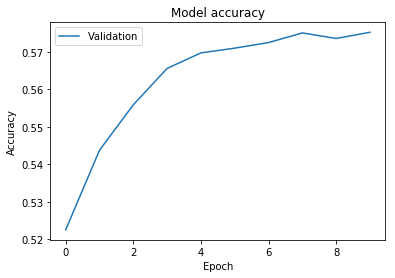

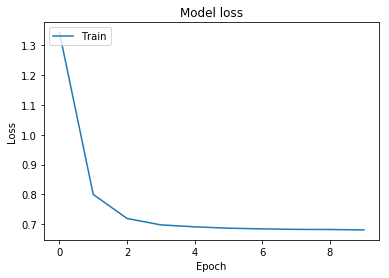

20530/20530 [==============================] - 3s 127us/step


In [222]:
# Feedforward neural network using Keras

# Initialize weights in each layer using glorot uniform distribution
# 1 hidden layer, ReLU activation, 250 nodes
# Dropout regularization, 0.5
# Sigmoid activation in output layer
# Binary cross entropy loss function
# Stochastic gradient descent optimizer with Nesterov momentum and learning rate of 0.001

# Define model        
        
model = Sequential()
# 1st hidden layer
model.add(Dense(75, kernel_initializer = 'glorot_uniform', activation = 'relu', input_shape=(100,)))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
        
model.compile(optimizer = keras.optimizers.SGD(lr = 0.001, nesterov = True),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

# Train model

history = model.fit(balanced_nn_x, balanced_nn_y, epochs = 10, batch_size = 125, shuffle = True)

# Evaluate model

# Plot validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

scores = model.evaluate(dev_nn_x, dev_nn_y, verbose = 1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [525]:
# Evaluation metrics

true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for i in range(len(model.predict(dev_nn_x))):
    if model.predict(dev_nn_x)[i] == 1 and model.predict(dev_nn_x)[i] == 1:
        true_pos += 1
    elif model.predict(dev_nn_x)[i] == 1 and model.predict(dev_nn_x)[i] == 0:
        false_pos += 1
    elif model.predict(dev_nn_x)[i] == 0 and model.predict(dev_nn_x)[i] == 0:
        true_neg += 1
    else:
        false_neg += 1

recall = true_pos / (true_pos + false_neg)
print(recall)

precision = true_pos / (true_pos + false_pos)
print(precision)

F1 = 2 * (precision * recall) / (precision + recall)
print(F1)

## Subtask 7: Literature Review (see report)

## Subtask 8: Improvements

In [55]:
# Reshape inputs for LSTM into sequence of length 2
# Segments have length 50

LSTM_x = np.empty((len(balanced_nn_x), 2, 50))

for i in range(len(balanced_nn_x)):
    LSTM_x[i] = balanced_nn_x[i].reshape(1,2,50)

dev_LSTM_x = np.empty((len(dev_nn_x), 2, 50))

for i in range(len(dev_nn_x)):
    dev_LSTM_x[i] = dev_nn_x[i].reshape(1,2,50)

Epoch 1/15
93946/93946 [==============================] - 25s 265us/step - loss: 0.6951 - acc: 0.5420
Epoch 2/15
93946/93946 [==============================] - 9s 101us/step - loss: 0.6756 - acc: 0.5736
Epoch 3/15
93946/93946 [==============================] - 10s 103us/step - loss: 0.6630 - acc: 0.5933
Epoch 4/15
93946/93946 [==============================] - 10s 104us/step - loss: 0.6494 - acc: 0.6113
Epoch 5/15
93946/93946 [==============================] - 11s 114us/step - loss: 0.6399 - acc: 0.6266
Epoch 6/15
93946/93946 [==============================] - 10s 105us/step - loss: 0.6362 - acc: 0.6299
Epoch 7/15
93946/93946 [==============================] - 11s 114us/step - loss: 0.6307 - acc: 0.6356
Epoch 8/15
93946/93946 [==============================] - 10s 107us/step - loss: 0.6256 - acc: 0.6433
Epoch 9/15
93946/93946 [==============================] - 10s 104us/step - loss: 0.6228 - acc: 0.6469
Epoch 10/15
93946/93946 [==============================] - 10s 108us/step - loss: 0

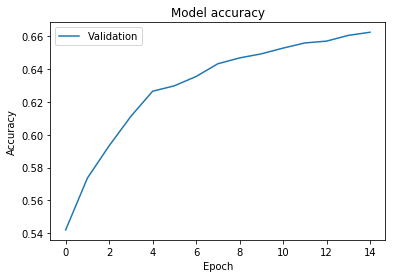

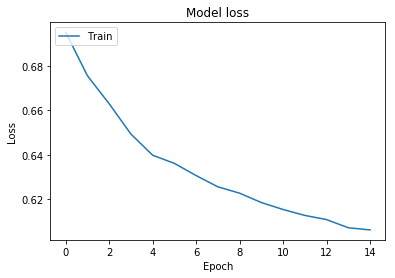

20530/20530 [==============================] - 3s 160us/step


In [226]:
# BiLSTM using Keras
# Updated SGD to Adam optimizer

# Define model        
        
model = Sequential()
# 1st hidden layer
model.add(Bidirectional(LSTM(20, kernel_initializer = 'glorot_uniform', input_shape=(2,50))))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
        
model.compile(optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

# Train model

history = model.fit(LSTM_x, balanced_nn_y, epochs = 15, batch_size = 125, shuffle = True)

# Evaluate model

# Plot validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

scores = model.evaluate(dev_LSTM_x, dev_nn_y, verbose = 1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# Evaluation metrics

true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for i in range(len(model.predict(dev_LSTM_x))):
    if model.predict(dev_LSTM_x)[i] == 1 and model.predict(dev_LSTM_x)[i] == 1:
        true_pos += 1
    elif model.predict(dev_LSTM_x)[i] == 1 and model.predict(dev_LSTM_x)[i] == 0:
        false_pos += 1
    elif model.predict(dev_LSTM_x)[i] == 0 and model.predict(dev_LSTM_x)[i] == 0:
        true_neg += 1
    else:
        false_neg += 1

recall = true_pos / (true_pos + false_neg)
print(recall)

precision = true_pos / (true_pos + false_pos)
print(precision)

F1 = 2 * (precision * recall) / (precision + recall)
print(F1)

In [113]:
# Test subset predictions

# Retrieve the first 10 claims in the test subset

test_claims = test_data[:10]

# Tokenize claims

test_claims_terms_sw = []
    
for claim in test_claims:
    test_claims_terms_sw.append([ps.stem(term) for term in re.findall(r'\b\w+\b', claim['claim'].lower()) if term not in stopwords and term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb'])  

# Flatten lists

test_all_claims_terms_sw = [item for sublist in test_claims_terms_sw for item in sublist]

# Remove duplicates

test_claims_words_sw = list(set(test_all_claims_terms_sw))

In [115]:
# Create inverted index for documents 

test_inverted_index_sw = {}
test_document_number_sw = 0

for file in tqdm(os.listdir(path = 'wiki-pages')): 
    with open('wiki-pages/' + file,'r') as openfile:
        for line in openfile.readlines():
            
            terms = re.findall(r'\b\w+\b', json.loads(line)['text'].lower())
            tokens = [ps.stem(term) for term in terms if term not in stopwords and term != 'LRB' and term != 'RRB' and term != 'LSB' and term != 'RSB']
            
            for word in test_claims_words_sw:
                if word in set(tokens):
                    try:
                        test_inverted_index_sw[word].add((test_document_number_sw, tokens.count(word), len(tokens)))
                    except KeyError:
                        test_inverted_index_sw[word] = set()
                        test_inverted_index_sw[word].add((test_document_number_sw, tokens.count(word), len(tokens)))
                      
            test_document_number_sw += 1

In [116]:
# Create inverted index for claims

test_inverted_index_claims_sw = {}

for index, text in tqdm(enumerate(test_claims_terms_sw)):
    for word in test_claims_words_sw:
        if word in set(text):
            try:
                test_inverted_index_claims_sw[word].add((index, text.count(word), len(text)))
            except KeyError:
                test_inverted_index_claims_sw[word] = set()
                test_inverted_index_claims_sw[word].add((index, text.count(word), len(text)))

In [117]:
# Define IDF Function

def test_IDF_sw(word):
    
    N = len(document_IDs)
    
    n_t = len(test_inverted_index_sw[word])
    
    return math.log10(N / n_t)

In [120]:
# Create IDF vector for relevant words

test_words_IDFs_sw = []

for word in test_claims_words_sw:
    test_words_IDFs_sw.append(test_IDF_sw(word))

In [121]:
# Claims TF-IDF representations

test_claims_TFs_sw = np.zeros((len(test_claims), len(test_claims_words_sw)))

for index, word in tqdm(enumerate(test_claims_words_sw)):
    for value in test_inverted_index_claims_sw[word]:
        test_claims_TFs_sw[value[0]][index] = value[1] / value[2]
        
test_claims_TFIDFs_sw = np.zeros((len(test_claims), len(test_claims_words_sw)))

for i in trange(len(test_claims_TFs_sw)):
    for index, TF in enumerate(test_claims_TFs_sw[i]):
        test_claims_TFIDFs_sw[i][index] = TF * test_words_IDFs_sw[index]  

100%|██████████| 10/10 [00:00<00:00, 2143.56it/s]

In [122]:
# Documents TF-IDF representations

test_documents_TFs_sw = np.zeros((len(document_IDs), len(test_claims_words_sw)))

for index, word in tqdm(enumerate(test_claims_words_sw)):
    for value in tqdm(test_inverted_index_sw[word]):
        test_documents_TFs_sw[value[0]][index] = value[1] / value[2]
        
test_documents_TFIDFs_sw = np.zeros((len(document_IDs), len(test_claims_words_sw)))

for i in trange(len(test_documents_TFs_sw)):
    for index, TF in enumerate(test_documents_TFs_sw[i]):
        test_documents_TFIDFs_sw[i][index] = TF * test_words_IDFs_sw[index]

  0%|          | 2245/5416537 [00:00<04:01, 22449.54it/s]

100%|██████████| 5416537/5416537 [03:55<00:00, 22978.97it/s]


In [123]:
# Define cosine similarity function

def cossim(v1, v2):
    if np.linalg.norm(v2) != 0:
        return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    else:
        return 0

# Create cosine similarity matrix for the test claims
    
test_cossim_matrix_sw = np.zeros((len(test_claims), len(document_IDs)))
    
for index in trange(len(test_claims_TFIDFs_sw)):    
    cossim_claim_sw = []
    for document_TFIDF_sw in tqdm(test_documents_TFIDFs_sw):
        cossim_claim_sw.append(cossim(test_claims_TFIDFs_sw[index], document_TFIDF_sw))
    test_cossim_matrix_sw[index] = cossim_claim_sw

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:12<10:48, 72.00s/it]

 20%|██        | 2/10 [02:34<10:00, 75.04s/it]

 30%|███       | 3/10 [03:59<09:06, 78.05s/it]

 40%|████      | 4/10 [05:22<07:58, 79.72s/it]

 50%|█████     | 5/10 [06:49<06:49, 81.90s/it]

 60%|██████    | 6/10 [08:26<05:45, 86.44s/it]

 70%|███████   | 7/10 [09:42<04:09, 83.13s/it]

 80%|████████  | 8/10 [11:02<02:44, 82.40s/it]

 90%|█████████ | 9/10 [12:21<01:21, 81.26s/it]

100%|██████████| 10/10 [13:43<00:00, 81.49s/it]


In [127]:
# Retrieve indices of 5 most relevant documents for each claim

test_doc_indices = []

for i in trange(len(test_cossim_matrix_sw)):
    claim_doc_indices = []
    for index in reversed(list(np.argsort(test_cossim_matrix_sw[i])[-5:])):
        claim_doc_indices.append(index)
    test_doc_indices.append(claim_doc_indices)

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


In [129]:
# Retrieve 5 most relevant documents for each claim

test_docs = []

for i in tqdm(test_doc_indices):
    for index in i:
        for file in tqdm(os.listdir(path = 'wiki-pages')): 
            with open('wiki-pages/' + file,'r') as openfile:
                for line in openfile.readlines():
                    if json.loads(line)['id'] == document_IDs[index]:
                        test_docs.append(json.loads(line))

In [130]:
# Split the documents for each of the 10 claims

test_docs_chunks = [test_docs[x:x+5] for x in range(0, len(test_docs), 5)]

In [138]:
# Split documents into sentences

test_doc_lines = []

for claim_docs in test_docs_chunks:
    doc_sentences = []
    for doc in claim_docs:
        sentences = []
        for i in range(len(doc['lines'].split('\n'))):
            sentences.append(doc['lines'].split('\n')[i][2:].split('\t')[0])  
        doc_sentences.append(sentences)
    test_doc_lines.append(doc_sentences)

In [139]:
# Tokenize sentences

# Resulting in list of length 10 (10 claims)
# each containing a list of length 5 (5 relevant documents)
# each containing a list of length of the number of lines
# each containing a list of the tokenized words

for i in trange(len(test_doc_lines)):
    for j in trange(len(test_doc_lines[i])):
        for k in trange(len(test_doc_lines[i][j])):
            test_doc_lines[i][j][k] = [term for term in re.findall(r'\b\w+\b', test_doc_lines[i][j][k].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 2316.02it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 11299.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 3792.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 7035.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 5774.10it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 4542.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 2193.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 3562.80it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 6472.69it/s]

  0%|   

In [140]:
# Vectorize document sentences

for i in trange(len(test_doc_lines)):
    for j in trange(len(test_doc_lines[i])):
        for k in trange(len(test_doc_lines[i][j])):
            summed = np.zeros(50)
            for l in range(len(test_doc_lines[i][j][k])):
                try:
                    summed += word_vector(test_doc_lines[i][j][k][l])
                except KeyError:
                    summed += unknown_vec
            test_doc_lines[i][j][k] = summed

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


 11%|█         | 1/9 [00:00<00:05,  1.57it/s]

 22%|██▏       | 2/9 [00:00<00:03,  1.95it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.42it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.08it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.40it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.29it/s]

 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:04,  5.60it/s]

  8%|▊         | 2/24 [00:00<00:04,  4.66it/s]

 21%|██        | 5/24 [00:00<00:03,  5.87it/s]

 25%|██▌       | 6/24 [00:00<00:02,  6.06it/s]

 29%|██▉       | 7/24 [00:01<00:02,  6.00it/s]

 33%|███▎      | 8/24 [00:01<00:02,  6.25it/s]

 38%|███▊      | 9/24 [00:01<00:02,  5.87it/s]

100%|██████████| 24/24 [00:01<00:00,  8.25it/s]


 40%|████

 40%|████      | 2/5 [00:02<00:03,  1.10s/it]

  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:02,  5.03it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.89it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.14it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  7.61it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.41it/s]

 60%|██████    | 3/5 [00:03<00:02,  1.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:00,  8.57it/s]

 60%|██████    | 3/5 [00:00<00:00,  8.23it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.88it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:00<00:02,  3.86it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.91it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.49it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.29it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.80it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:00<00:04,  4

In [147]:
# Vectorize claims

for i in trange(len(test_claims_terms_sw)):
    summed = np.zeros(50)
    for j in range(len(test_claims_terms_sw[i])):
        try:
            summed += word_vector(test_claims_terms_sw[i][j])
        except KeyError:
            summed += unknown_vec
    test_claims_terms_sw[i] = summed

  0%|          | 0/10 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


In [150]:
# Concatenate vector for claim and document sentence

for i in trange(len(test_doc_lines)):
    for j in range(len(test_doc_lines[i])):
        for k in range(len(test_doc_lines[i][j])):
            test_doc_lines[i][j][k] = np.concatenate((test_claims_terms_sw[i], test_doc_lines[i][j][k]))

100%|██████████| 10/10 [00:00<00:00, 741.95it/s]


In [167]:
# Add bias

for i in trange(len(test_doc_lines)):
    for j in range(len(test_doc_lines[i])):
        for k in range(len(test_doc_lines[i][j])):
            test_doc_lines[i][j][k] = np.concatenate((np.zeros(1), test_doc_lines[i][j][k]))

100%|██████████| 10/10 [00:00<00:00, 1495.67it/s]


In [401]:
# Calculate relevance predictions
# Take weights from logistic regression model with learning rate = 0.001

predictions = []

for claim in test_doc_lines:
    claim_predictions = []
    for doc in claim:
        doc_predictions = []
        for sentence in doc:
            if sigmoid(np.matmul(sentence, logreg_weights)) > 0.5:
                doc_predictions.append(1)
            else:
                doc_predictions.append(0)
        claim_predictions.append(doc_predictions)
    predictions.append(claim_predictions)

In [402]:
# Retrieve indices of predicted relevant sentences

relevant_indices = []

for claim in predictions:
    claim_relevant_indices = []
    for index1, document in enumerate(claim):
        for index2, sentence in enumerate(document):
            if sentence == 1:
                claim_relevant_indices.append([index1, index2])
    relevant_indices.append(claim_relevant_indices)

In [403]:
# Retrieve relevant sentences from predictions

relevant_sentences = []

for i in range(len(predictions)):
    claim_sentences = []
    for j in range(len(predictions[i])):
        for k in range(len(predictions[i][j])):
            if predictions[i][j][k] == 1:
                claim_sentences.append(test_doc_lines[i][j][k])
    relevant_sentences.append(claim_sentences)

In [404]:
# Reshape input for LSTM

test_LSTM_inputs = []

for i in range(len(relevant_sentences)):
    test_LSTM_claim = np.empty((len(relevant_sentences[i]), 2, 50))
    
    for j in range(len(relevant_sentences[i])):
    
        test_LSTM_claim[j] = relevant_sentences[i][j][1:].reshape(1,2,50)
    
    test_LSTM_inputs.append(test_LSTM_claim)

In [405]:
# Predict the claims' veracity using biLSTM model
# Average the predictions for each claim

truth_predictions = []

for claim in test_LSTM_inputs:
    claim_predictions = []
    predictions = model.predict(claim)
    for prediction in predictions:
        if prediction > 0.5:
            claim_predictions.append(1)
        else:
            claim_predictions.append(0)
    truth_predictions.append(claim_predictions)
    
final_predictions = [None]*len(truth_predictions)

for i in range(len(final_predictions)):
    average_prediction = np.mean(np.array(truth_predictions[i]))
    if average_prediction > 0.5:
        final_predictions[i] = 'SUPPORTS'
    else:
        final_predictions[i] = 'REFUTES'

In [406]:
# Retrieve indices of those predicted relevant sentences who make the same final prediction as the averaged predictions

evidence = []

for index1, average_prediction in enumerate(final_predictions):
    claim_evidence = []
    if average_prediction == 'SUPPORTS':
        prediction = 1
    else:
        prediction = 0
    for index2, sentence_prediction in enumerate(truth_predictions[index1]):
        if sentence_prediction == prediction:
            claim_evidence.append(relevant_indices[index1][index2])
    evidence.append(claim_evidence)

In [407]:
# Retrieve document ID and line of relevant sentences

predicted_evidence = []

for index, claim in enumerate(evidence):
    claim_predicted_evidence = []
    for sentence in claim:
        claim_predicted_evidence.append([document_IDs[test_doc_indices[index][sentence[0]]], sentence[1]])
    predicted_evidence.append(claim_predicted_evidence)

In [408]:
# Create a list of dictionaries containing the predicted evidence

submission_predictions = []

for index, claim in enumerate(predicted_evidence):
    claim_dic = {}
    claim_dic["id"] = test_claims[index]['id']
    claim_dic["predicted_label"] = final_predictions[index]
    claim_dic["predicted_evidence"] = []
    for evidence in claim:
        claim_dic["predicted_evidence"].append(evidence)
    submission_predictions.append(claim_dic)

In [410]:
# Create a jsonl file containing the test predictions

output_filepath = "Q8_test_predictions.jsonl"

json_objects = []

for line in submission_predictions:
    json_objects.append(json.dumps(line))
    
writable_str = "\n".join(json_objects)

with open(output_filepath, 'w') as outfile:
    outfile.write(writable_str)

## Interactive Function

In [415]:
# Final model

def Automated_Fact_Checker(claim):
    
    # Tokenize claim
    
    claim_terms = [ps.stem(term) for term in re.findall(r'\b\w+\b', claim.lower()) if term not in stopwords and term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']
    
    # Inverted index for documents 

    document_inverted_index = {}
    document_number = 0

    for file in os.listdir(path = 'wiki-pages'): 
        with open('wiki-pages/' + file,'r') as openfile:
            for line in openfile.readlines():
            
                document_terms = [ps.stem(term) for term in re.findall(r'\b\w+\b', json.loads(line)['text'].lower()) if term not in stopwords and term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']
            
                for word in set(claim_terms):
                    if word in set(document_terms):
                        try:
                            document_inverted_index[word].add((document_number, document_terms.count(word), len(document_terms)))
                        except KeyError:
                            document_inverted_index[word] = set()
                            document_inverted_index[word].add((document_number, document_terms.count(word), len(document_terms)))
                      
                document_number += 1
                
    # Inverted index for claim

    claim_inverted_index = {}

    for word in set(claim_terms):
        try:
            claim_inverted_index[word].add((claim_terms.count(word), len(claim_terms)))
        except KeyError:
            claim_inverted_index[word] = set()
            claim_inverted_index[word].add((claim_terms.count(word), len(claim_terms)))
            
    # Define IDF Function

    def IDF(word):
    
        N = len(document_IDs)
    
        n_t = len(document_inverted_index[word])
    
        return math.log10(N / n_t)
    
    # Create IDF vector for relevant words

    words = list(set(claim_terms))
    
    IDF_vector = []

    for word in words:
        IDF_vector.append(IDF(word))
        
    # Claims TF-IDF representations

    claim_TFs = np.zeros((len(words)))

    for index, word in enumerate(words):
        for value in claim_inverted_index[word]:
            claim_TFs[index] = value[0] / value[1]
        
    claim_TFIDFs = np.zeros((len(words)))

    for index, TF in enumerate(claim_TFs):
            claims_TFIDFs[index] = TF * IDF_vector[index]  
            
    # Documents TF-IDF representations

    document_TFs = np.zeros((len(document_IDs), len(words)))

    for index, word in enumerate(words):
        for value in document_inverted_index[word]:
            document_TFs[value[0]][index] = value[1] / value[2]
        
    document_TFIDFs = np.zeros((len(document_IDs), len(words)))

    for i in range(len(document_TFs)):
        for index, TF in enumerate(document_TFs[i]):
            document_TFIDFs[i][index] = TF * IDF_vector[index]
            
    # Define cosine similarity function

    def cossim(v1, v2):
        if np.linalg.norm(v2) != 0:
            return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        else:
            return 0
    
    # Create cosine similarity matrix for the test claims
    
    cossim_values = []
    
    for index, document in enumerate(document_TFIDFs):
        cossim_values.append(cossim(np.array(claim_TFIDF), np.array(document)))
        
    # Retrieve indices of 5 most relevant documents

    relevant_document_indices = []
    
    for index in reversed(list(np.argsort(cossim_values)[-5:])):
        relevant_document_indices.append(index)
        
    # Retrieve 5 most relevant documents

    documents = []

    for index in relevant_document_indices:
        for file in os.listdir(path = 'wiki-pages'): 
            with open('wiki-pages/' + file,'r') as openfile:
                for line in openfile.readlines():
                    if json.loads(line)['id'] == document_IDs[index]:
                        documents.append(json.loads(line))
                        
    # Split documents into sentences

    document_sentences = []
    
    for document in documents:
        sentences = []
        for i in range(len(document['lines'].split('\n'))):
            sentences.append(document['lines'].split('\n')[i][2:].split('\t')[0])  
        document_sentences.append(sentences)
        
    # Tokenize sentences

    for i in range(len(document_sentences)):
        for j in trange(len(document_sentences[i])):
            document_sentences[i][j] = [term for term in re.findall(r'\b\w+\b', document_sentences[i][j].lower()) if term != 'lrb' and term != 'rrb' and term != 'lsb' and term != 'rsb' and term != 'lcb' and term != 'rcb']  
            
    # Vectorize document sentences

    for i in range(len(document_sentences)):
        for j in range(len(document_sentences[i])):
            summed = np.zeros(50)
            for k in range(len(document_sentences[i][j])):
                try:
                    summed += word_vector(document_sentences[i][j][k])
                except KeyError:
                    summed += unknown_vec
            document_sentences[i][j] = summed
            
    # Vectorize claims

    claim_vector = np.zeros(50)
    for i in range(len(claim_terms)):
        try:
            claim_vector += word_vector(claim_terms[i])
        except KeyError:
            claim_vector += unknown_vec
            
    # Concatenate vector for claim and document sentence

    for i in range(len(document_sentences)):
        for j in range(len(document_sentences[i])):
            document_sentences[i][j] = np.concatenate((claim_vector, document_sentences[i][j]))
            
    # Add bias

    for i in range(len(document_sentences)):
        for j in range(len(document_sentences[i])):
            document_sentences[i][j] = np.concatenate((np.zeros(1), document_sentences[i][j]))
            
    # Predict relevance of sentences
    # Take weights from logistic regression model with learning rate = 0.001

    relevance_predictions = []

    for document in document_sentences:
        document_predictions = []
        for sentence in document:
            if sigmoid(np.matmul(sentence, logreg_weights)) > 0.5:
                document_predictions.append(1)
            else:
                document_predictions.append(0)
        relevance_predictions.append(document_predictions)
        
    # Retrieve indices of predicted relevant sentences

    relevant_indices = []

    for index1, document in enumerate(relevance_predictions):
        for index2, sentence in enumerate(document):
            if sentence == 1:
                relevant_indices.append([index1, index2])
                
    # Retrieve relevant sentences from predictions

    relevant_sentences = []

    for i in range(len(relevance_predictions)):
        for j in range(len(relevance_predictions[i])):
            if relevance_predictions[i][j] == 1:
                relevant_sentences.append(document_sentences[i][j])
    
    # Reshape input for LSTM

    LSTM_input = np.empty((len(relevant_sentences), 2, 50))
    
    for i in range(len(relevant_sentences)):
    
        LSTM_input[i] = relevant_sentences[i][1:].reshape(1,2,50)
        
    # Predict the claims' veracity using LSTM final model
    # Average the predictions for each claim

    veracity_predictions = []

    predictions = model.predict(LSTM_input)
    for prediction in predictions:
        if prediction > 0.5:
            veracity_predictions.append(1)
        else:
            veracity_predictions.append(0)

    average_prediction = np.mean(np.array(veracity_predictions))
    if average_prediction > 0.5:
        final_prediction = 'SUPPORTS'
    else:
        final_prediction = 'REFUTES'
        
    # Retrieve indices of those predicted relevant sentences who make the same final prediction as the averaged predictions

    evidence = []

    if final_prediction == 'SUPPORTS':
        prediction = 1
    else:
        prediction = 0
    for index, sentence_prediction in enumerate(veracity_predictions):
        if sentence_prediction == prediction:
            evidence.append(relevant_indices[index])
                
    # Retrieve document ID and line of relevant sentences

    predicted_evidence = []

    for sentence in evidence:
        predicted_evidence.append([document_IDs[relevant_document_indices[sentence[0]]], sentence[1]])
        
    # Create a list of dictionaries containing the predicted evidence

    claim_prediction = {}

    claim_prediction["predicted_label"] = final_prediction
    claim_prediction["predicted_evidence"] = []
    for evidence in predicted_evidence:
        claim_prediction["predicted_evidence"].append(evidence)
        
    # Print prediction
    
    print(claim_prediction)
    
    return claim_prediction

In [ ]:
# Input claim inside quotation marks into Automated_Fact_Checker function
# Function will print 'SUPPORTS' or 'REFUTES' and the supporting evidence documents and lines

Automated_Fact_Checker("")